# HMM Analysis on Power Sweep

In [63]:
from hmmlearn import hmm
import numpy as np
import matplotlib.pyplot as plt
import fitTools.quasiparticleFunctions as qp
from mpl_toolkits.axes_grid1 import make_axes_locatable
import h5py
import glob

project_path = r"G:\Shared drives\Quasiparticles_2\NBR07_Oct2022\Power_Sweep_Alazar_Card_TWPA_JPA_ON_No_Final_Amplifier_Higher_fd"
figurepath = r"{}\PowerSweepfigures\\".format(project_path)


import os
if not os.path.exists(figurepath):
    os.makedirs(figurepath)

In [64]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.size'] = 10
plt.rcParams['figure.facecolor'] = 'white'


plt.rcParams.update({'axes.labelpad':0.2,
                     'axes.linewidth':1.0,
                     'figure.dpi':300.0,
                     'legend.frameon':True,
                     'legend.handlelength':1.0,
                     'xtick.major.pad':2,
                     'xtick.minor.pad':2,
                     'xtick.major.width':1.0,
                     'ytick.major.pad':2,
                     'ytick.minor.pad':2,
                     'ytick.major.width':1.0,
                     'axes.ymargin':0.01,
                     'axes.xmargin':0.01})

# Initial Configurations for HMM

1) make IQ plot at lowest attenuation/(attenuation at which power to device is -127dB) at reduced sample rate to visually retrieve means

2) set the retrieved means as the initial guess means

3) do HMM analysis by looping over the files in ascending order of attentuation (i.e. 0,2,4...,38) / (attenuation greater than and equal to attenuation at which power to device is -127dB)


## File Sorting


In [65]:
files = glob.glob(r"{}\**\*.bin".format(project_path),recursive=True)
files[0], files[-1]

('G:\\Shared drives\\Quasiparticles_2\\NBR07_Oct2022\\Power_Sweep_Alazar_Card_TWPA_JPA_ON_No_Final_Amplifier_Higher_fd\\470flux_DA 0_SR10MHz\\NBR07_20221005_182717.bin',
 'G:\\Shared drives\\Quasiparticles_2\\NBR07_Oct2022\\Power_Sweep_Alazar_Card_TWPA_JPA_ON_No_Final_Amplifier_Higher_fd\\470flux_DA48_SR10MHz\\NBR07_20221005_183406.bin')

In [66]:
attens = []
for file in files:
    _,s = file.split('_DA')
    atten = s[:2]
    attens.append(int(atten))

In [67]:
attens[0], attens[-1]

(0, 48)

In [68]:
sortind = np.argsort(attens)

In [69]:
np.asarray(attens)[sortind[::-1]]

array([48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16,
       14, 12, 10,  8,  6,  4,  2,  0])

In [70]:
files = np.asarray(files)[sortind[::-1]]
attens = np.asarray(attens)[sortind[::-1]]

In [71]:
for i,file in zip(attens,files):
    print('{} has attenaution {}'.format(file,i))

G:\Shared drives\Quasiparticles_2\NBR07_Oct2022\Power_Sweep_Alazar_Card_TWPA_JPA_ON_No_Final_Amplifier_Higher_fd\470flux_DA48_SR10MHz\NBR07_20221005_183406.bin has attenaution 48
G:\Shared drives\Quasiparticles_2\NBR07_Oct2022\Power_Sweep_Alazar_Card_TWPA_JPA_ON_No_Final_Amplifier_Higher_fd\470flux_DA46_SR10MHz\NBR07_20221005_183350.bin has attenaution 46
G:\Shared drives\Quasiparticles_2\NBR07_Oct2022\Power_Sweep_Alazar_Card_TWPA_JPA_ON_No_Final_Amplifier_Higher_fd\470flux_DA44_SR10MHz\NBR07_20221005_183333.bin has attenaution 44
G:\Shared drives\Quasiparticles_2\NBR07_Oct2022\Power_Sweep_Alazar_Card_TWPA_JPA_ON_No_Final_Amplifier_Higher_fd\470flux_DA42_SR10MHz\NBR07_20221005_183317.bin has attenaution 42
G:\Shared drives\Quasiparticles_2\NBR07_Oct2022\Power_Sweep_Alazar_Card_TWPA_JPA_ON_No_Final_Amplifier_Higher_fd\470flux_DA40_SR10MHz\NBR07_20221005_183300.bin has attenaution 40
G:\Shared drives\Quasiparticles_2\NBR07_Oct2022\Power_Sweep_Alazar_Card_TWPA_JPA_ON_No_Final_Amplifier_Hi

### Changing the order of the files in descending format of the power and attenuation

In [41]:
def create_IQ_plot(data):
    ax = qp.plotComplexHist(data[0],data[1])
    plt.show()


In [72]:
files[0], attens[0]

('G:\\Shared drives\\Quasiparticles_2\\NBR07_Oct2022\\Power_Sweep_Alazar_Card_TWPA_JPA_ON_No_Final_Amplifier_Higher_fd\\470flux_DA48_SR10MHz\\NBR07_20221005_183406.bin',
 48)

In [73]:
files[-1], attens[-1]

('G:\\Shared drives\\Quasiparticles_2\\NBR07_Oct2022\\Power_Sweep_Alazar_Card_TWPA_JPA_ON_No_Final_Amplifier_Higher_fd\\470flux_DA 0_SR10MHz\\NBR07_20221005_182717.bin',
 0)

In [74]:
files = np.flip(files,0)
attens = np.flip(attens,0)

In [75]:
files[0], attens[0]

('G:\\Shared drives\\Quasiparticles_2\\NBR07_Oct2022\\Power_Sweep_Alazar_Card_TWPA_JPA_ON_No_Final_Amplifier_Higher_fd\\470flux_DA 0_SR10MHz\\NBR07_20221005_182717.bin',
 0)

In [76]:
files[-1], attens[-1]

('G:\\Shared drives\\Quasiparticles_2\\NBR07_Oct2022\\Power_Sweep_Alazar_Card_TWPA_JPA_ON_No_Final_Amplifier_Higher_fd\\470flux_DA48_SR10MHz\\NBR07_20221005_183406.bin',
 48)

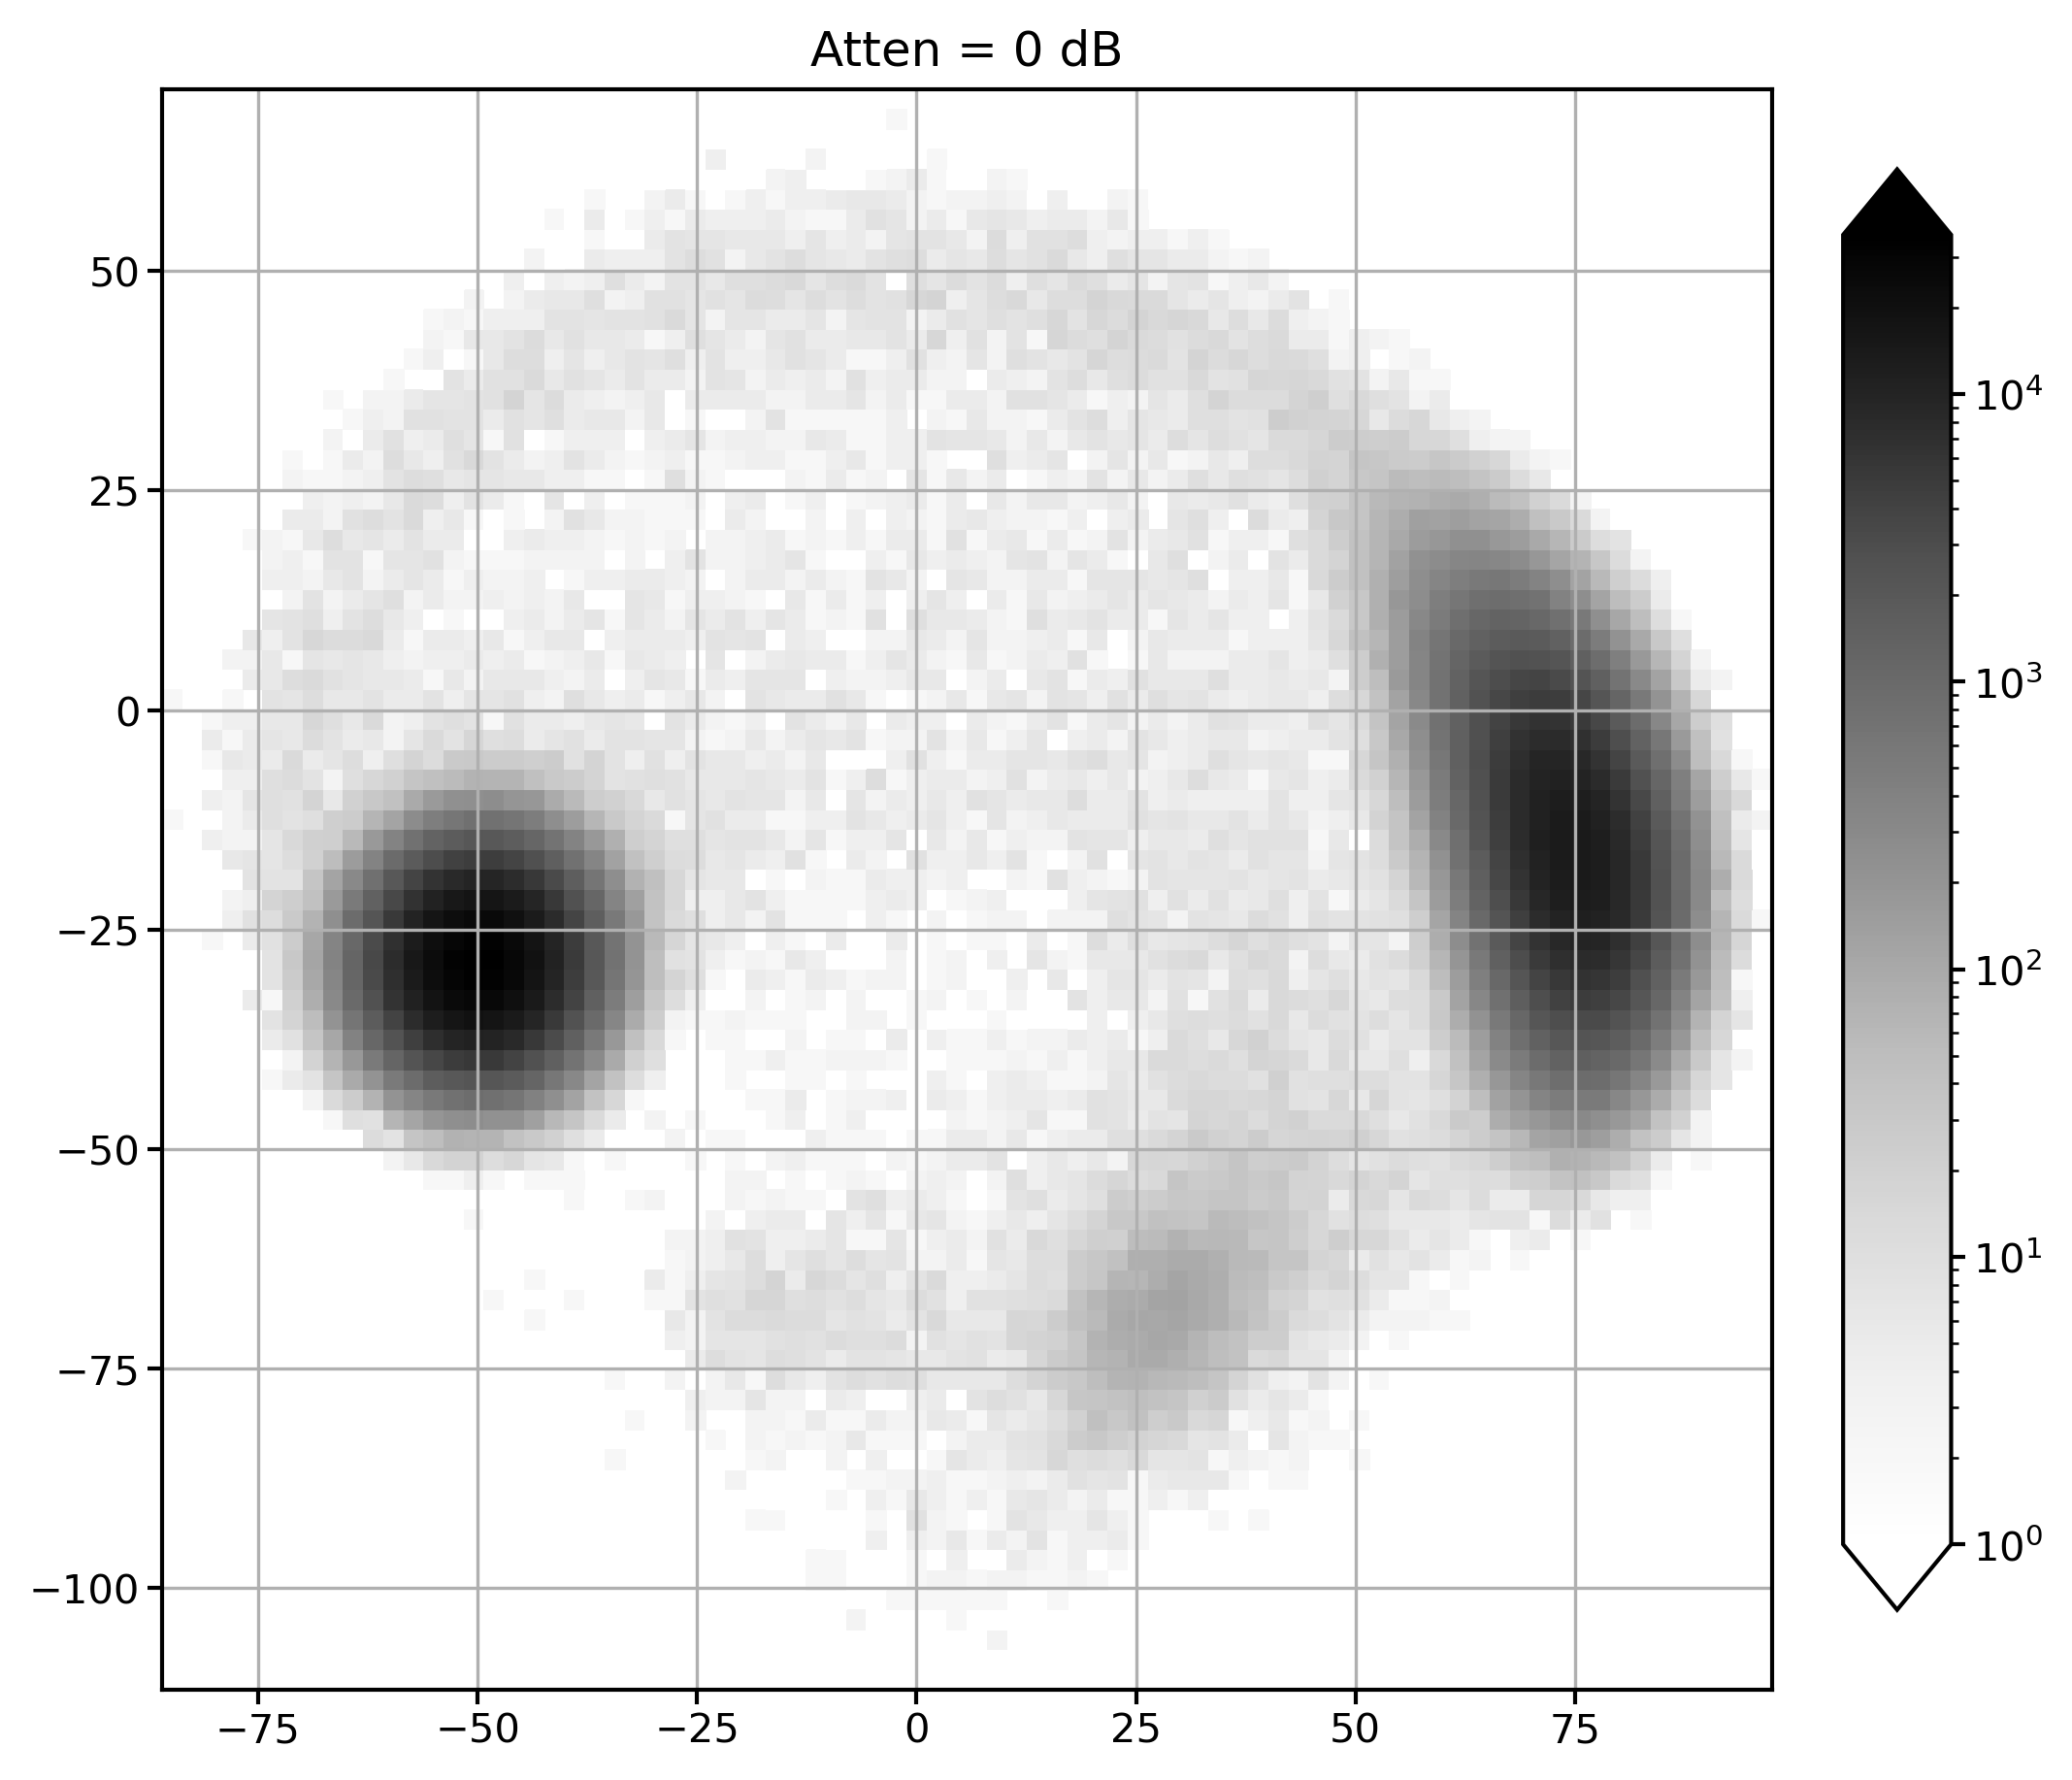

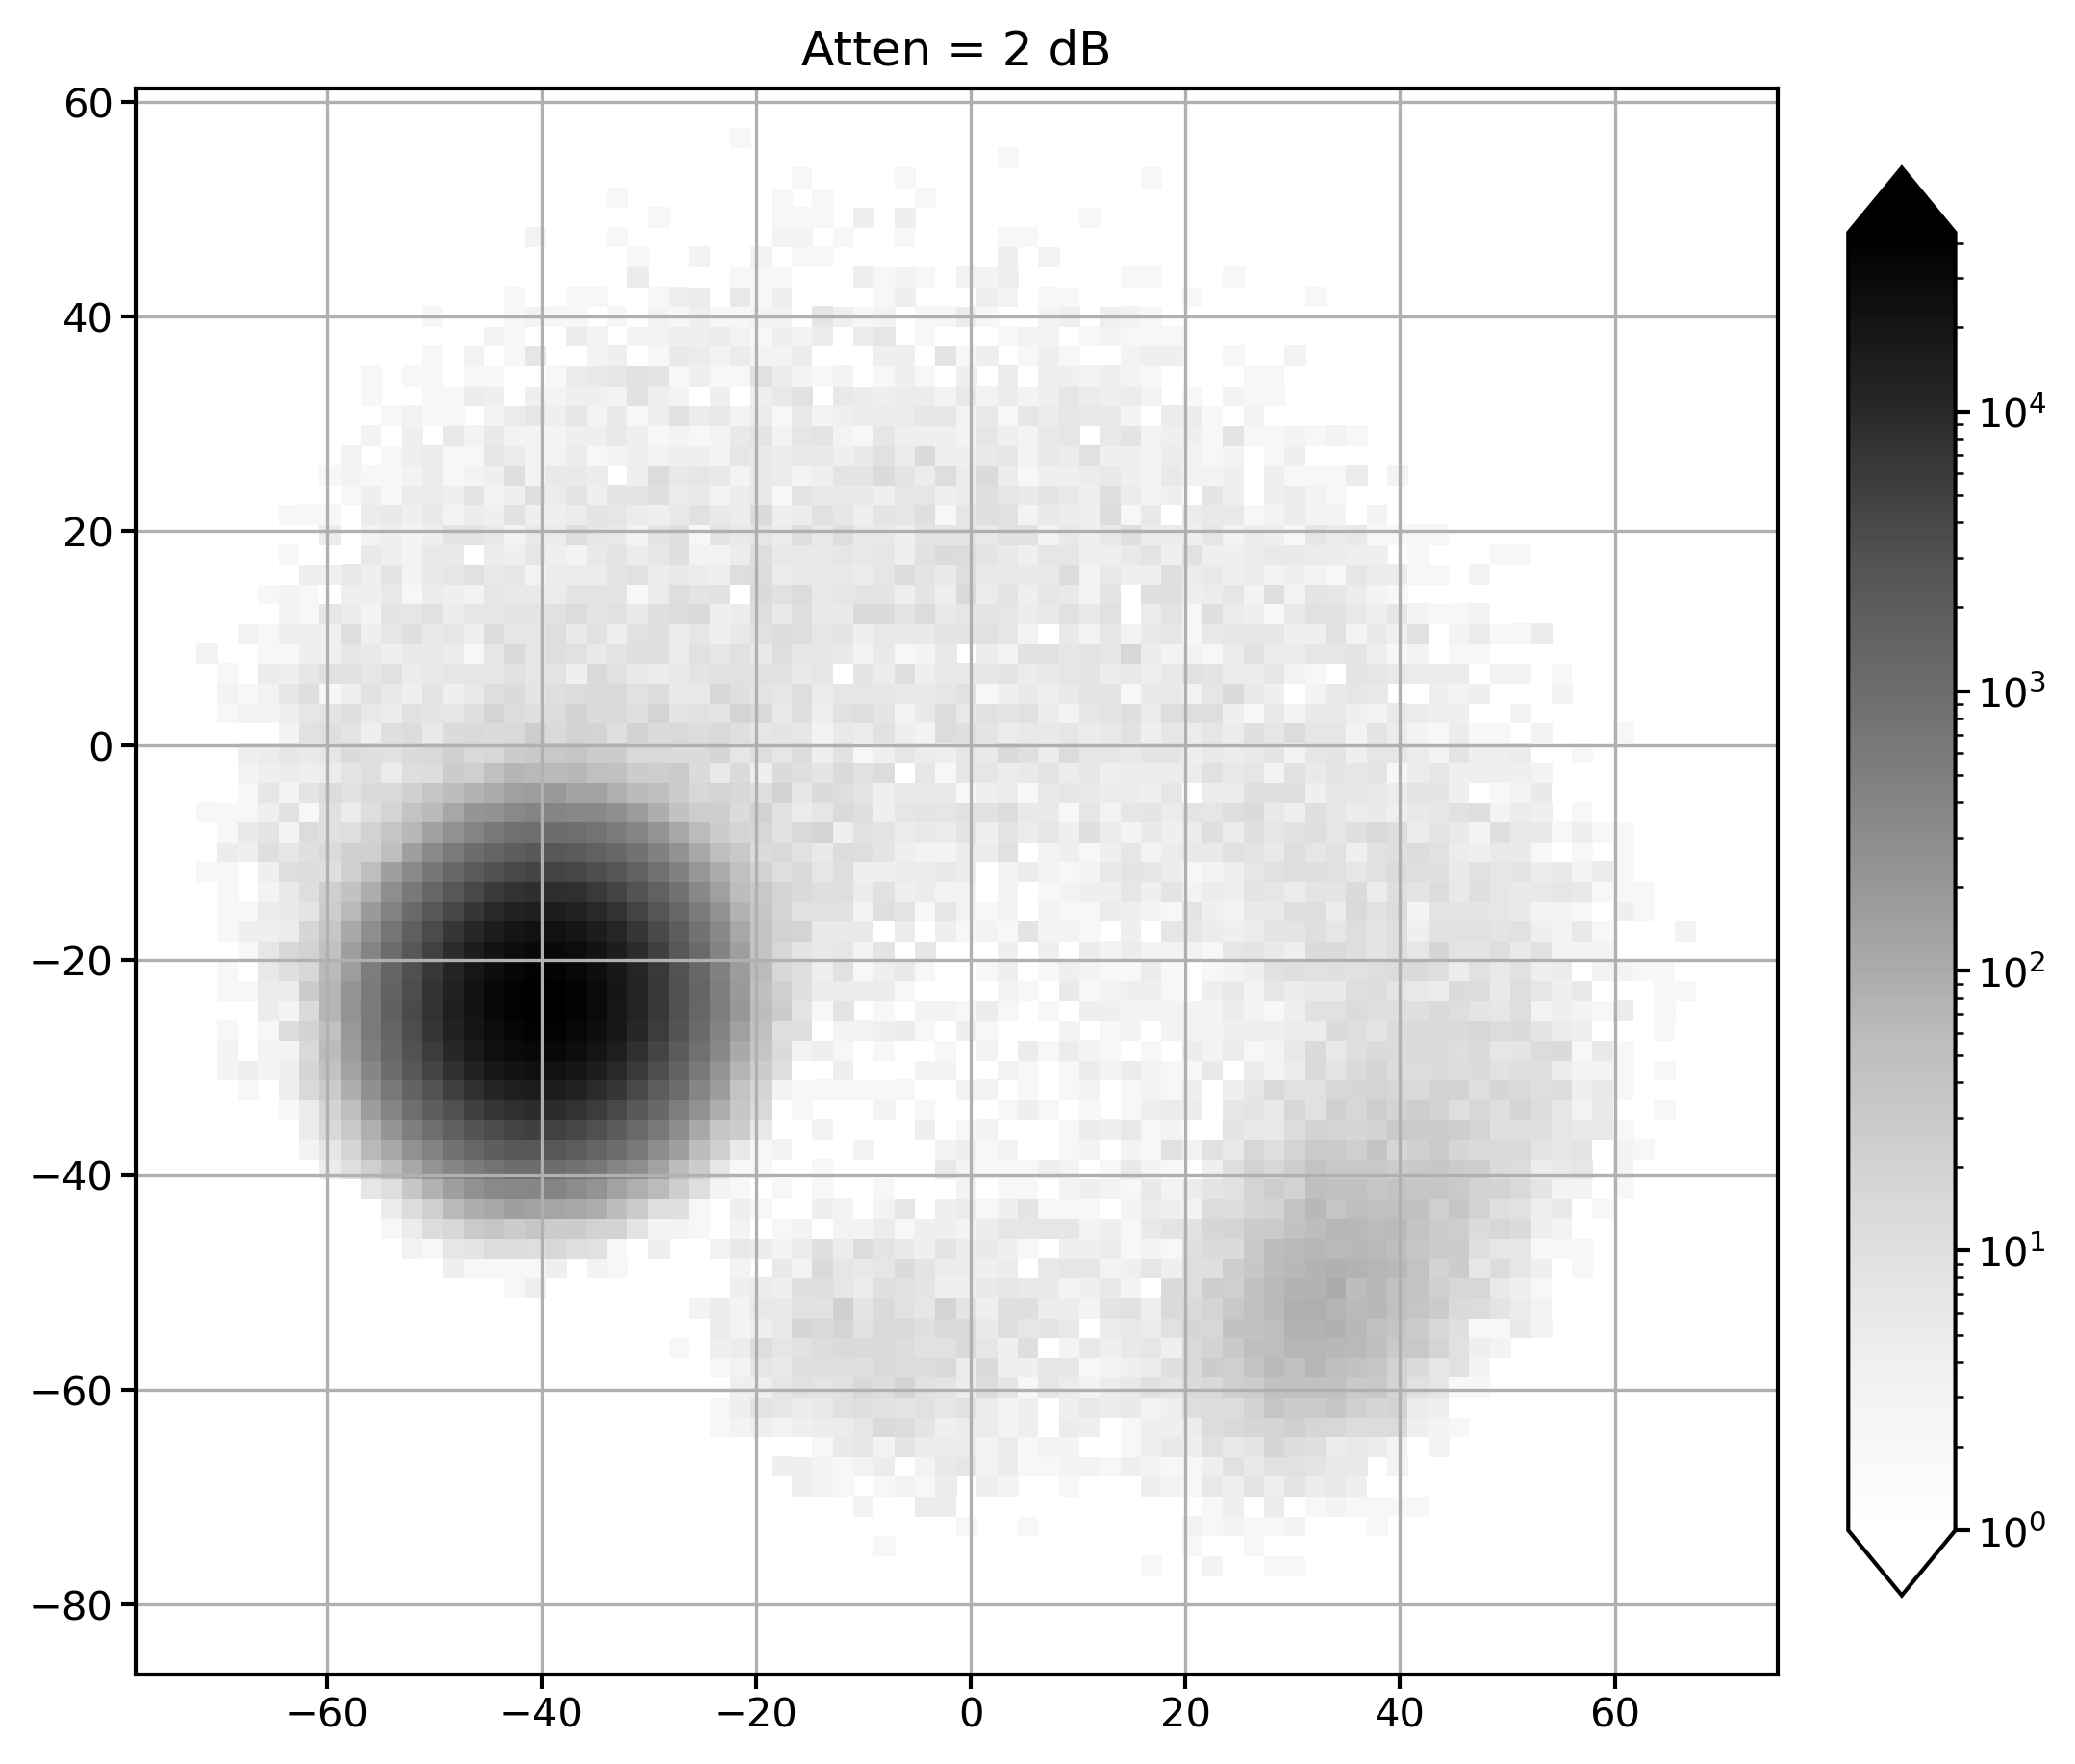

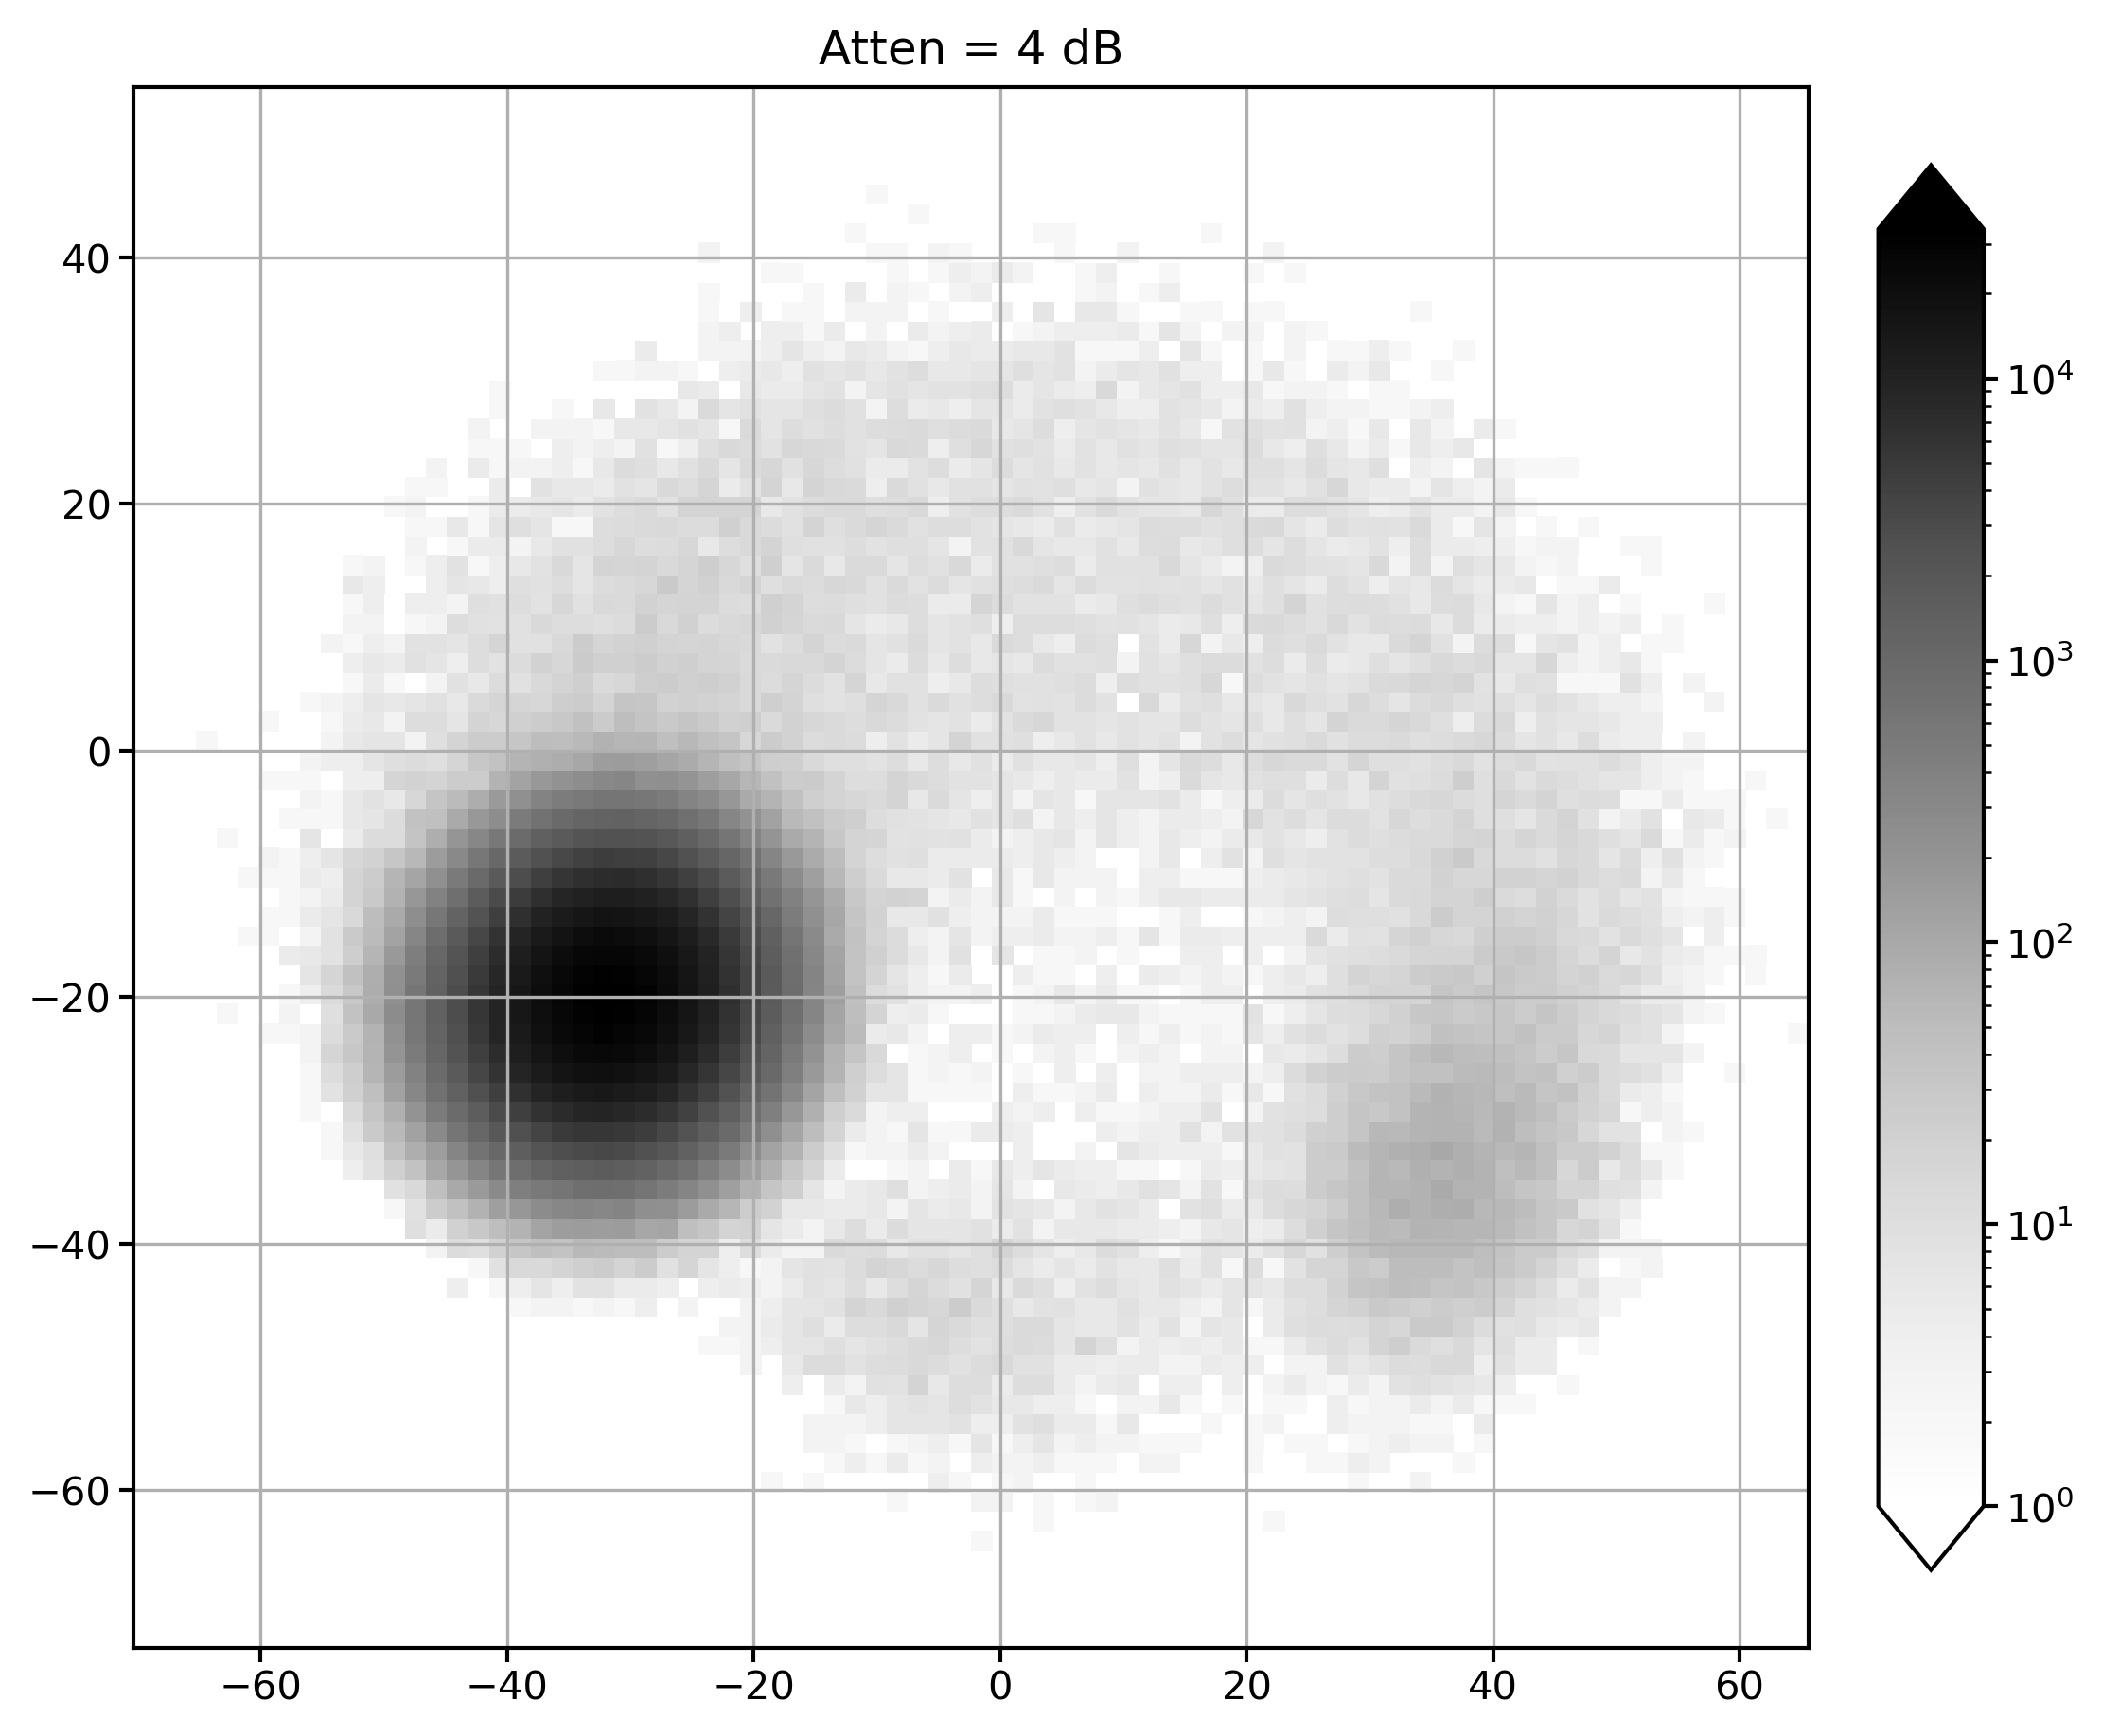

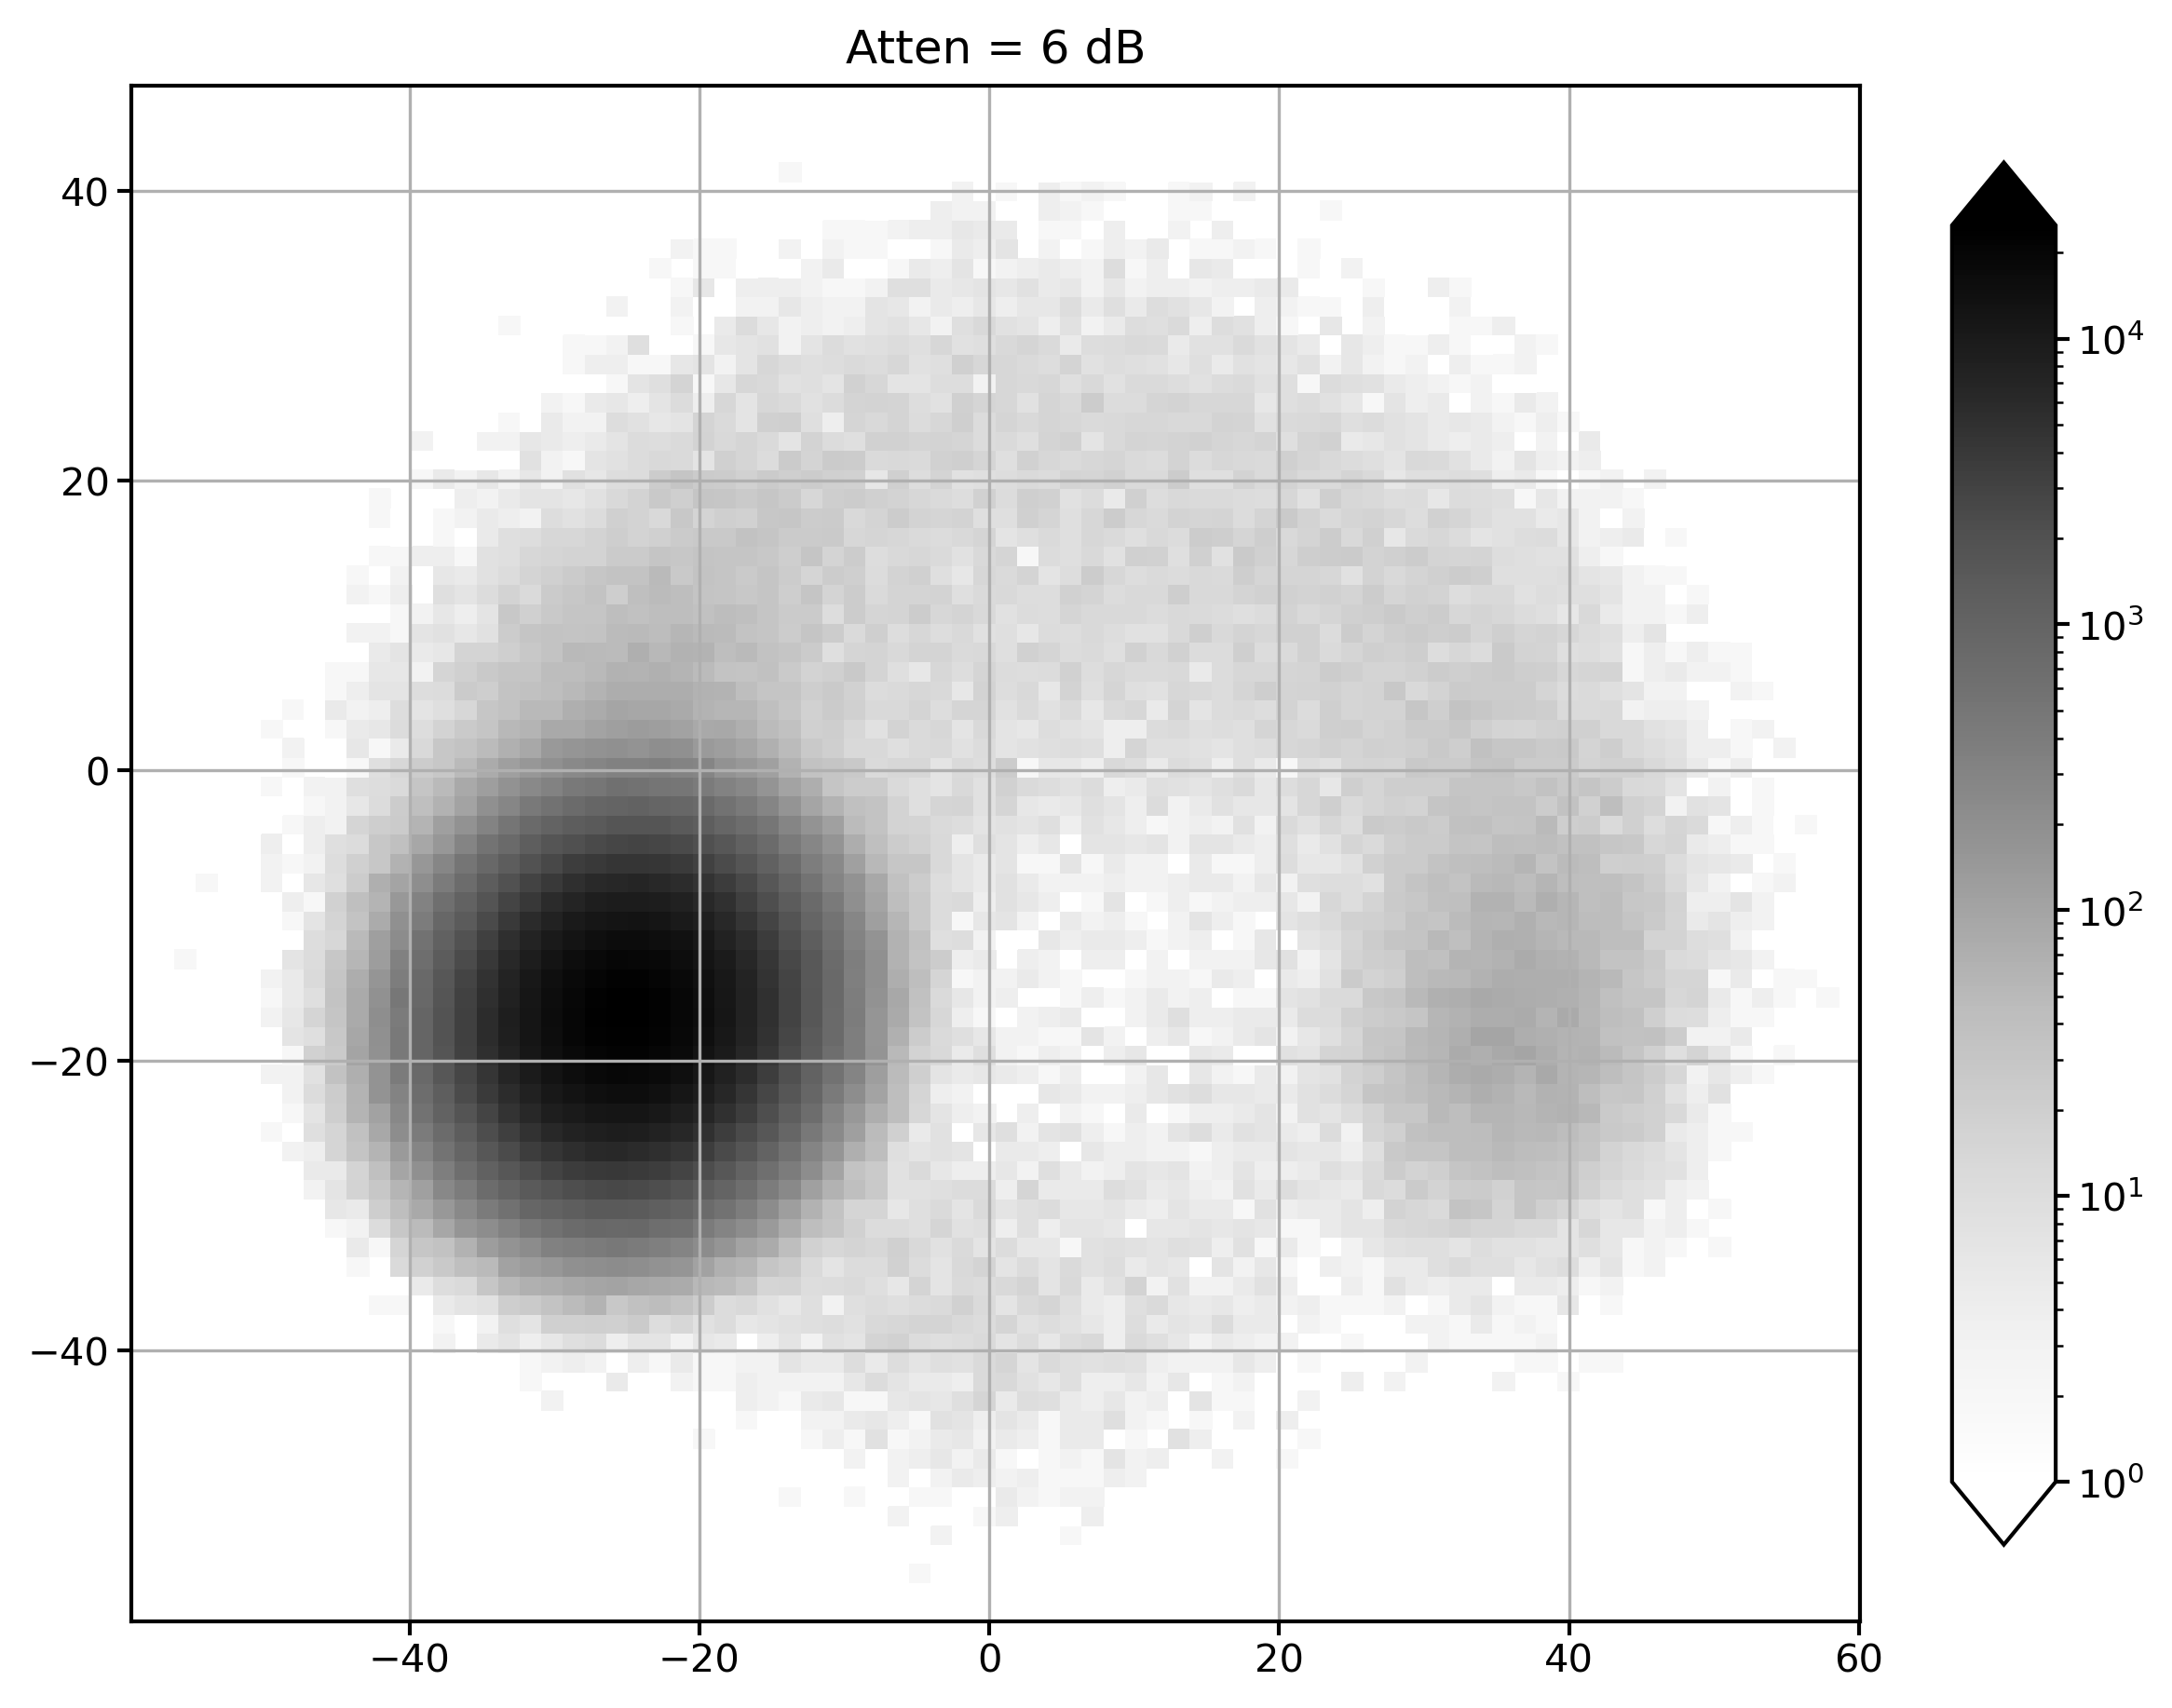

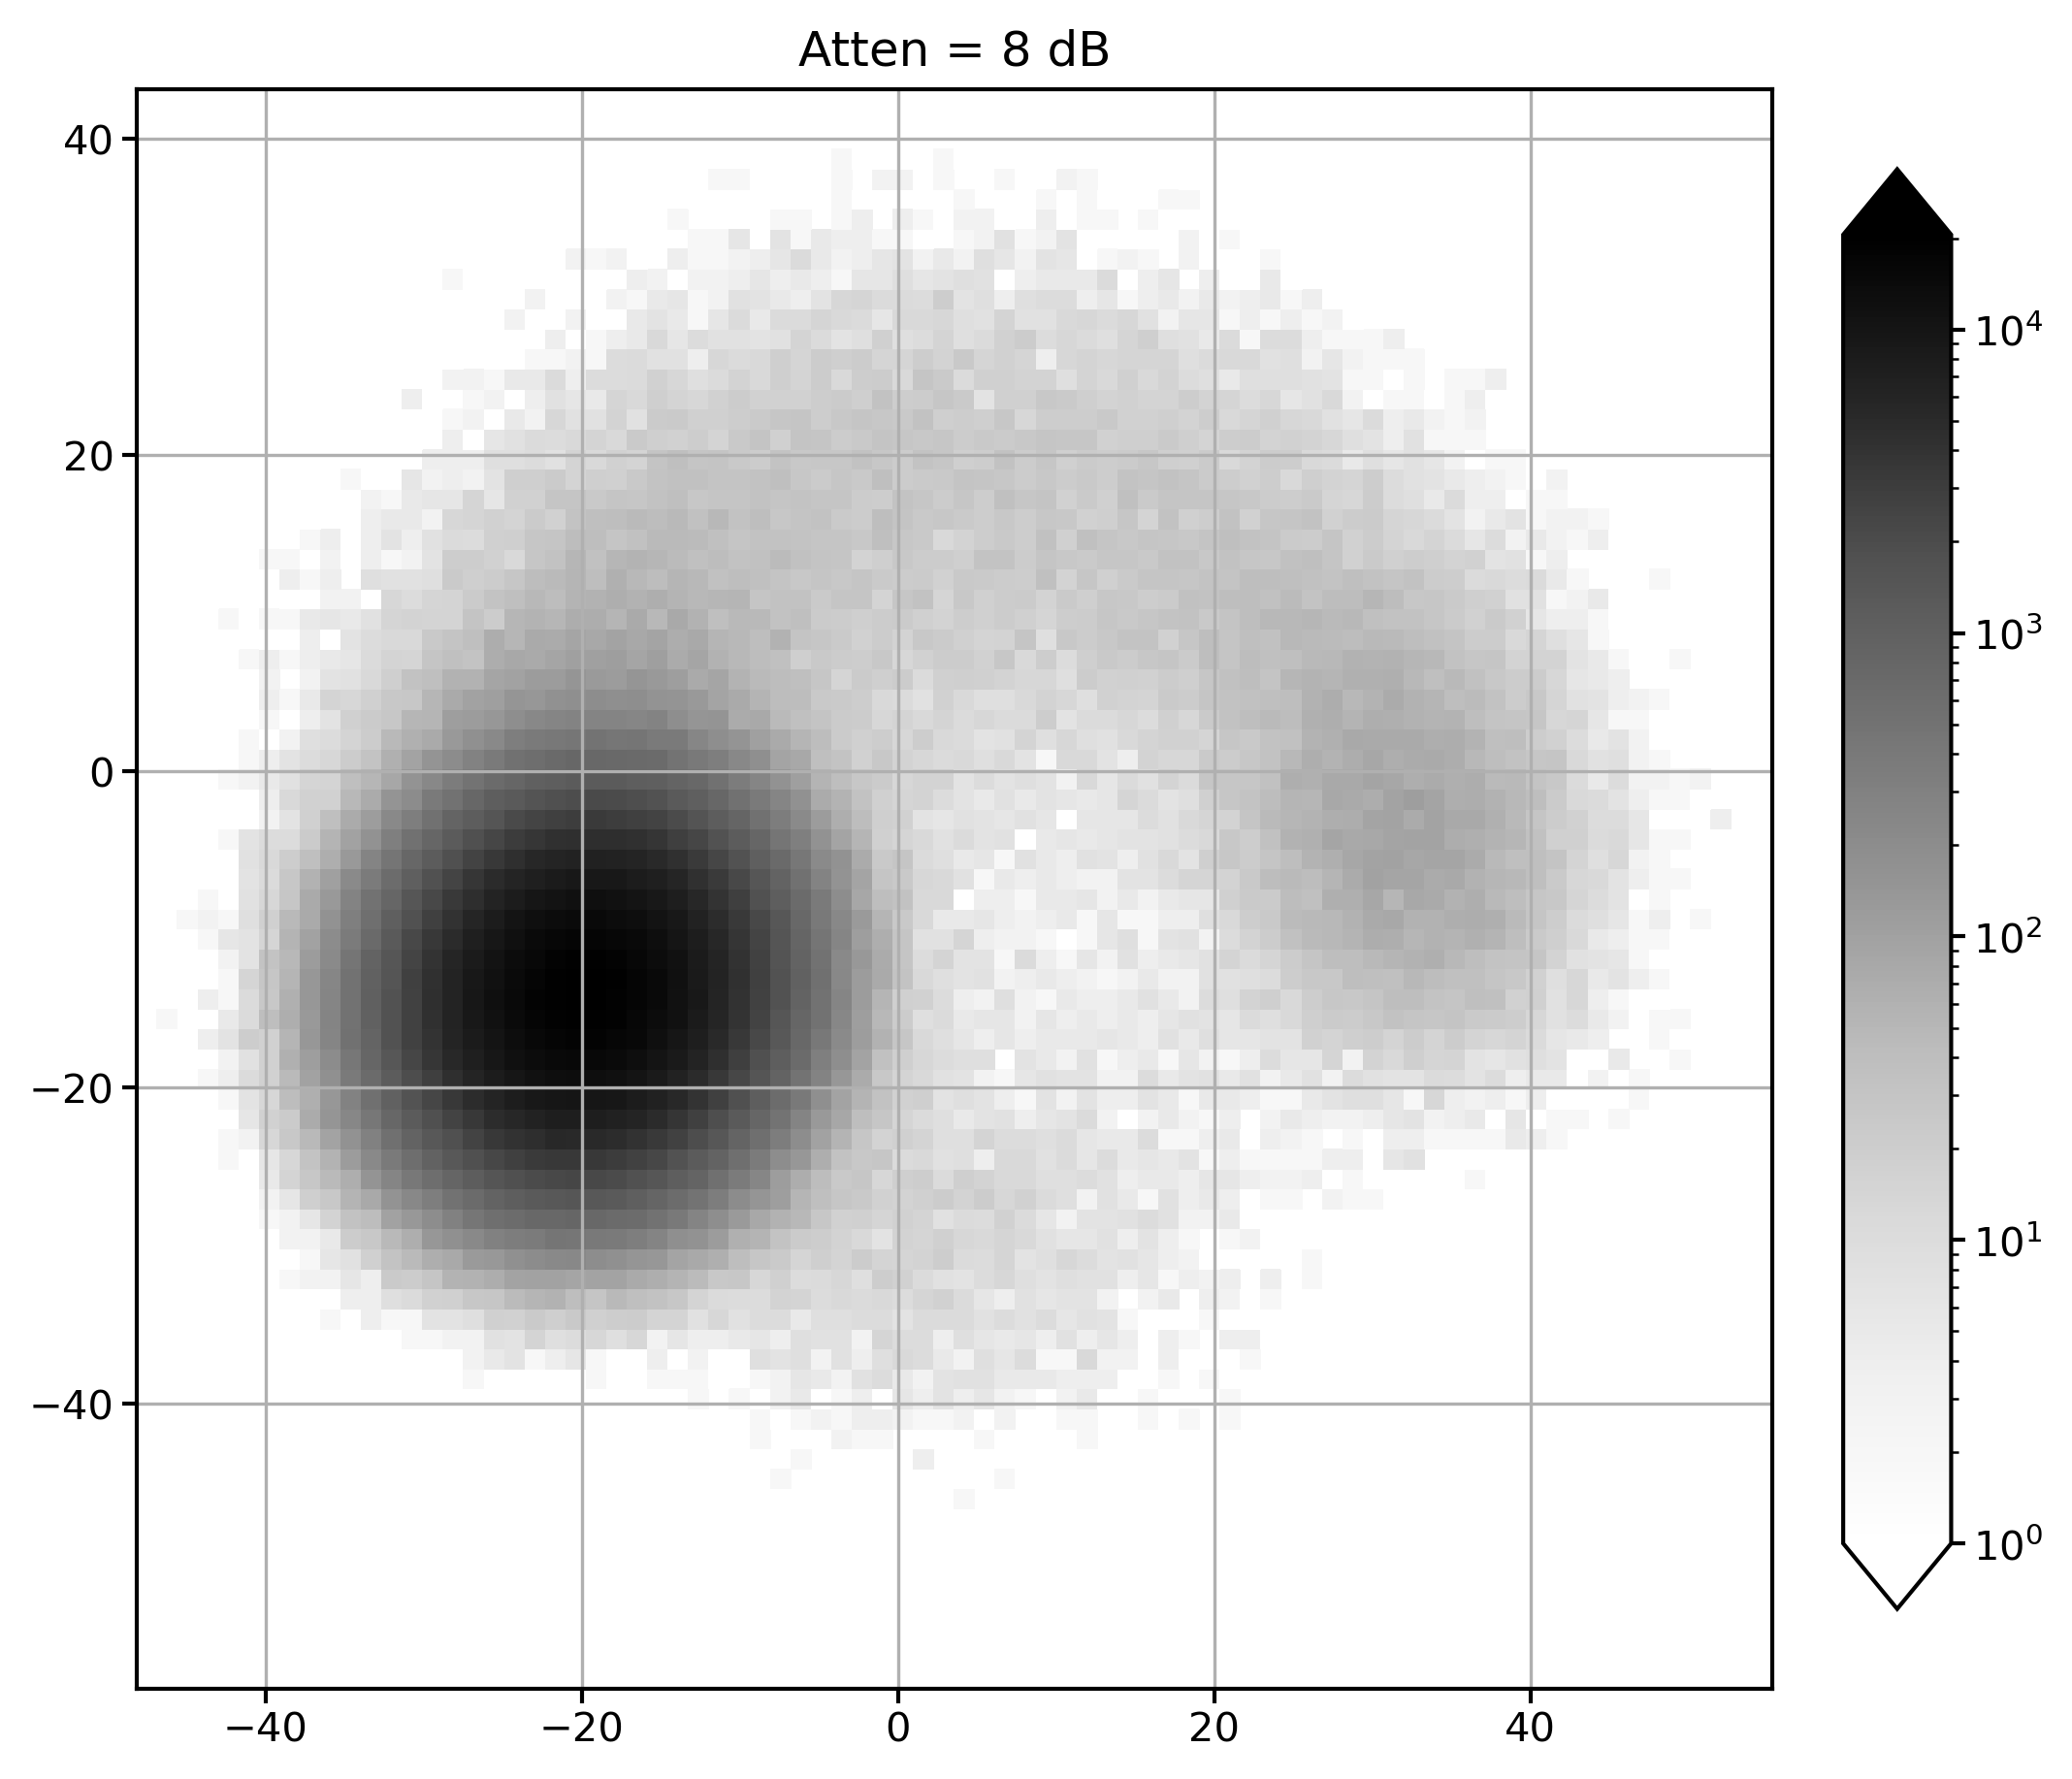

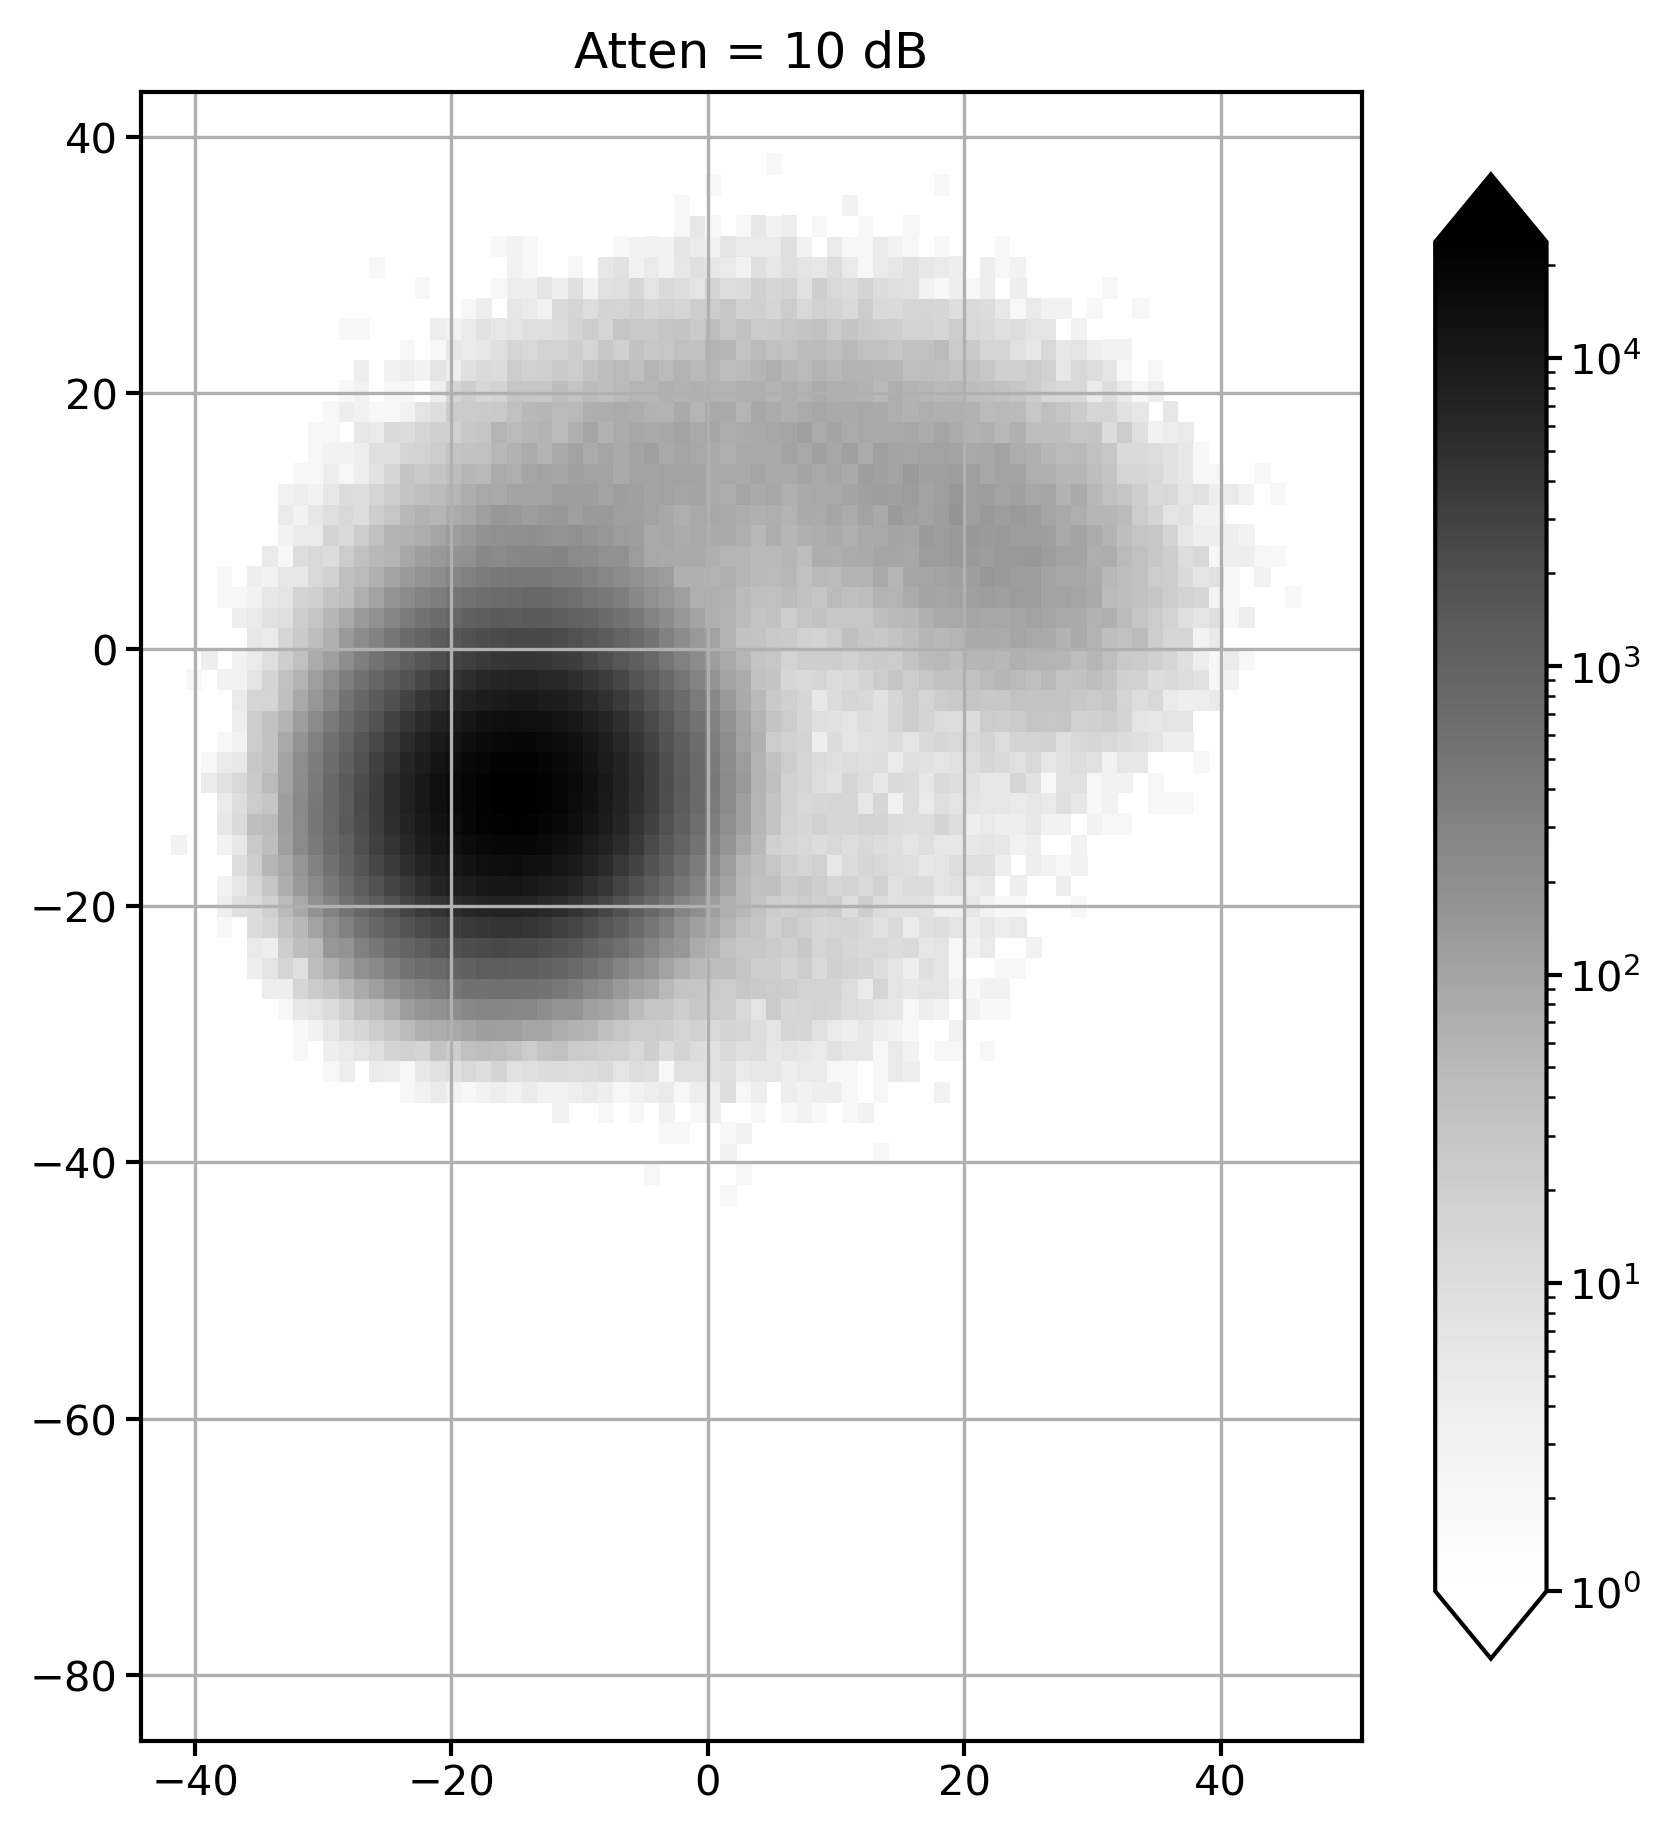

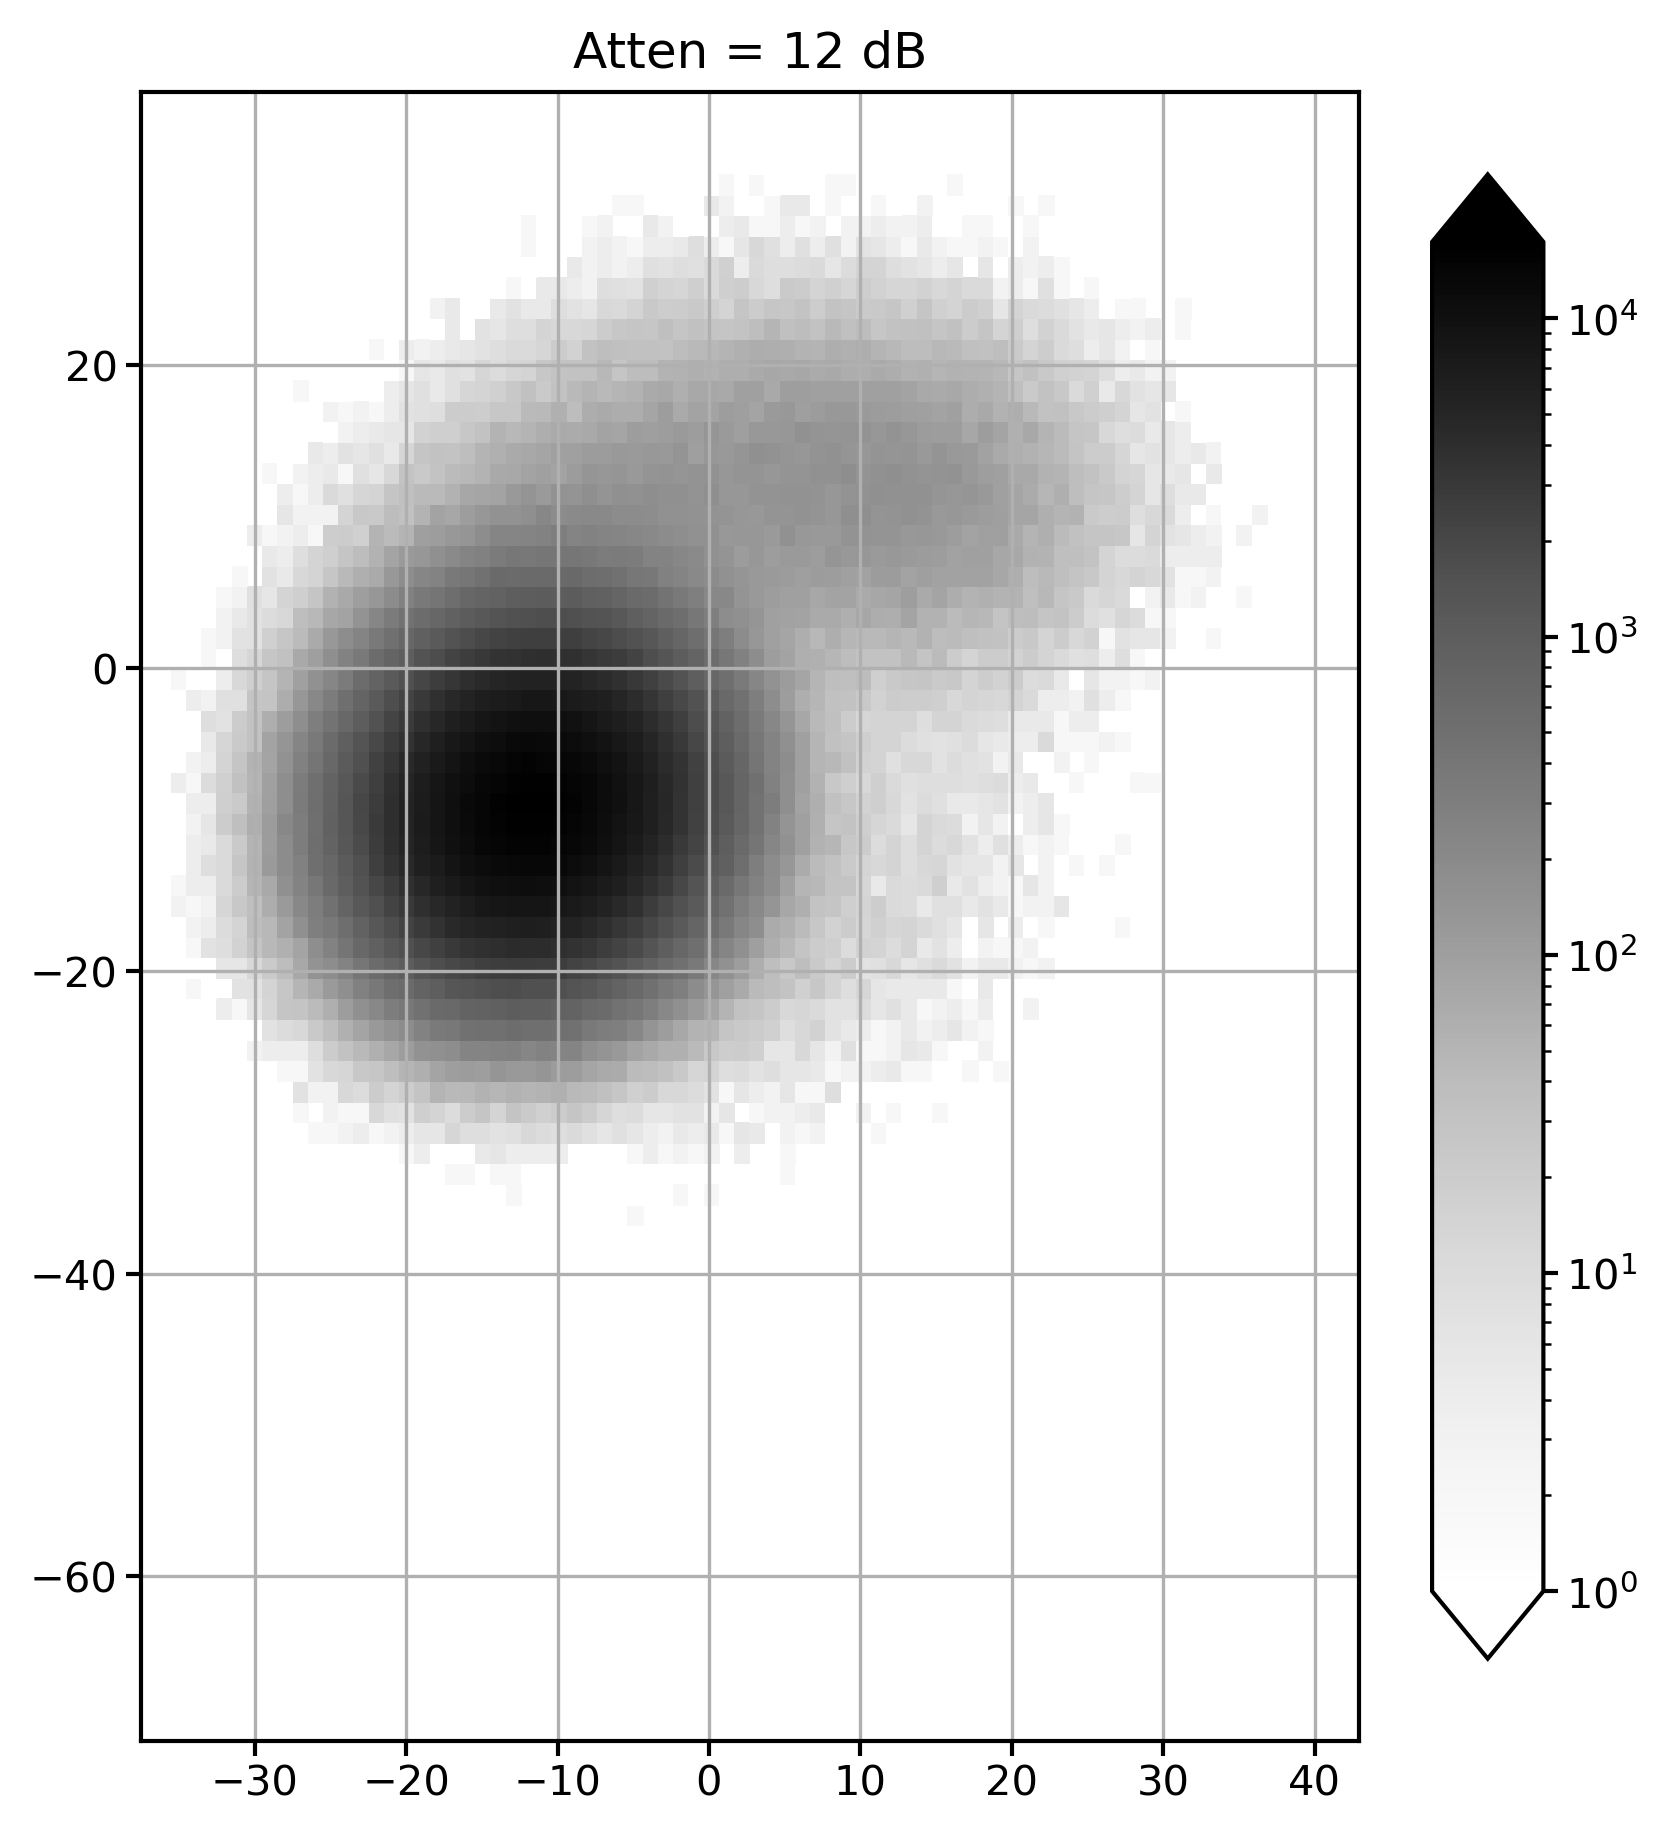

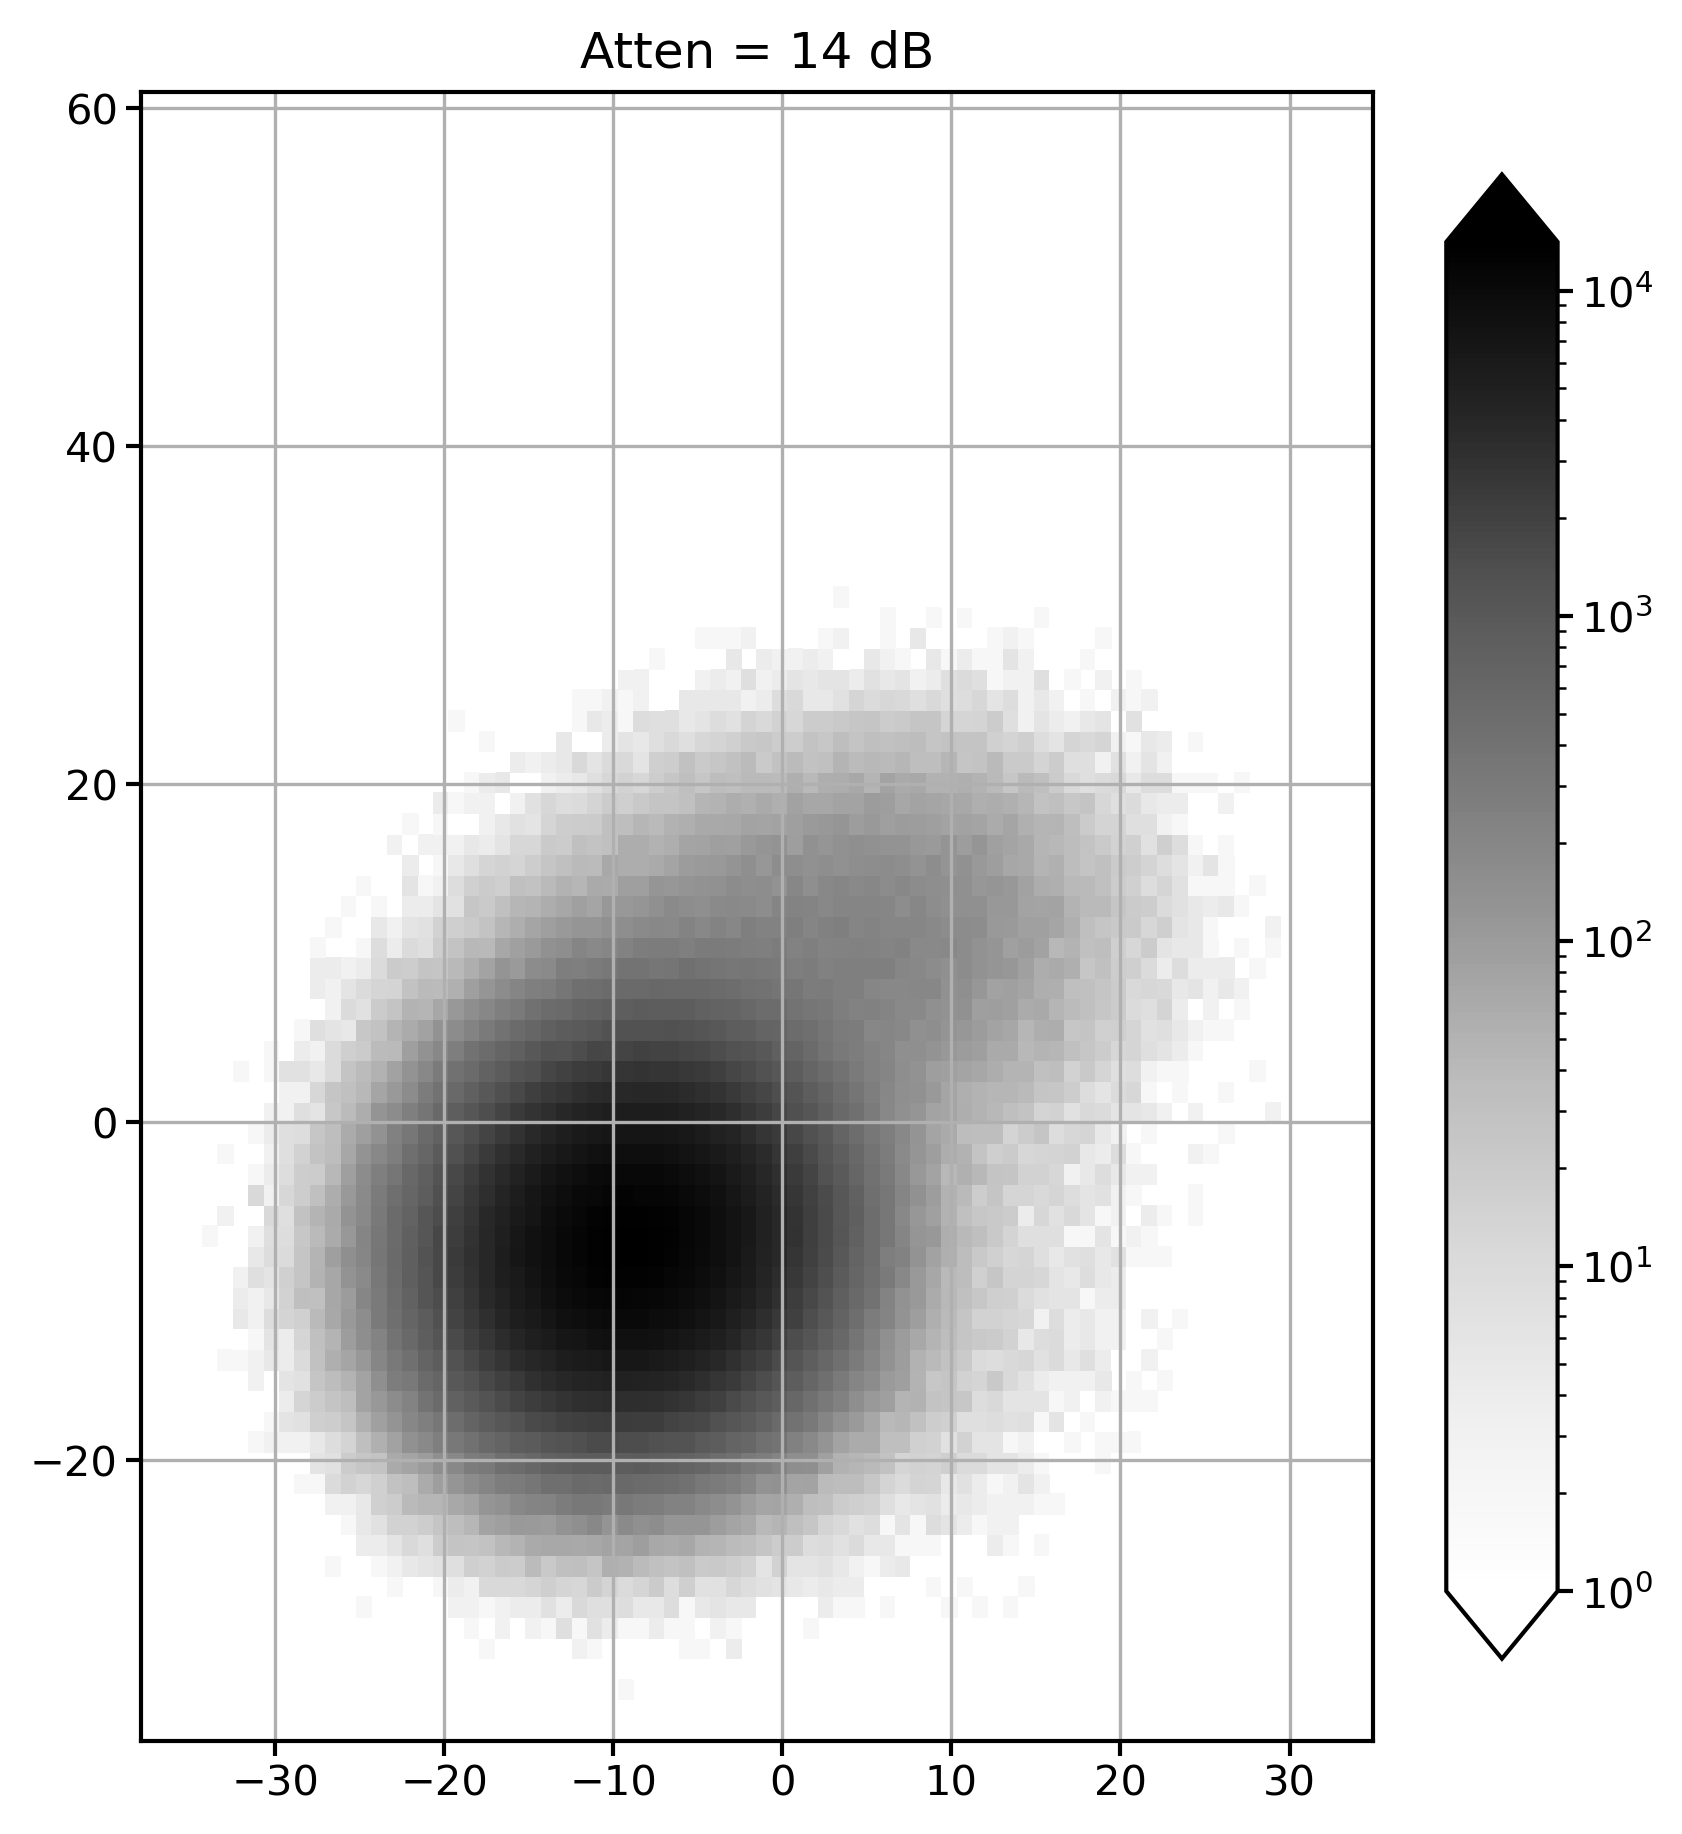

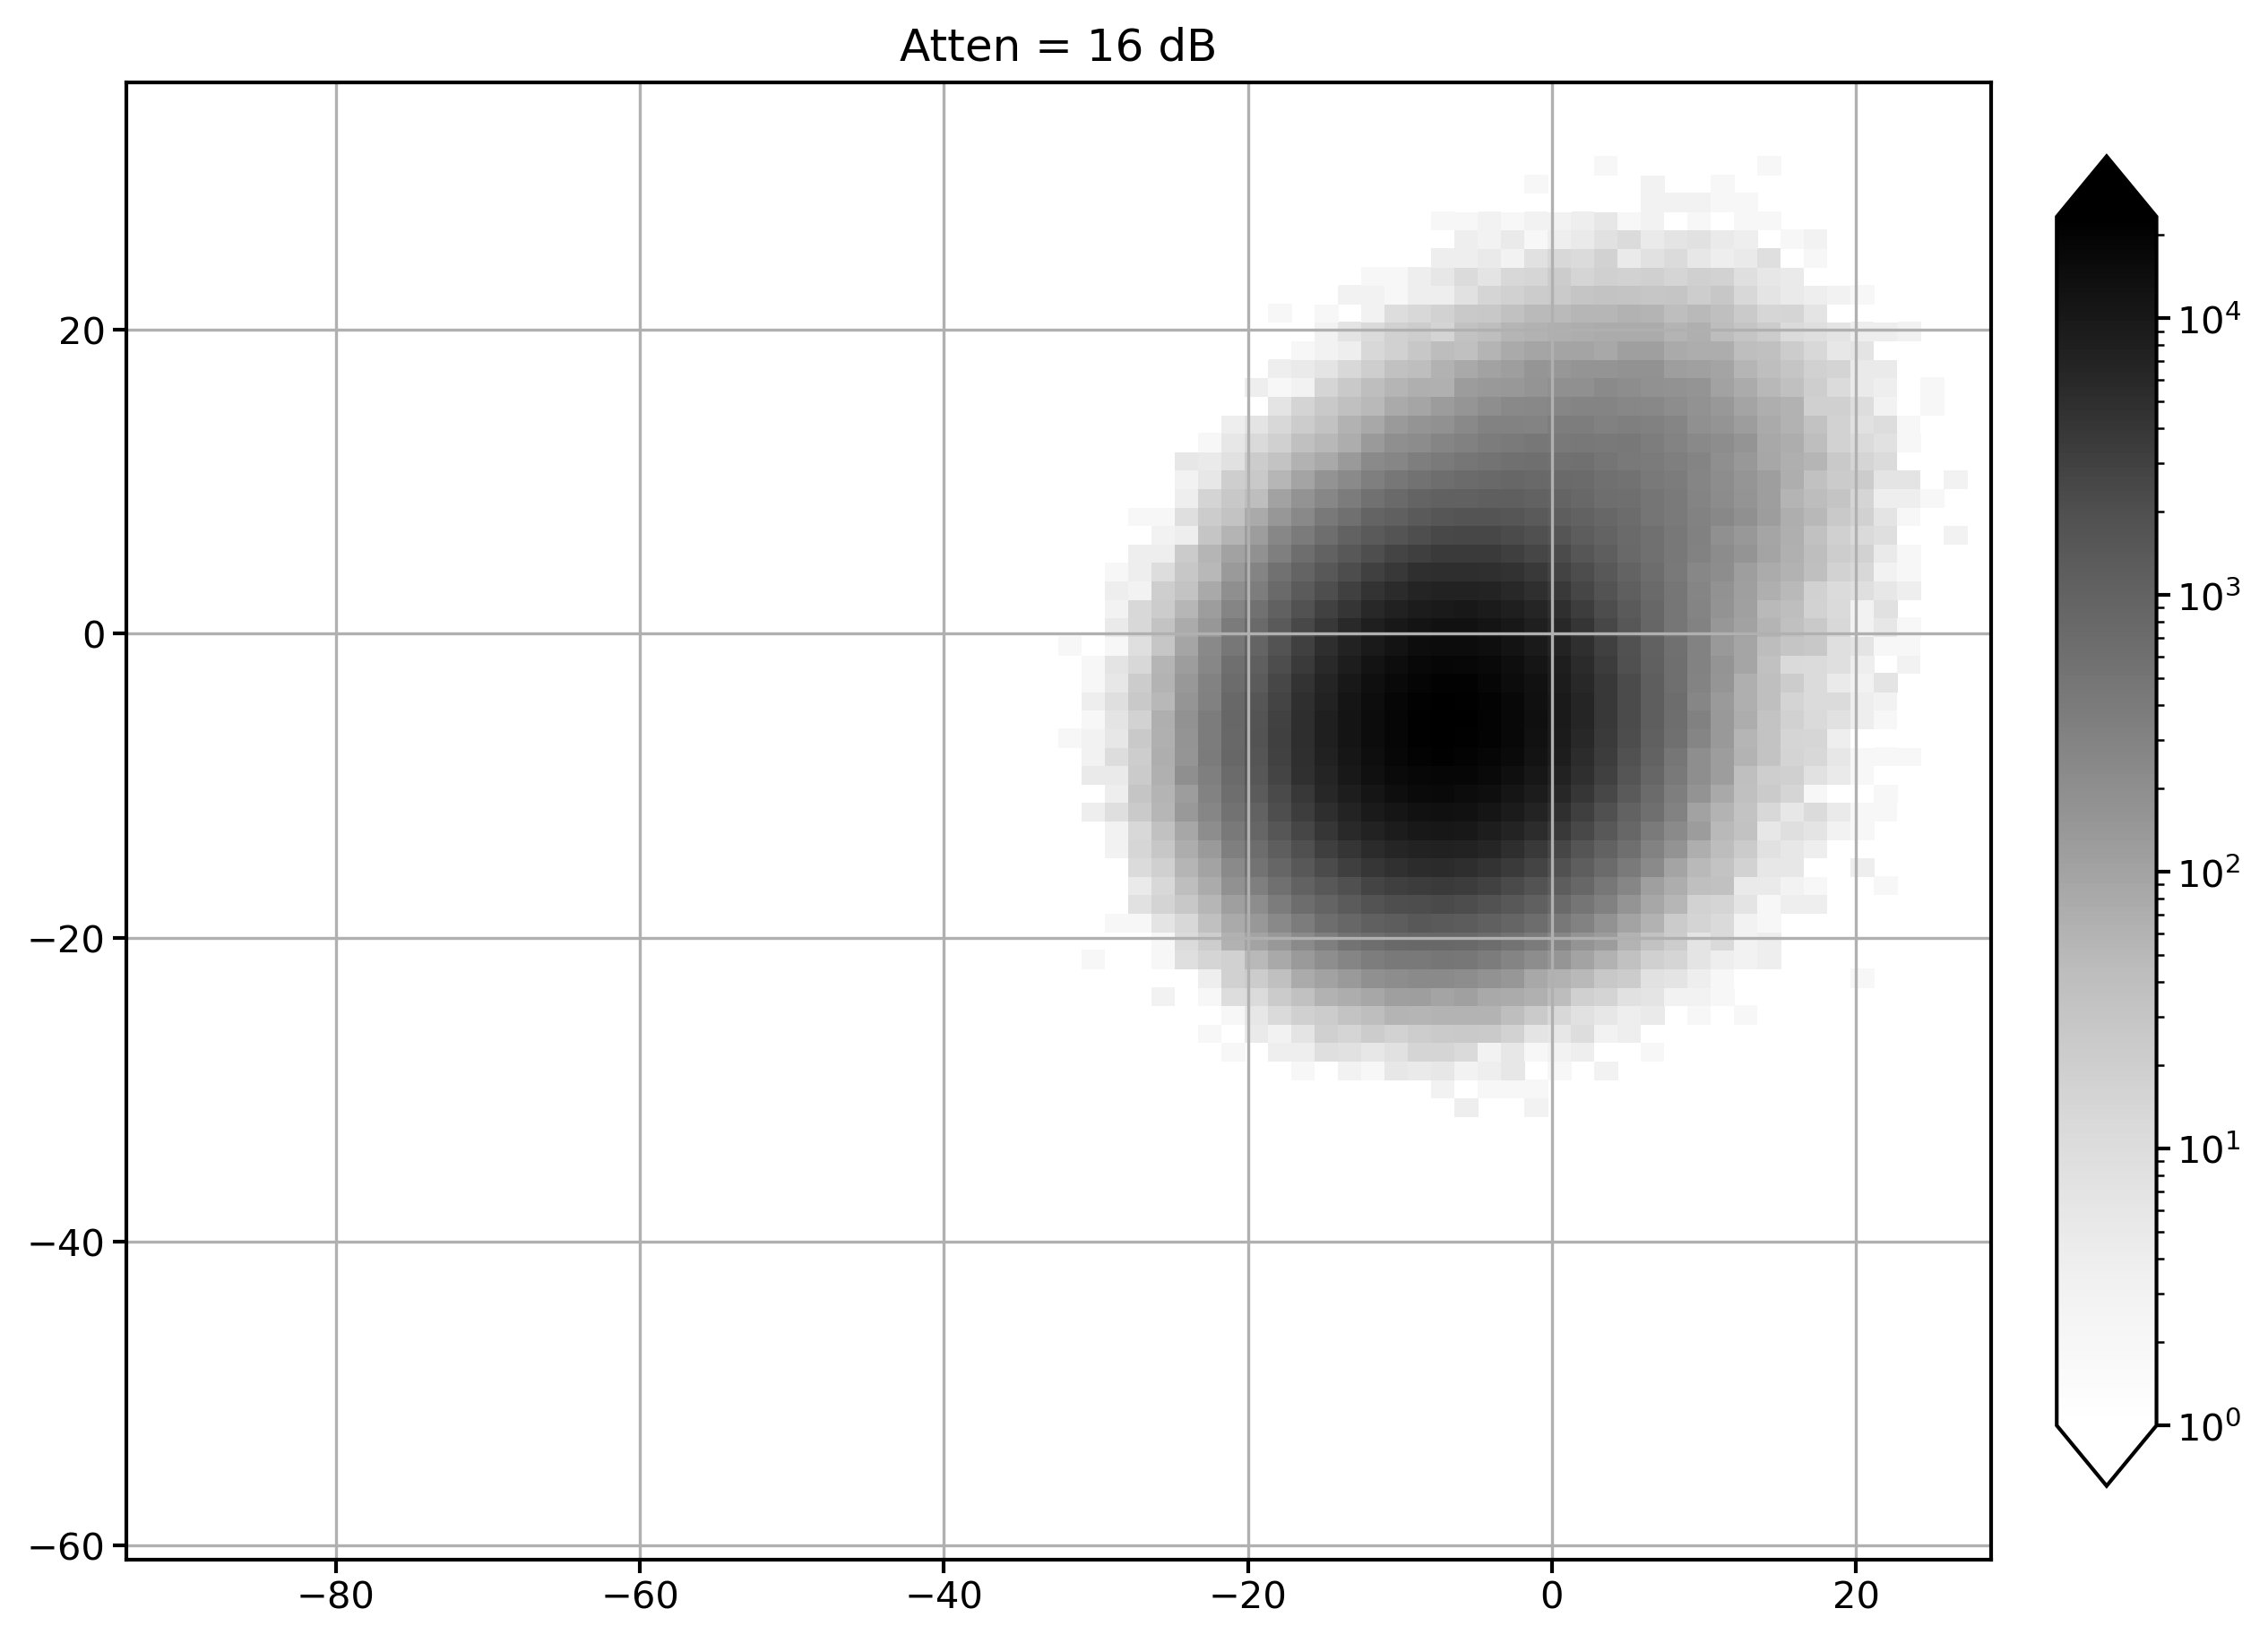

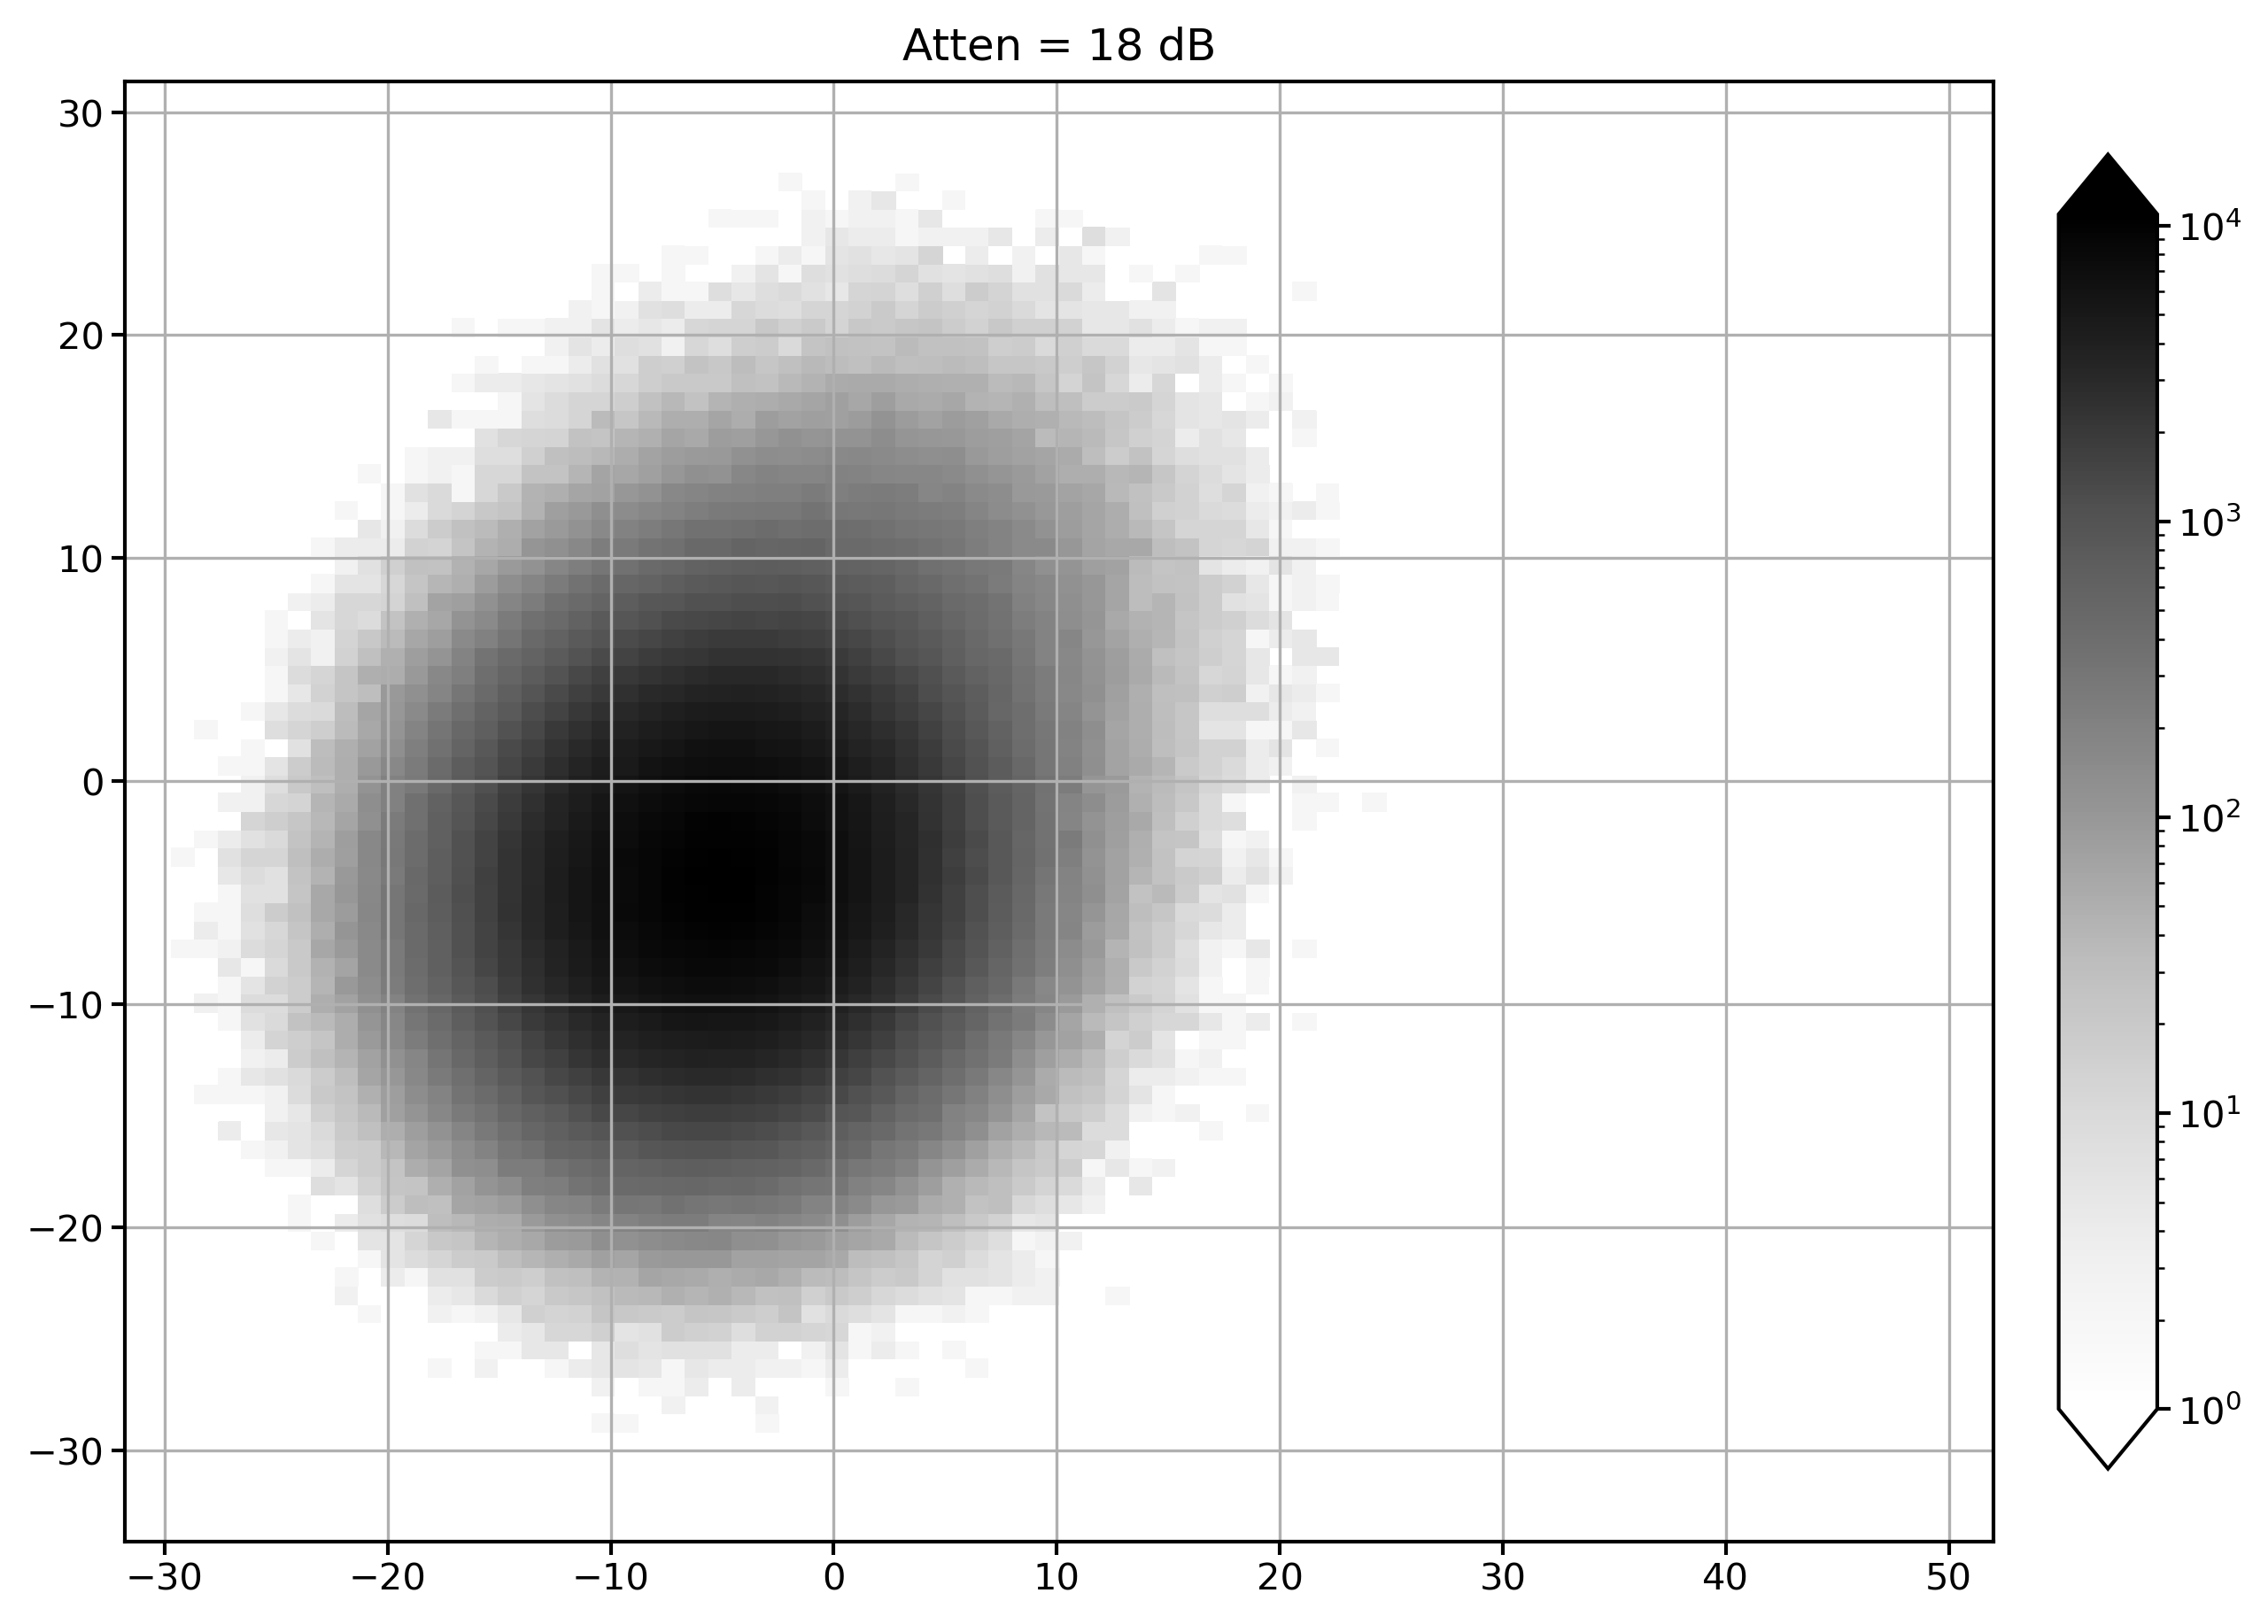

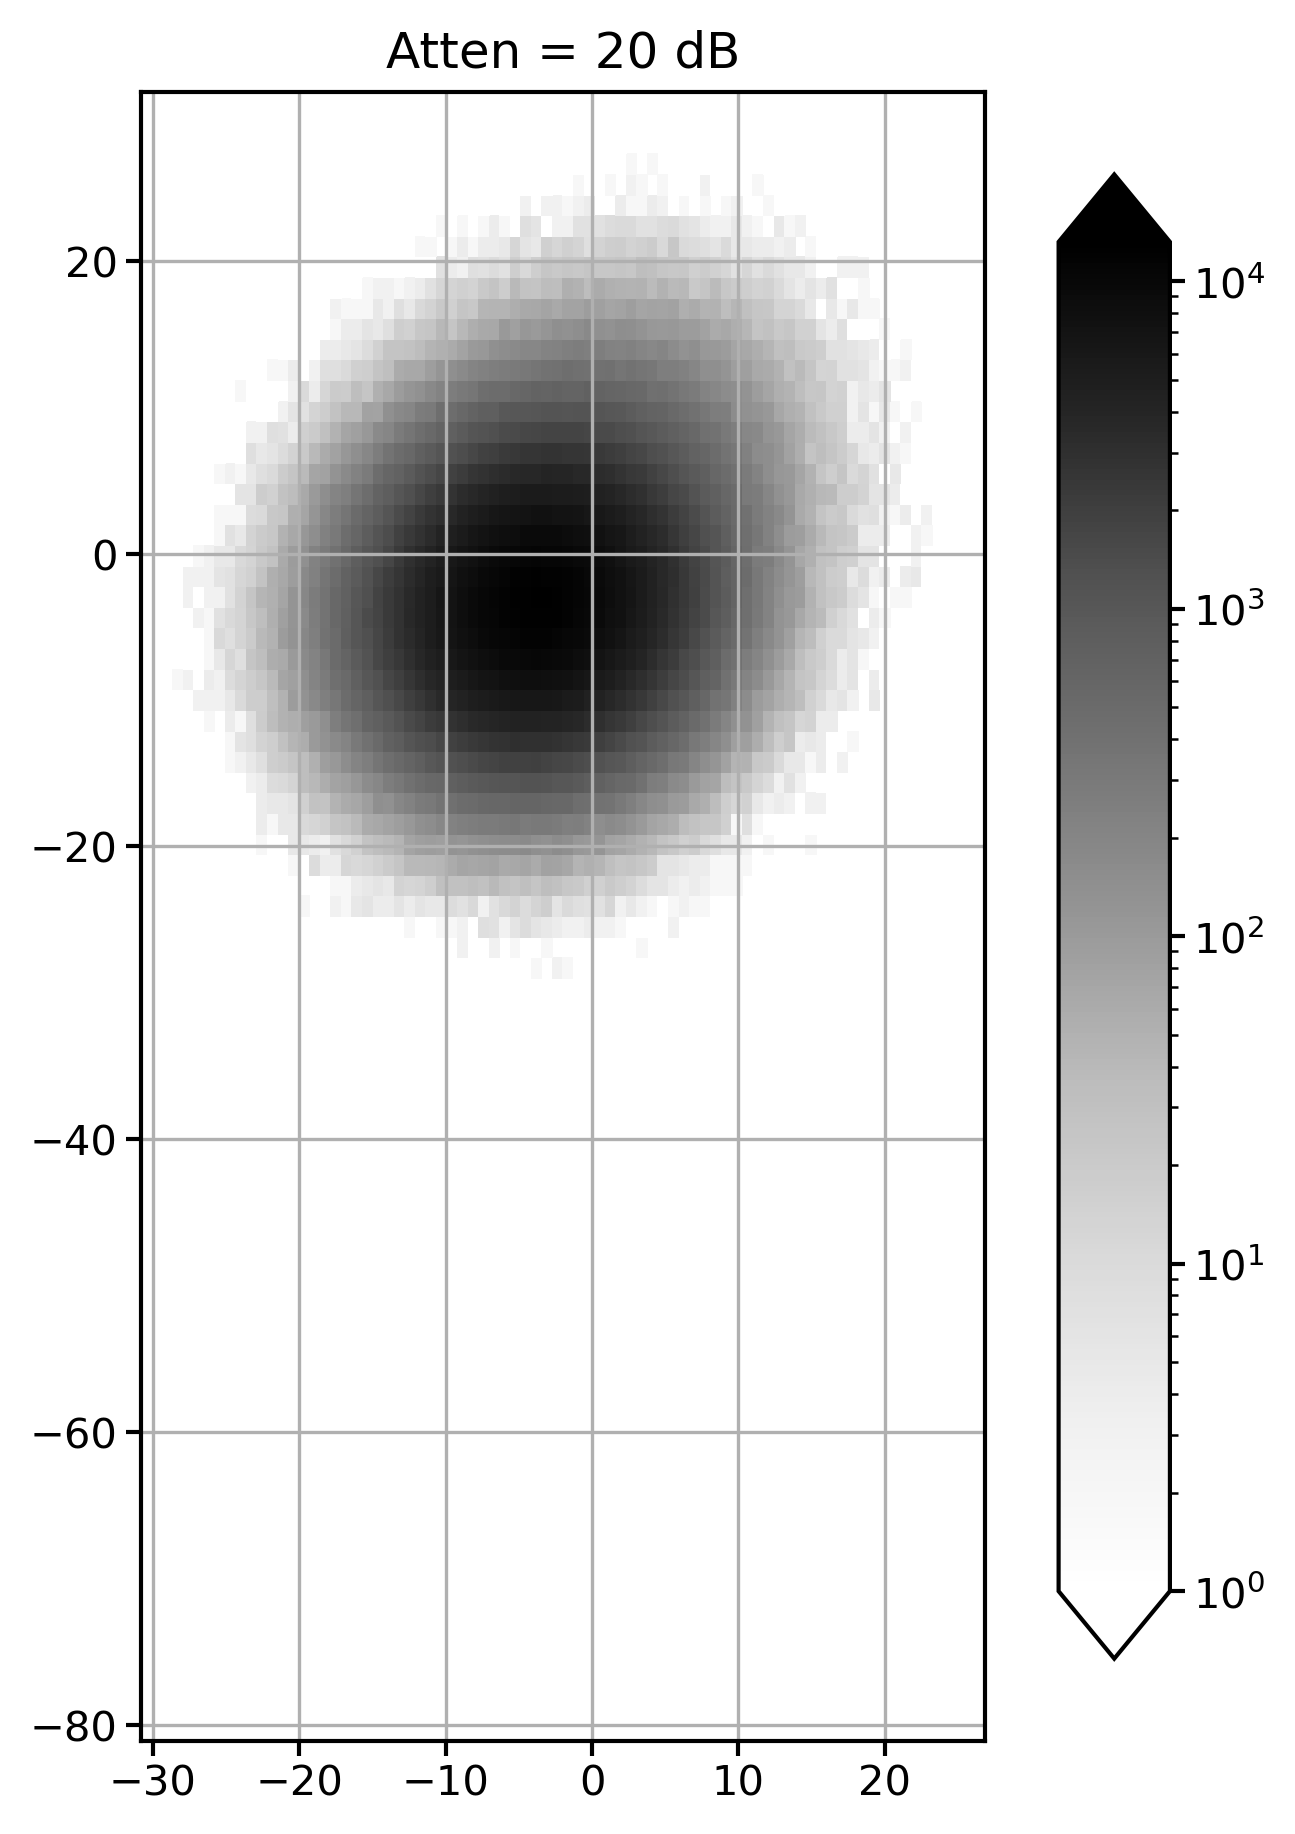

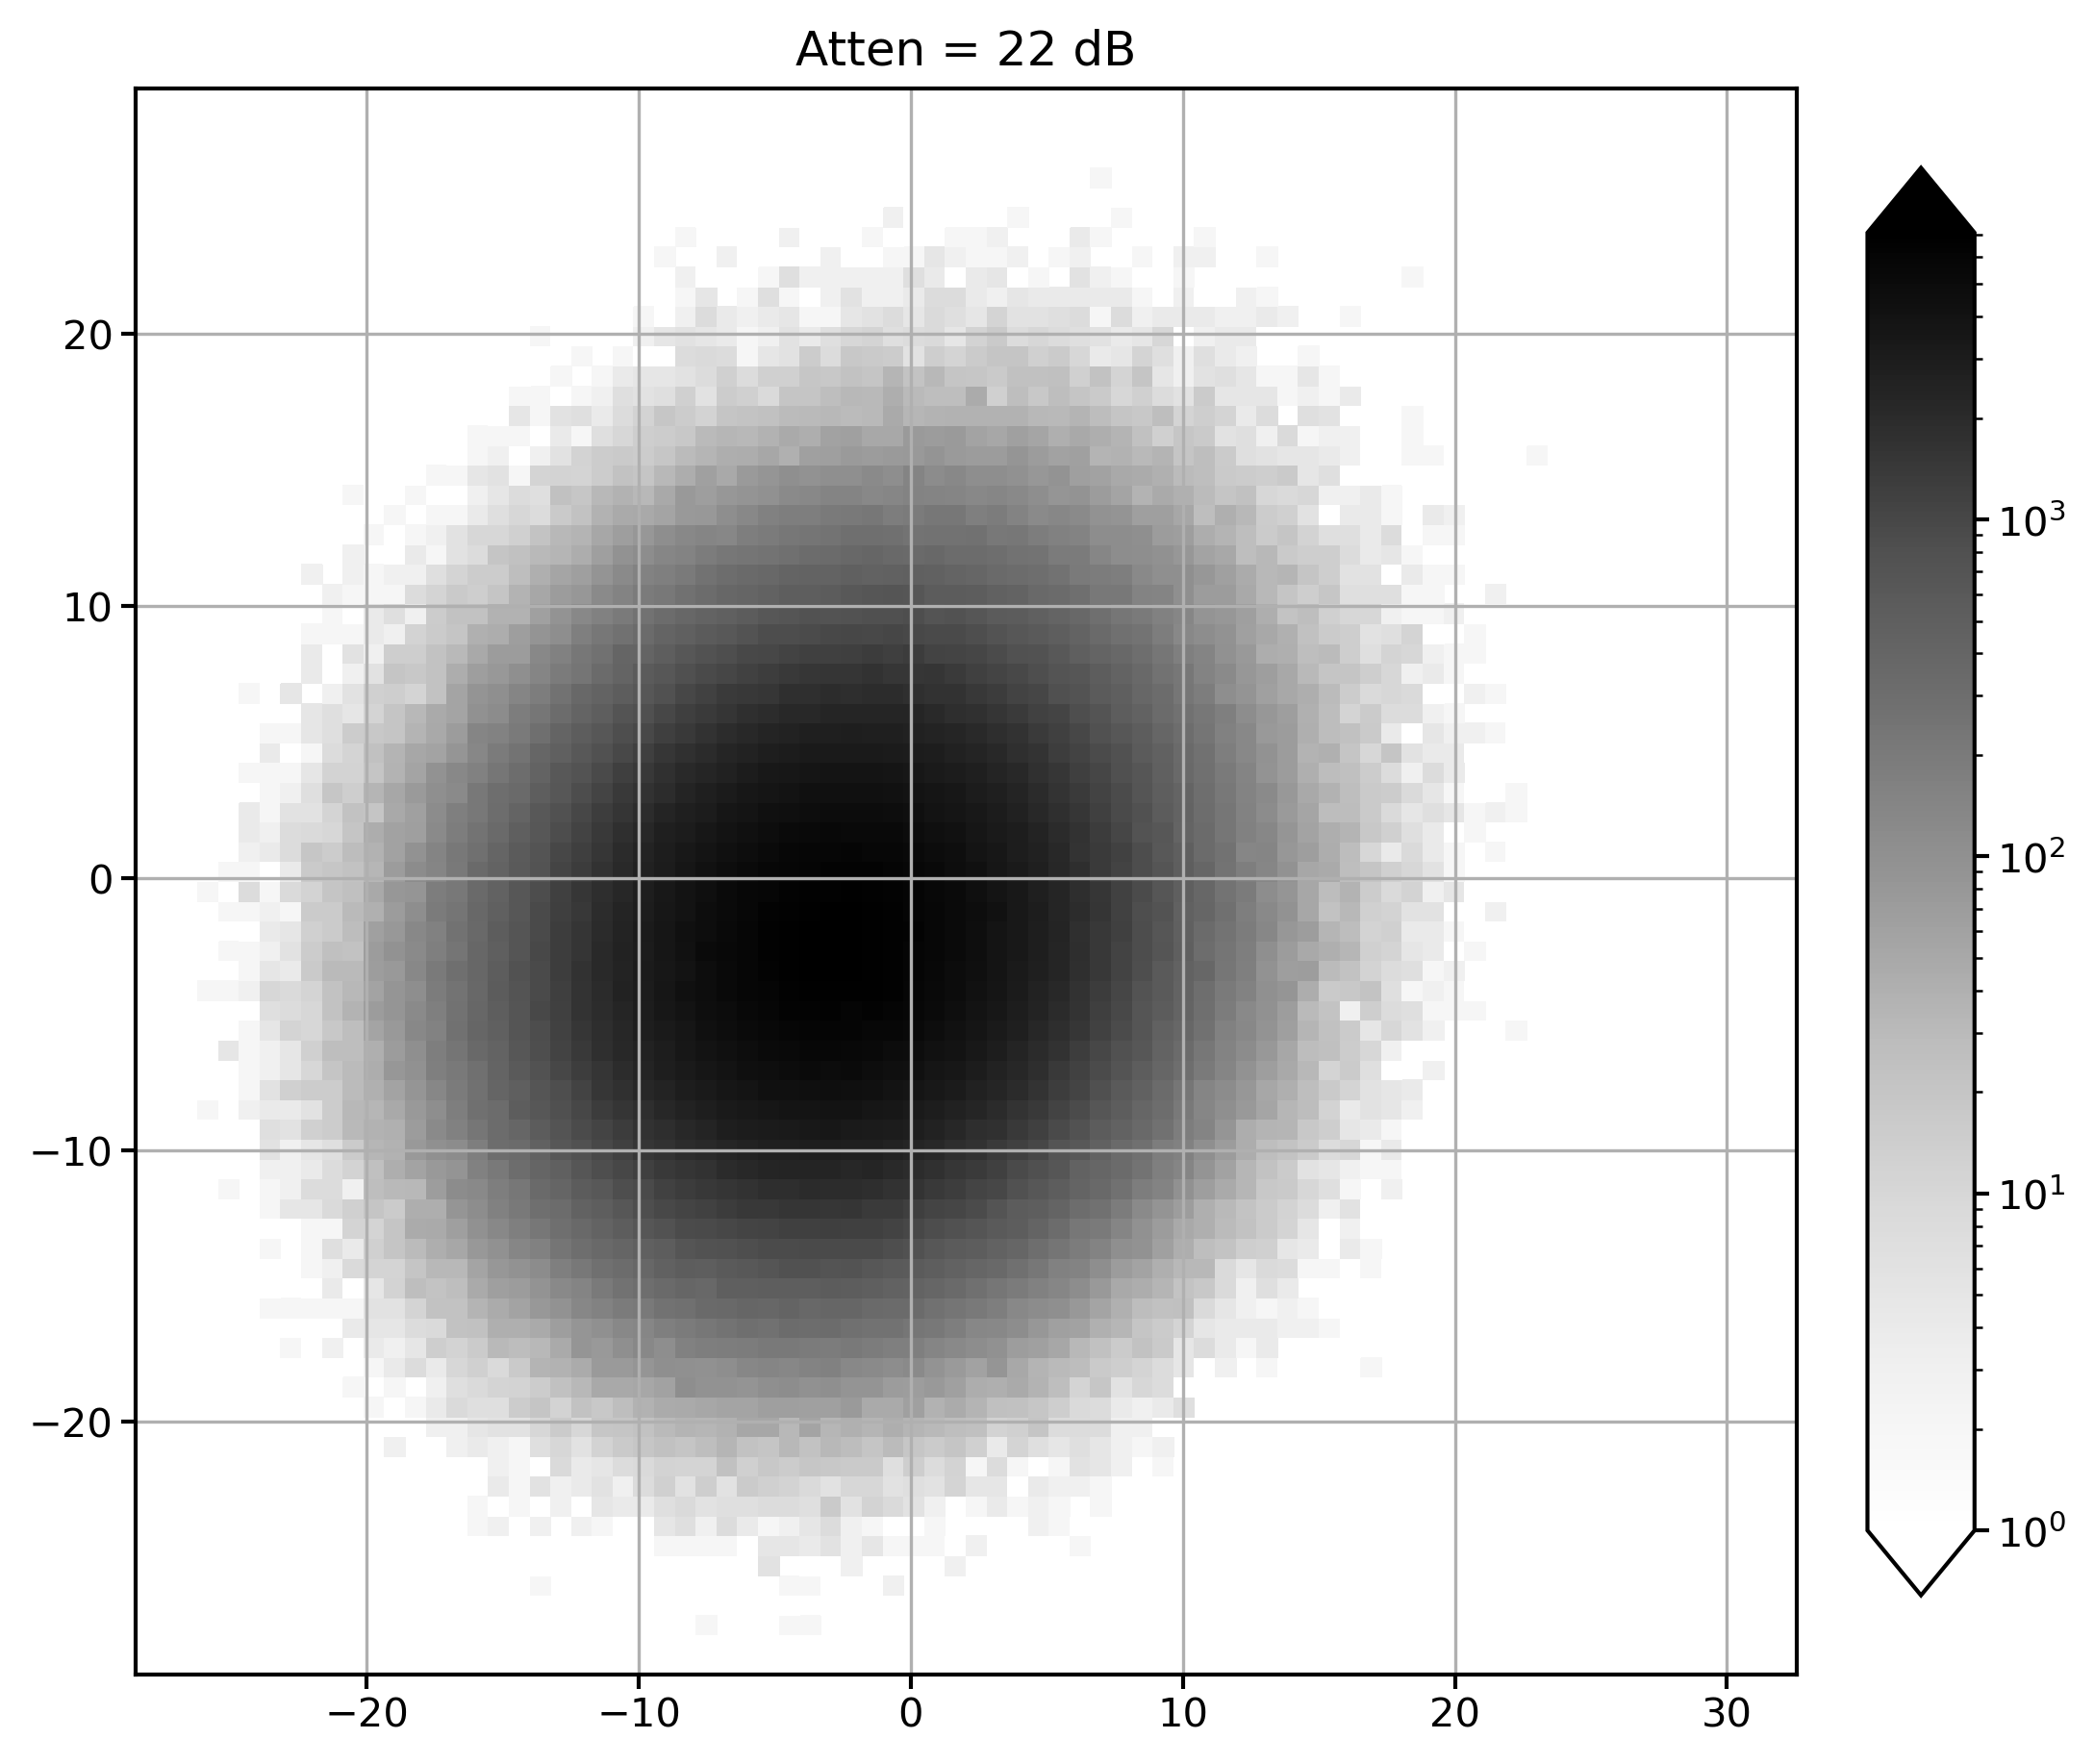

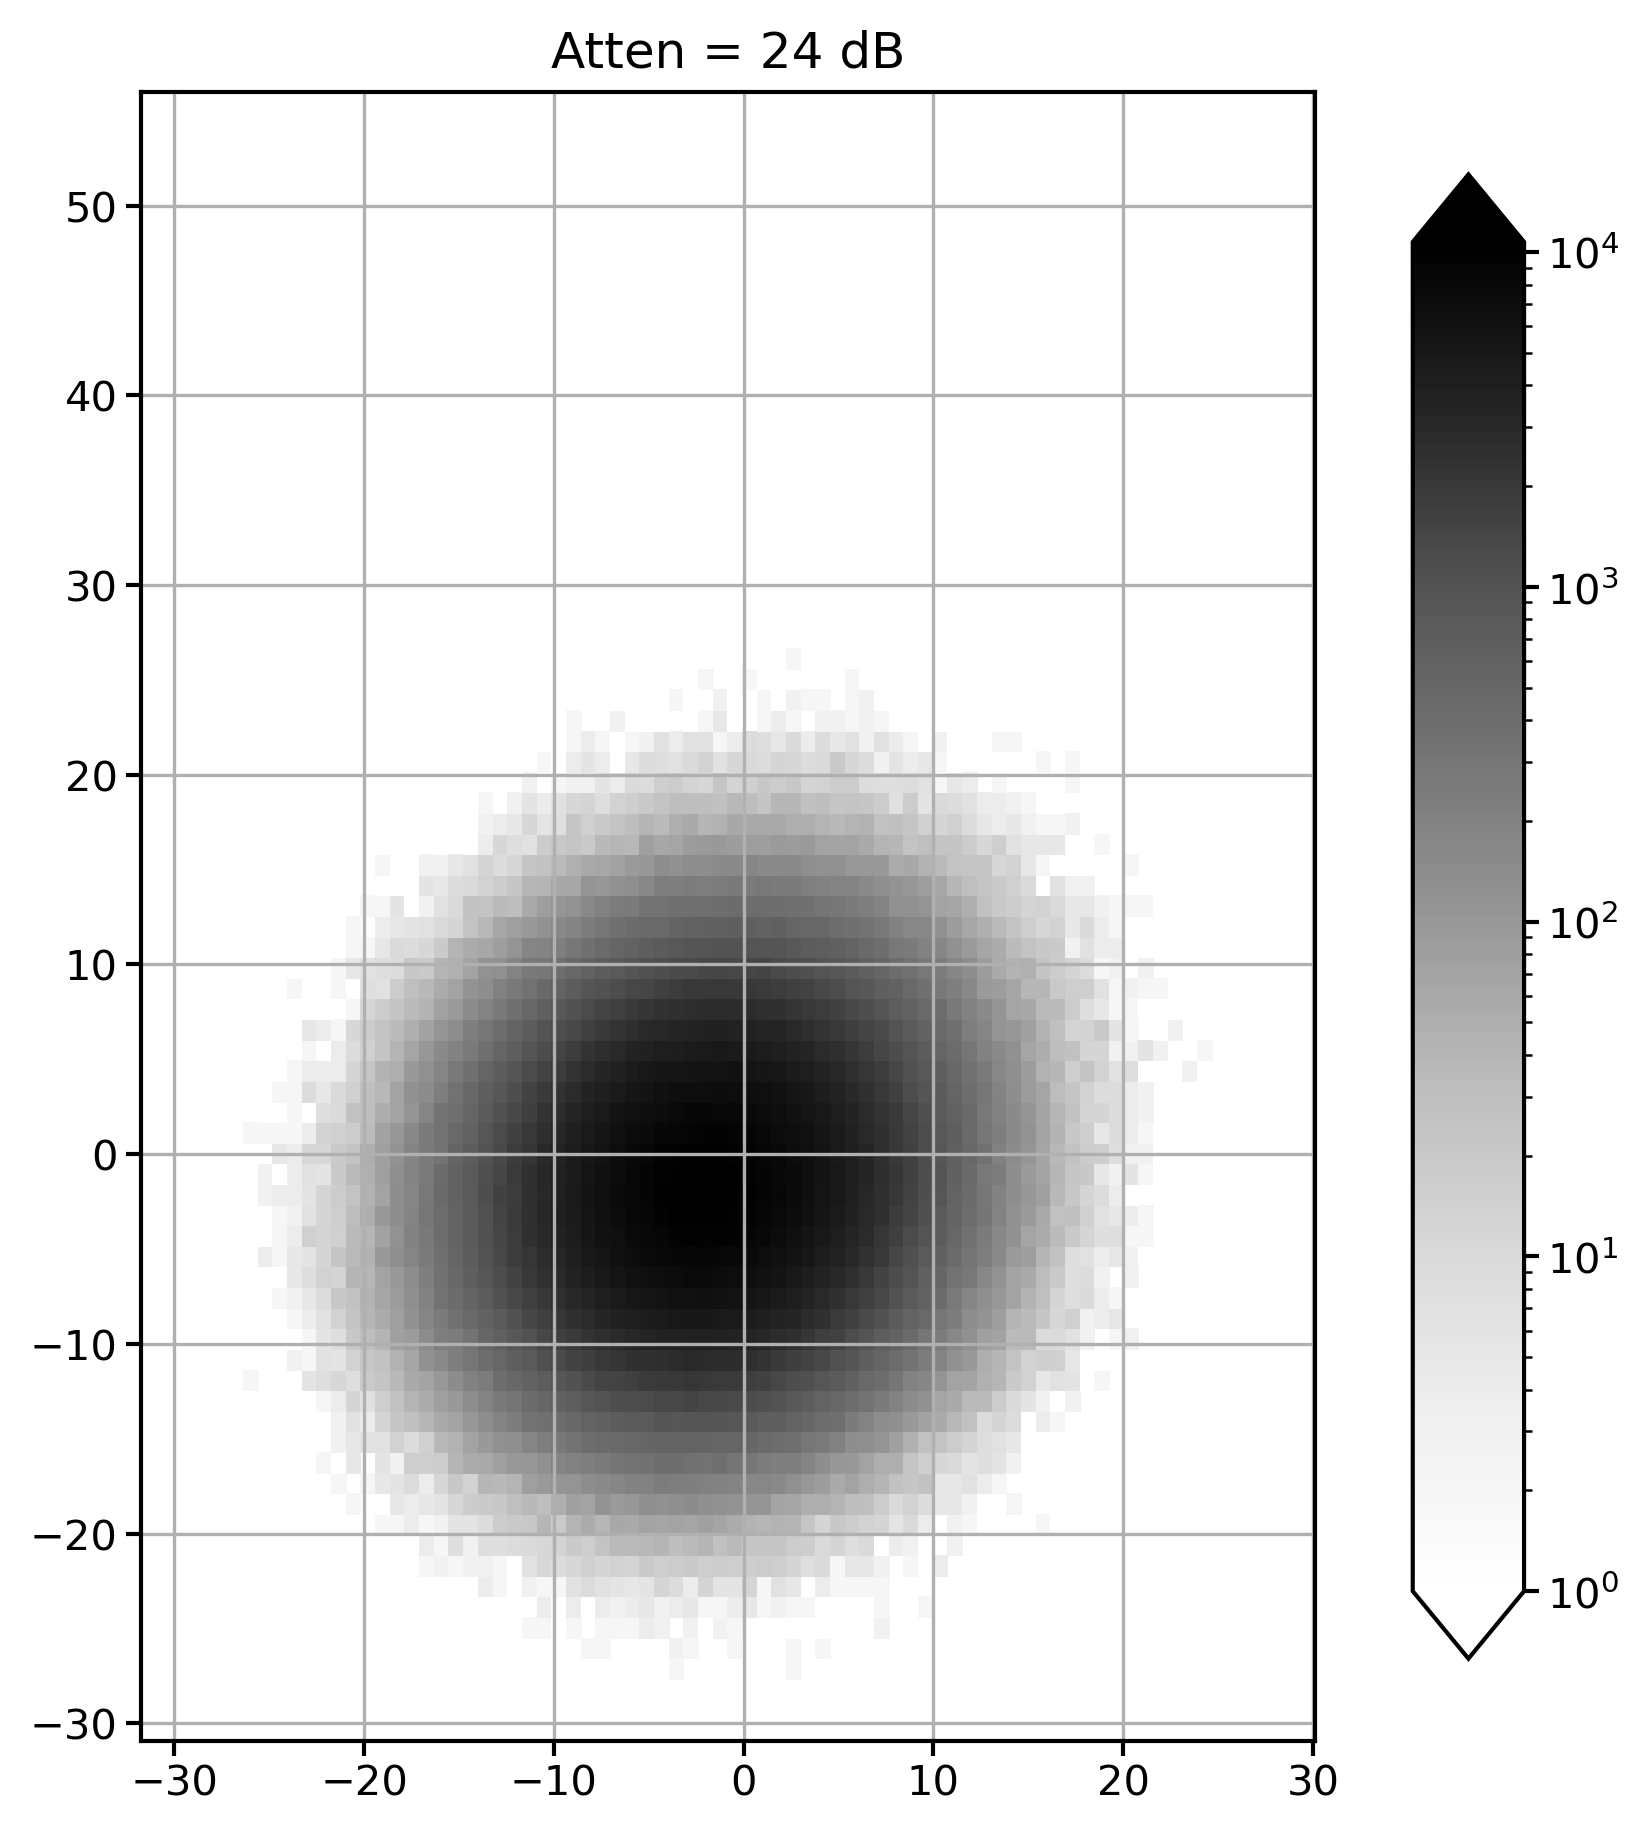

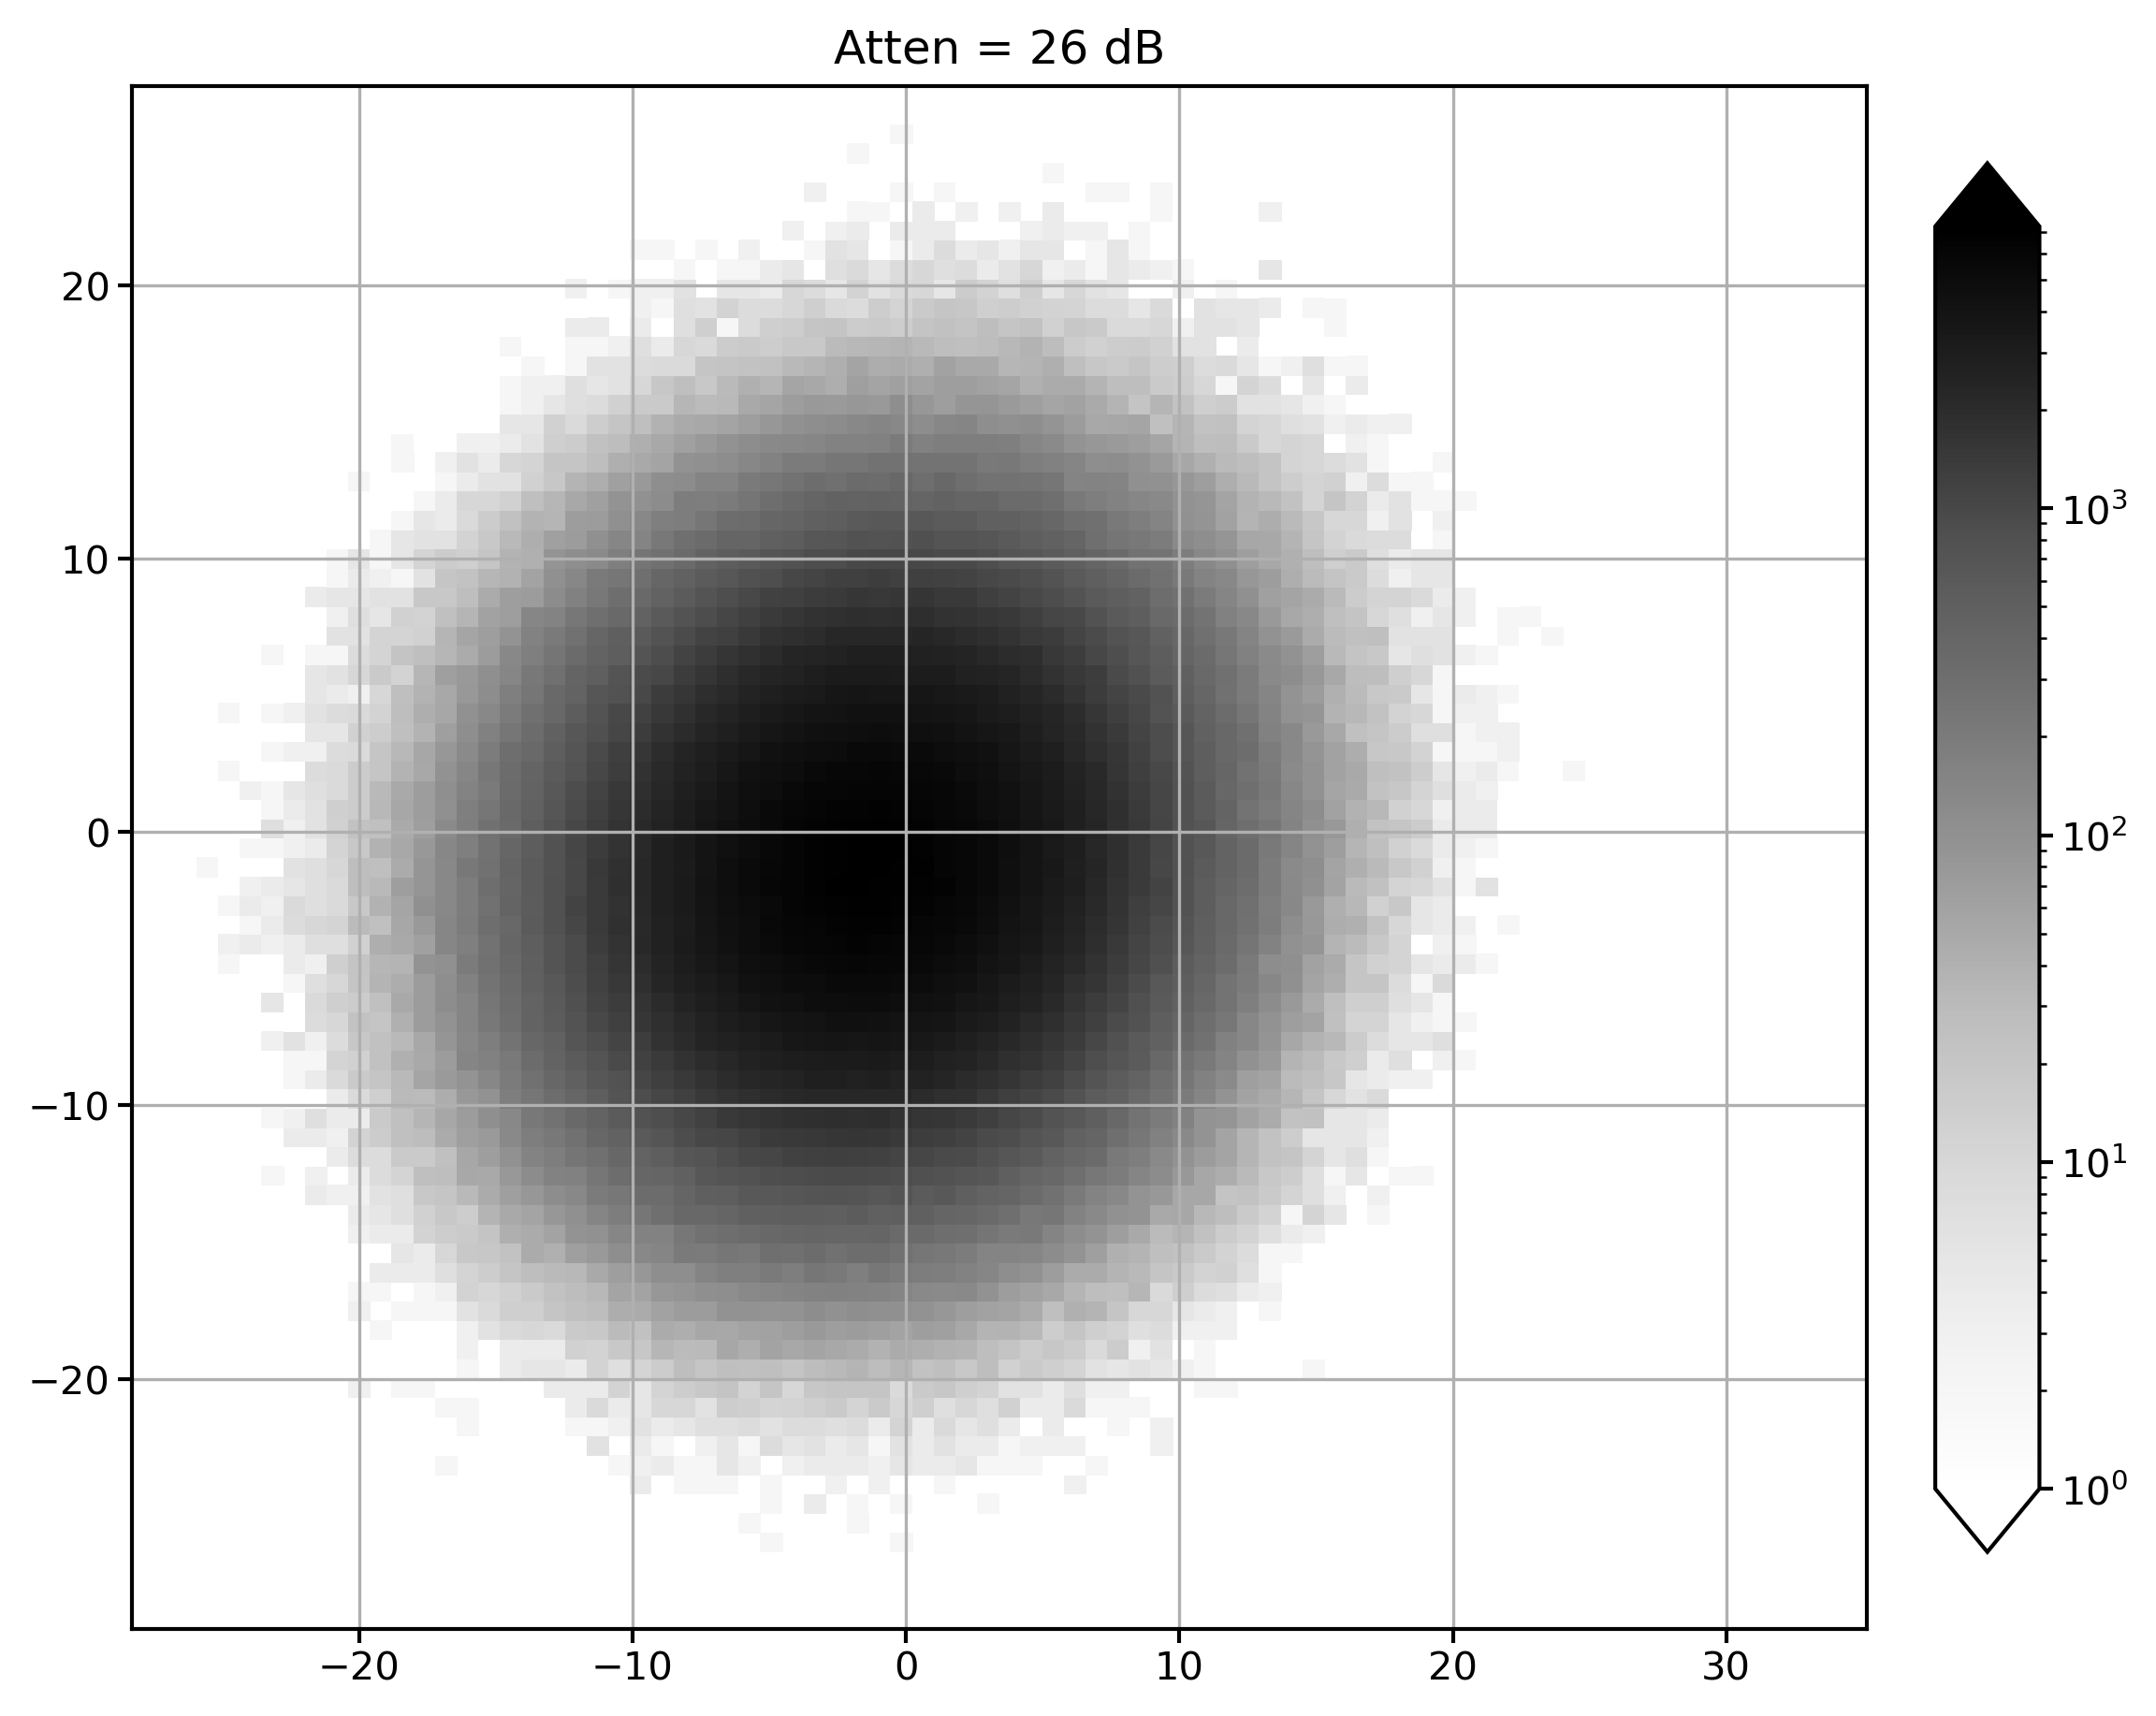

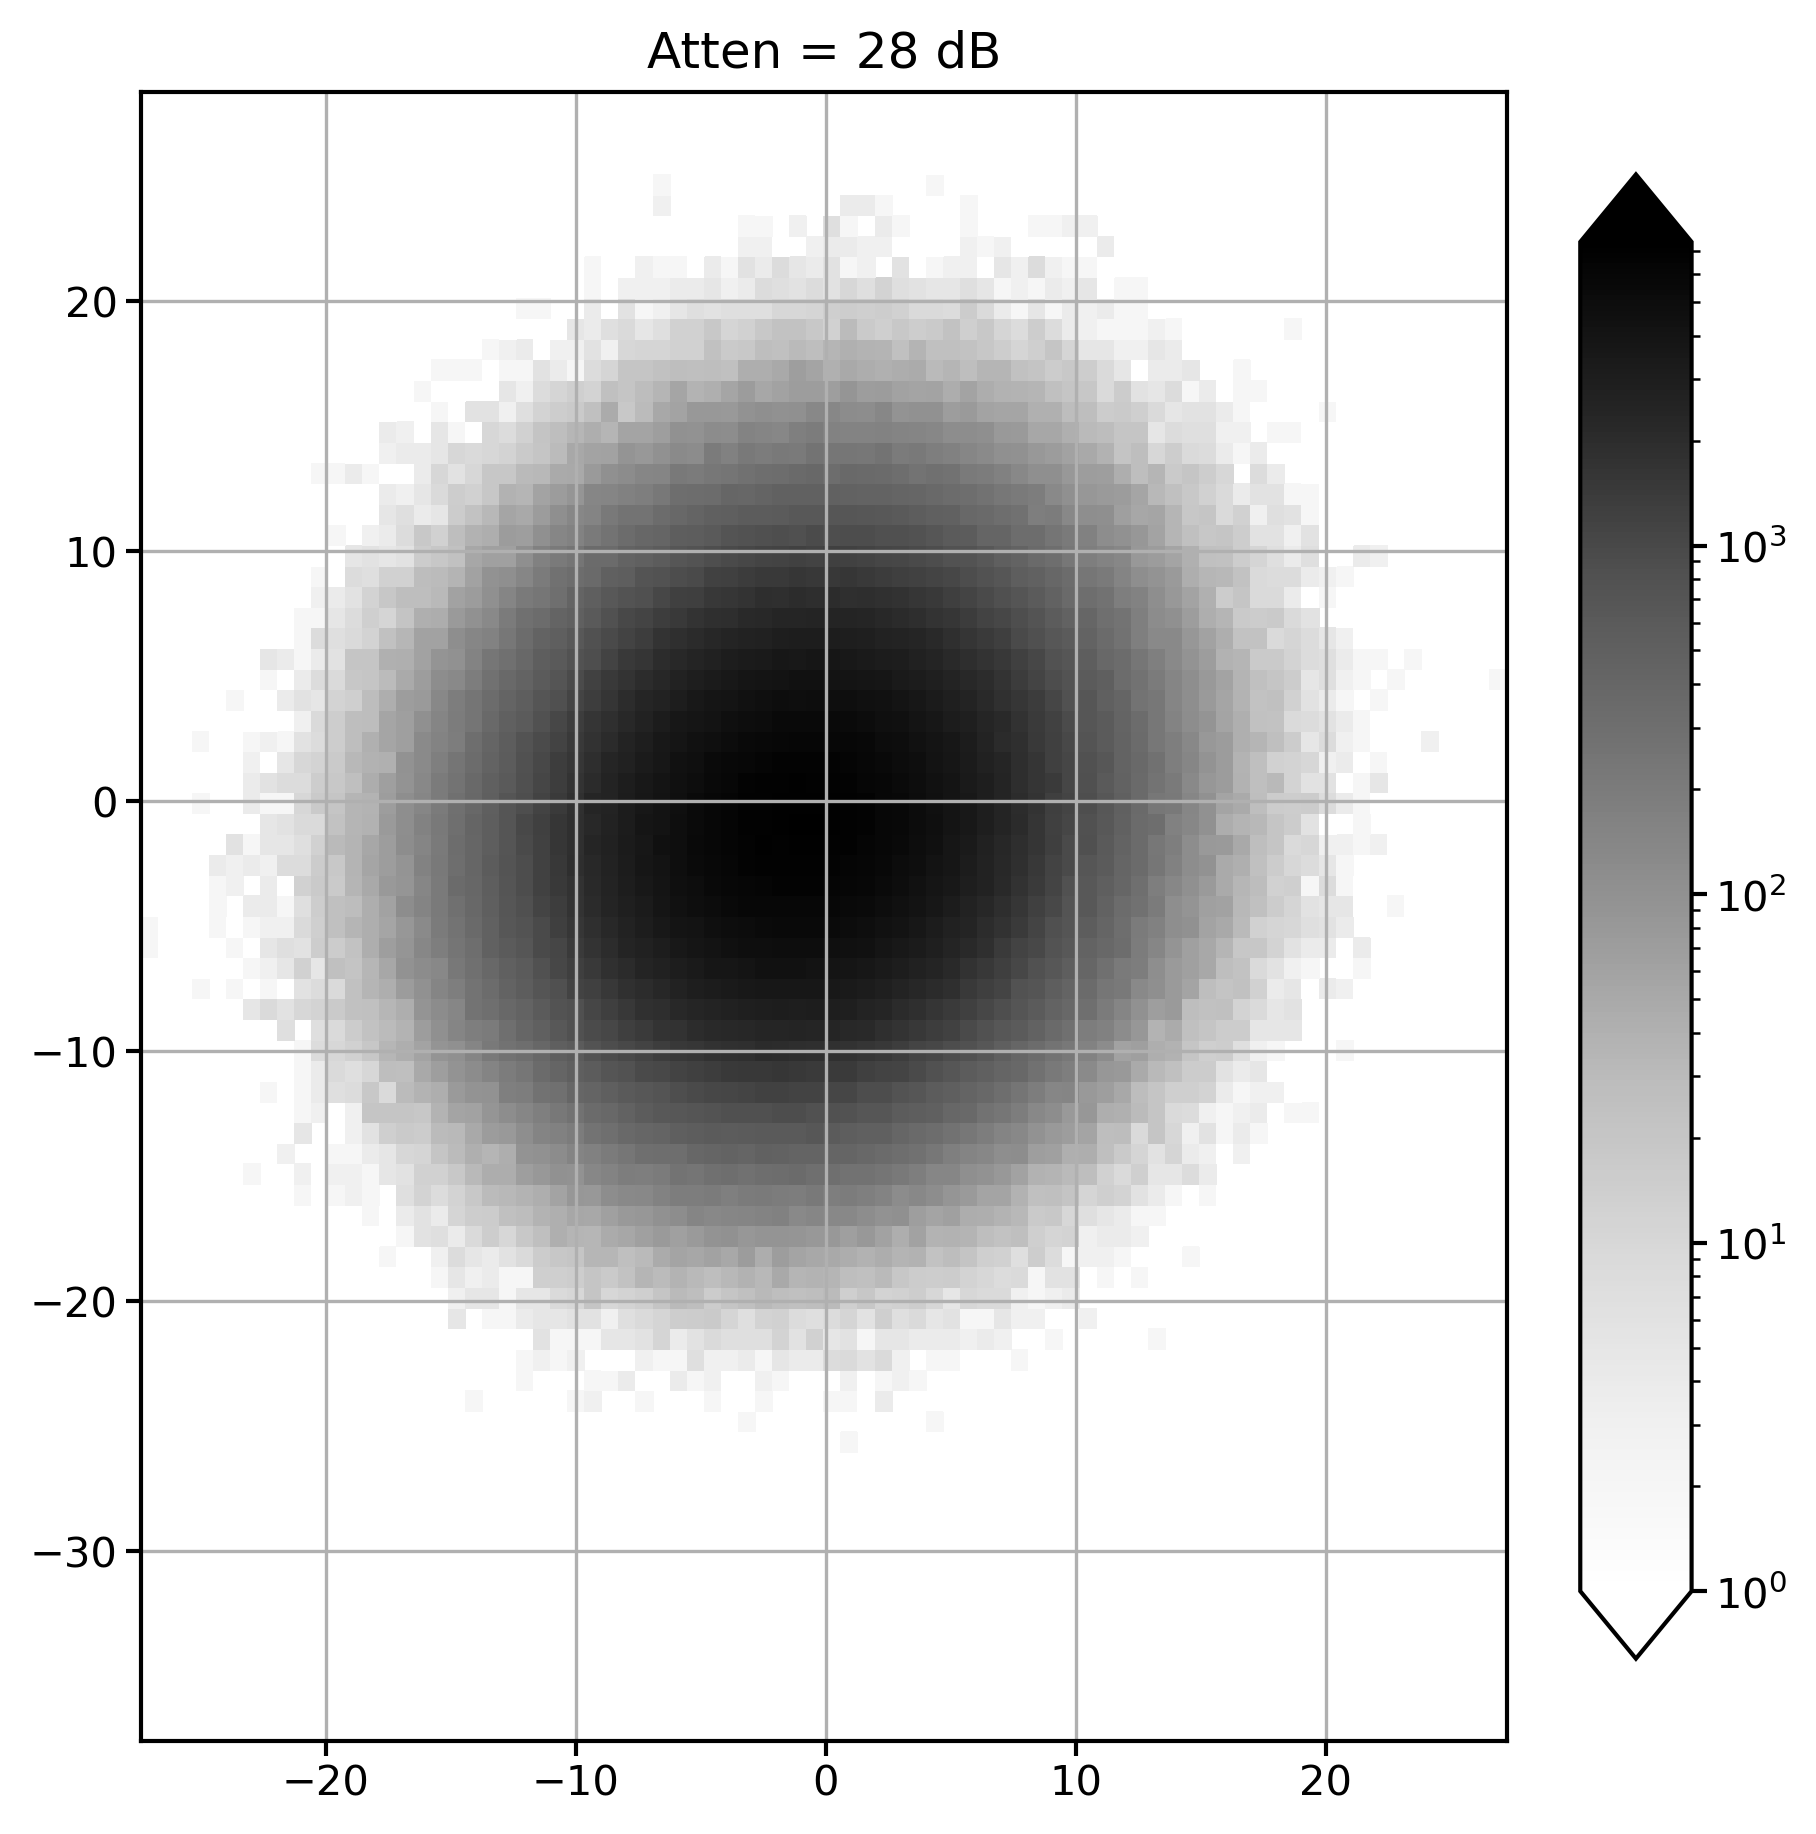

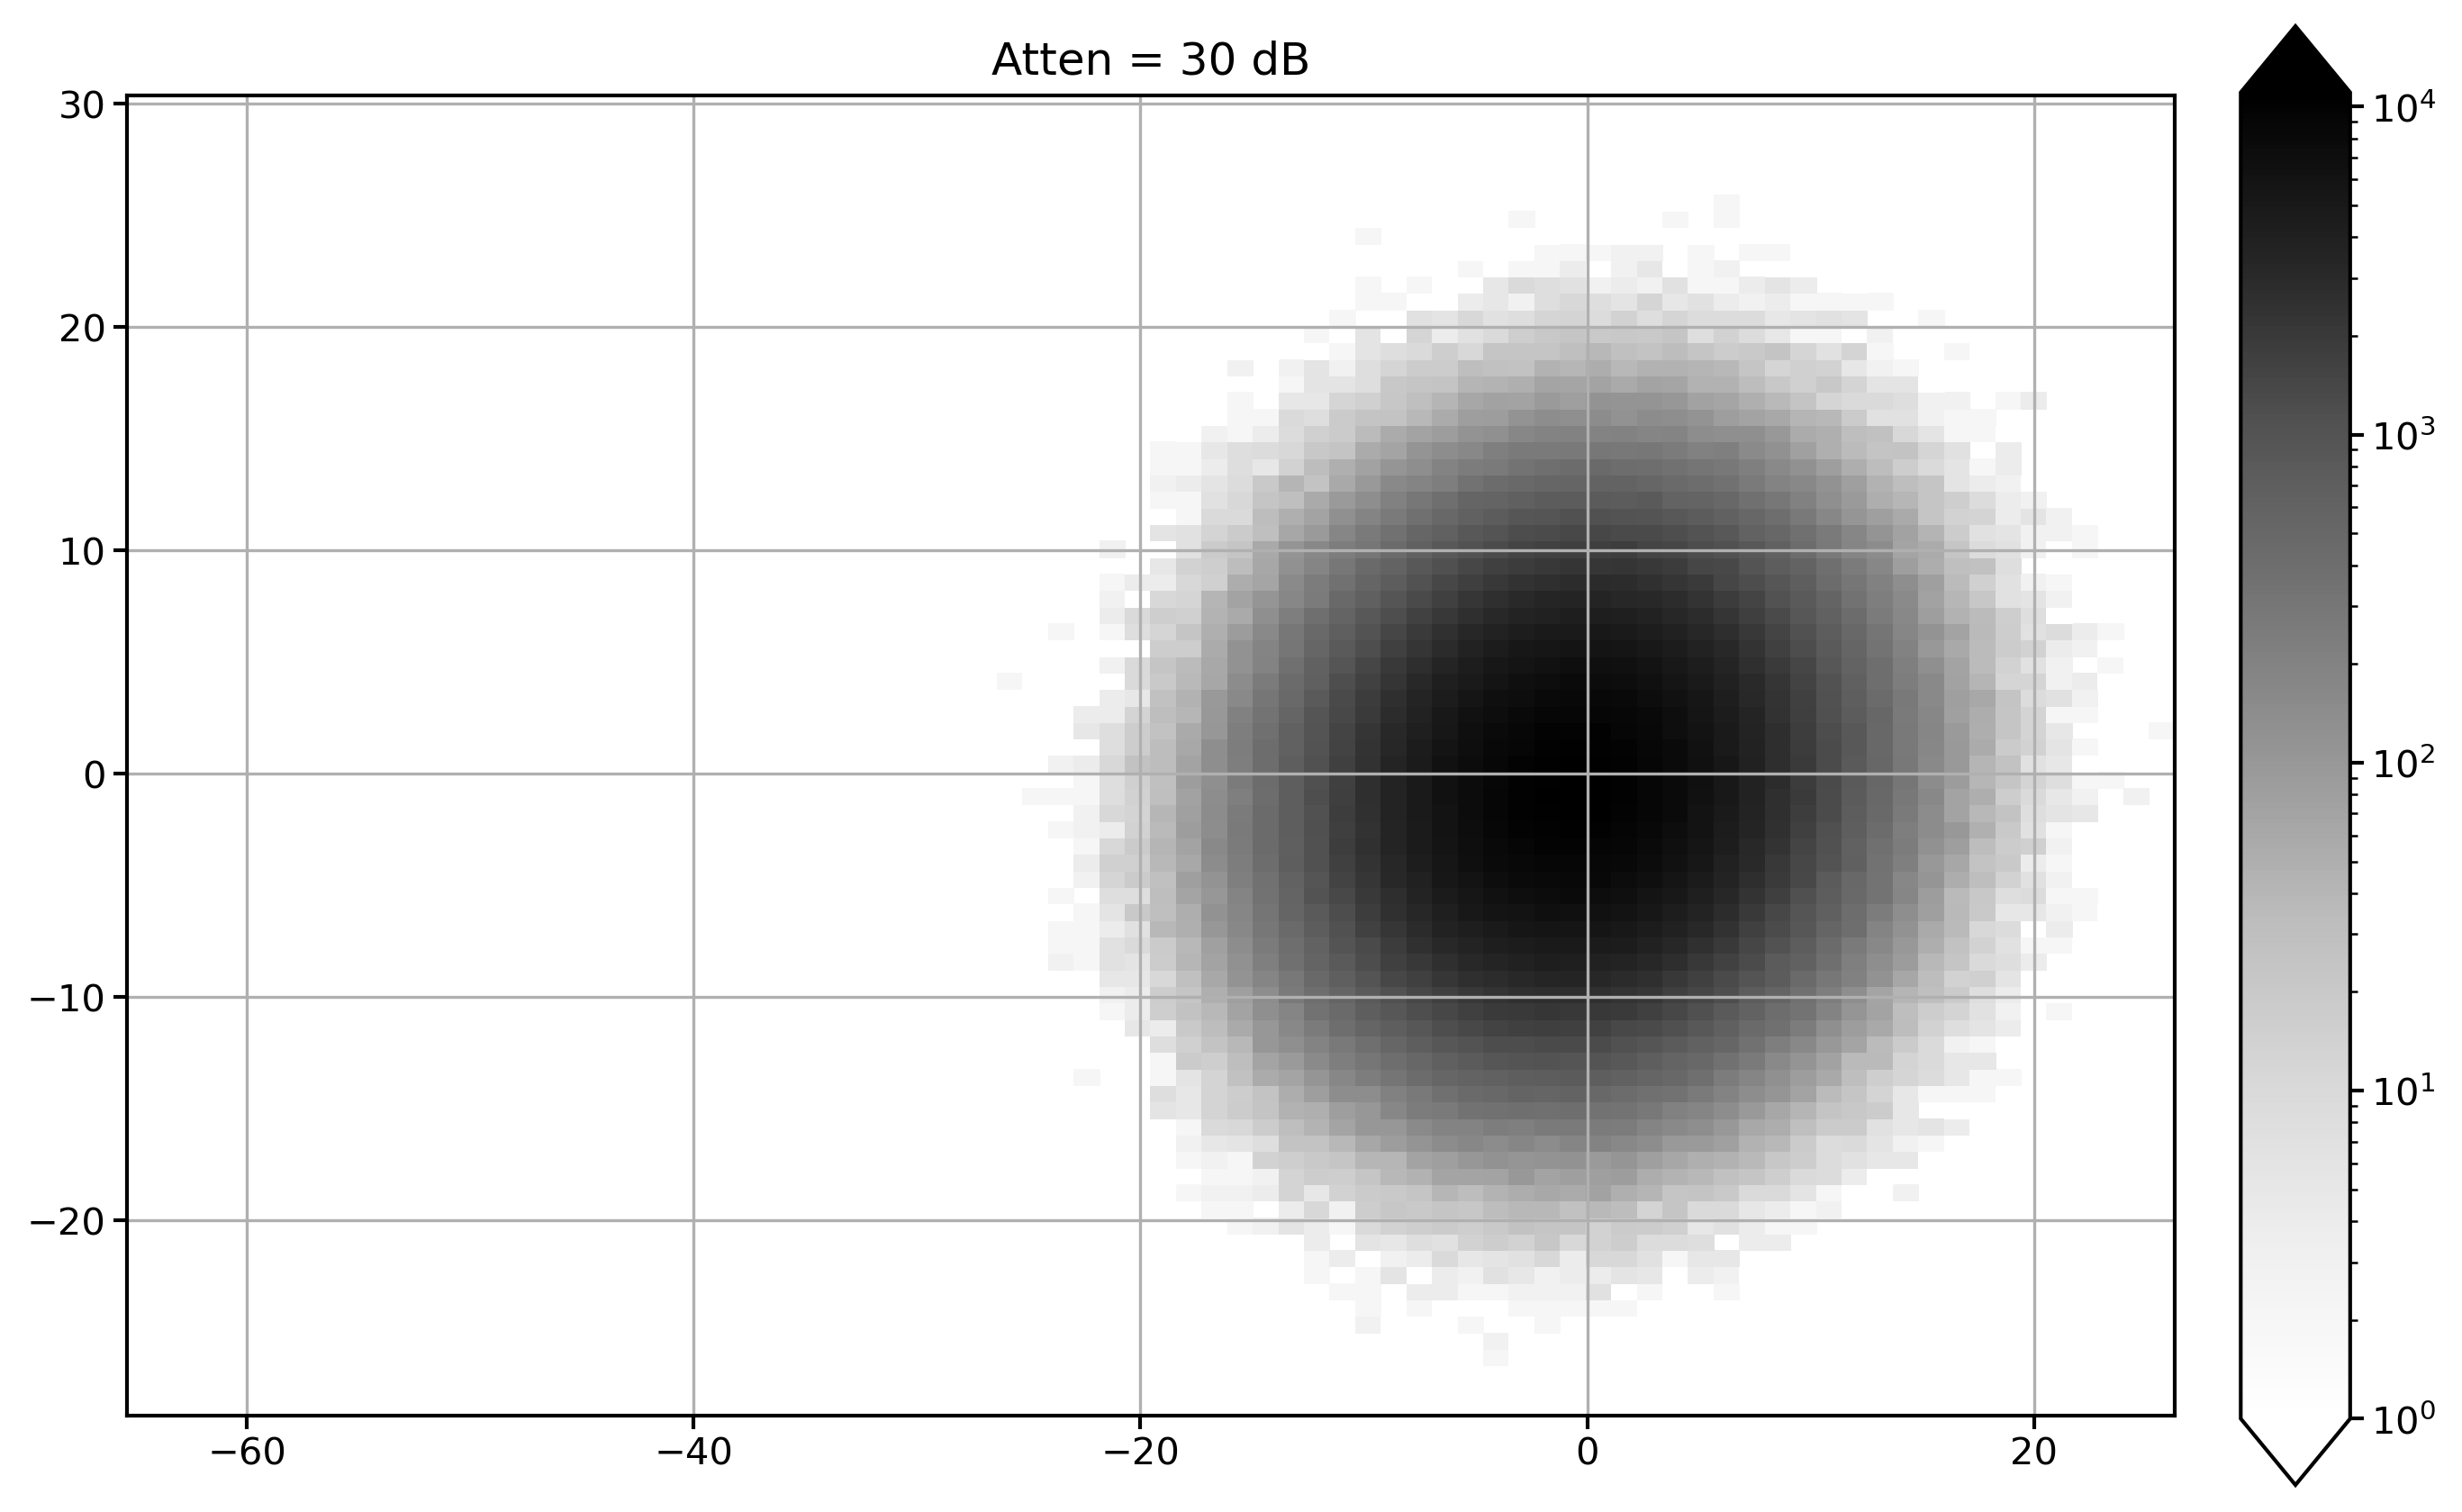

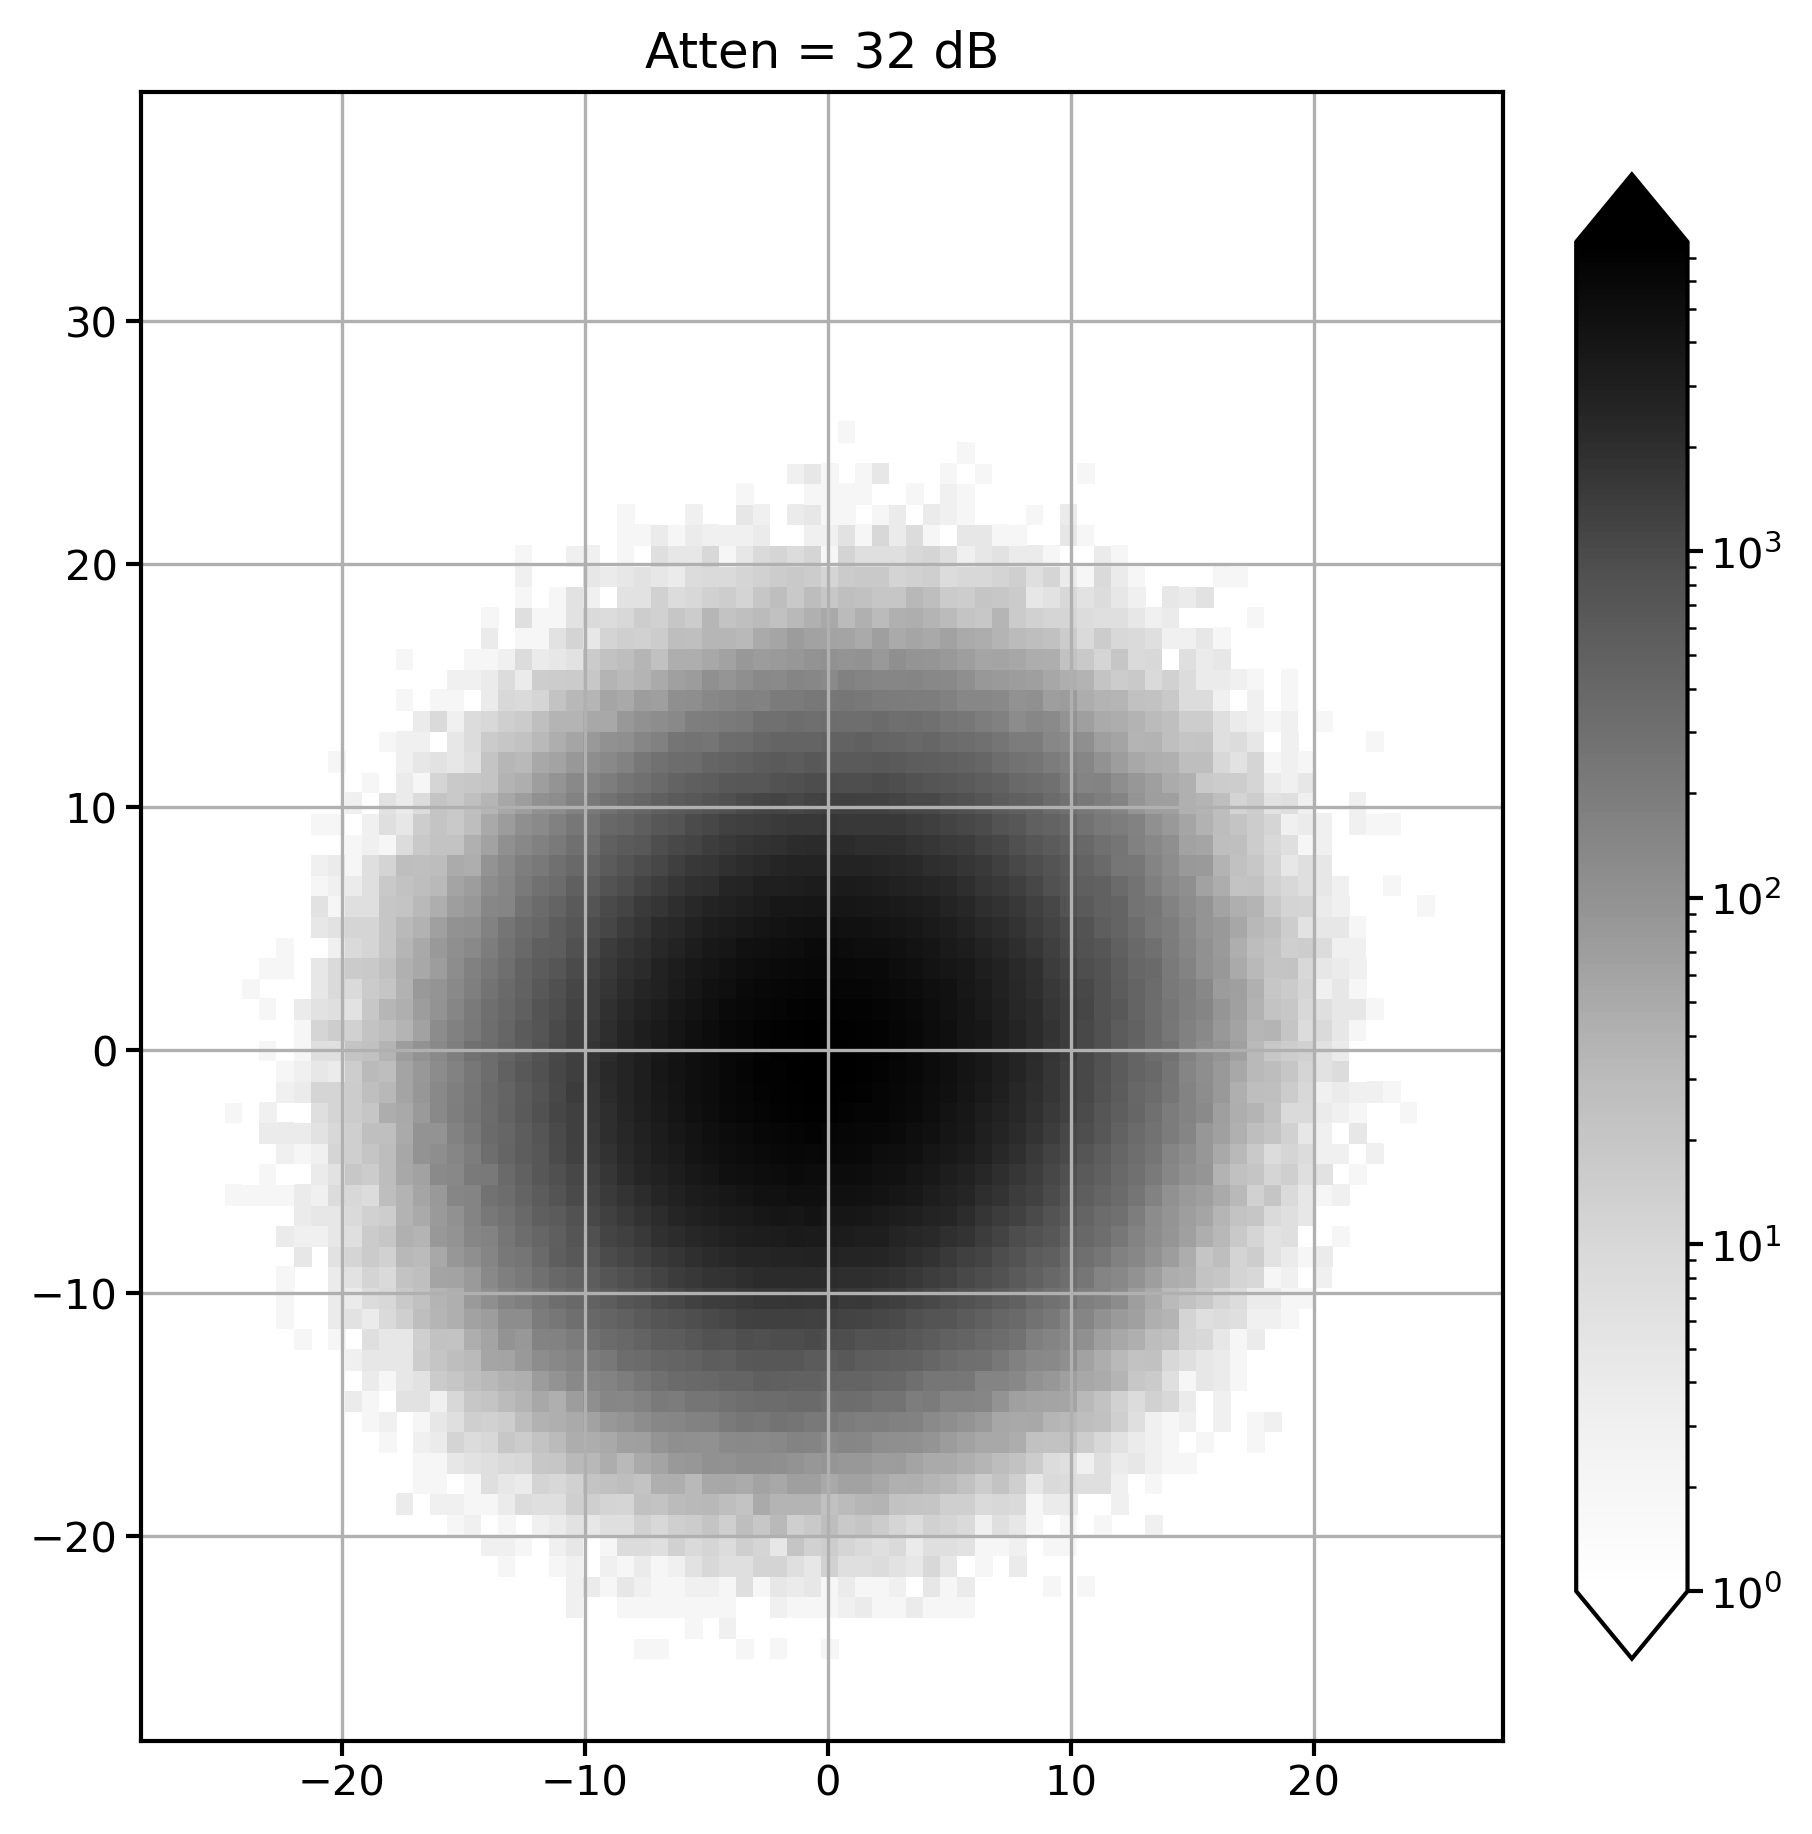

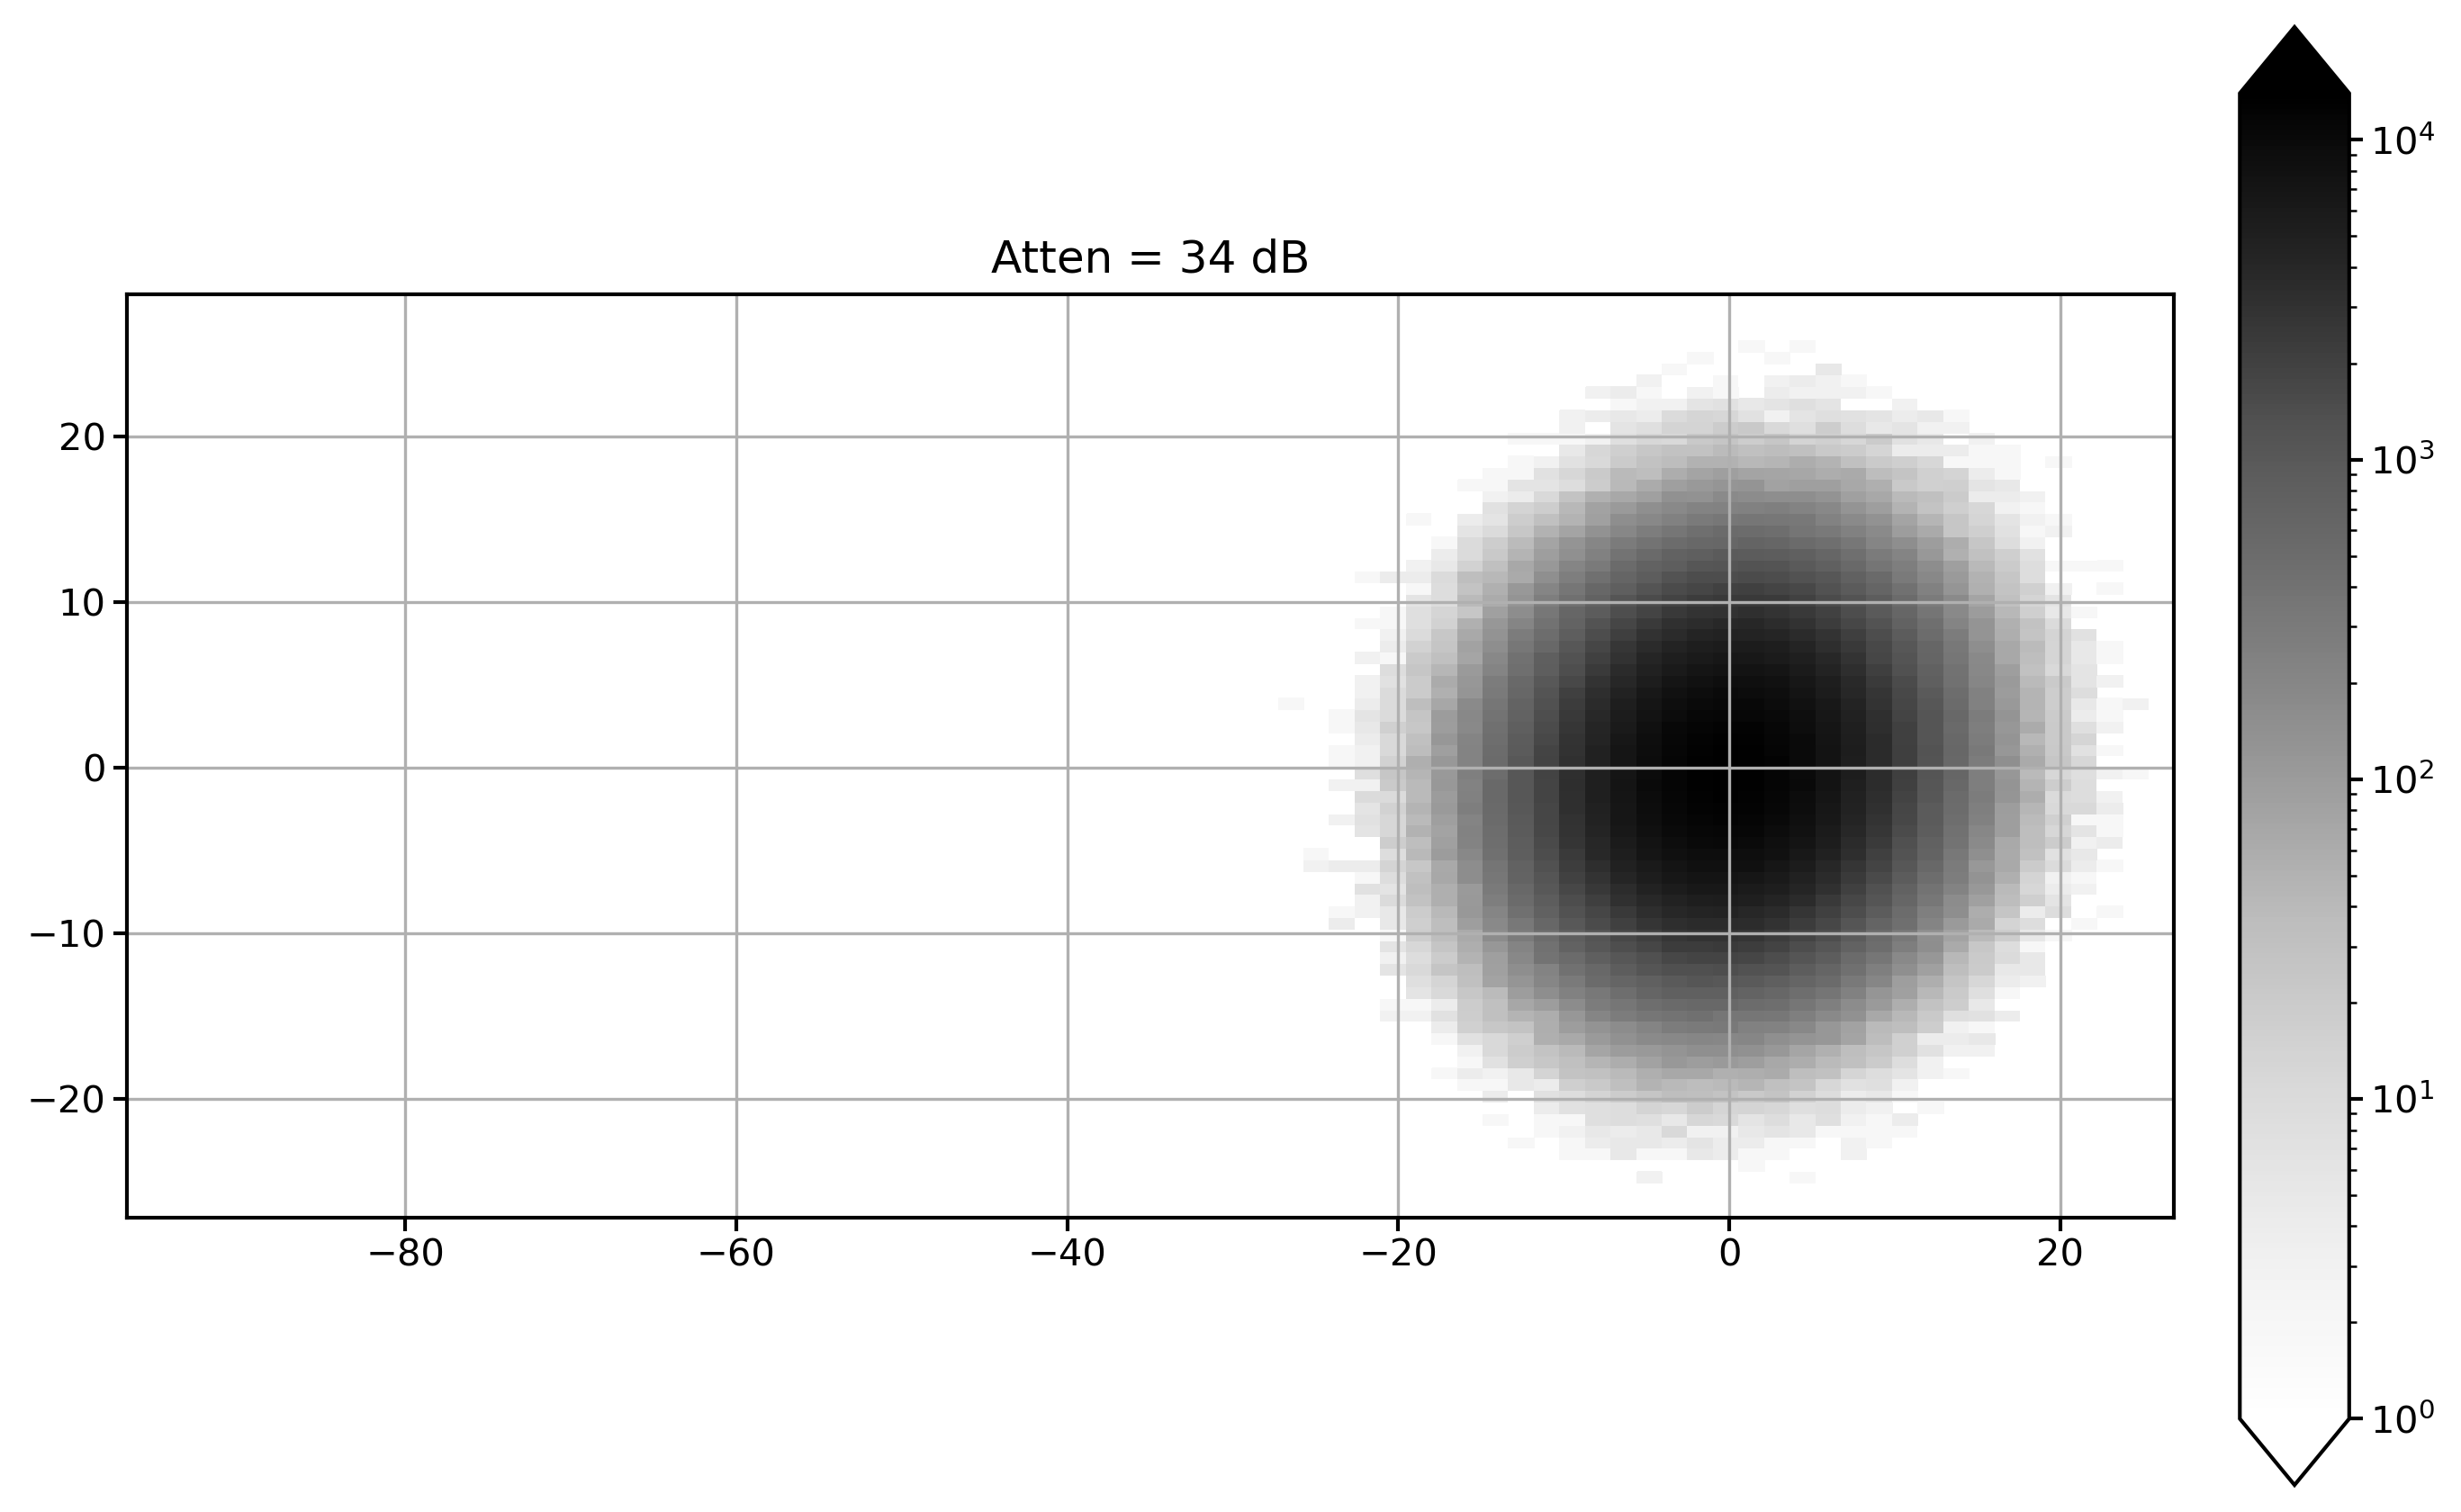

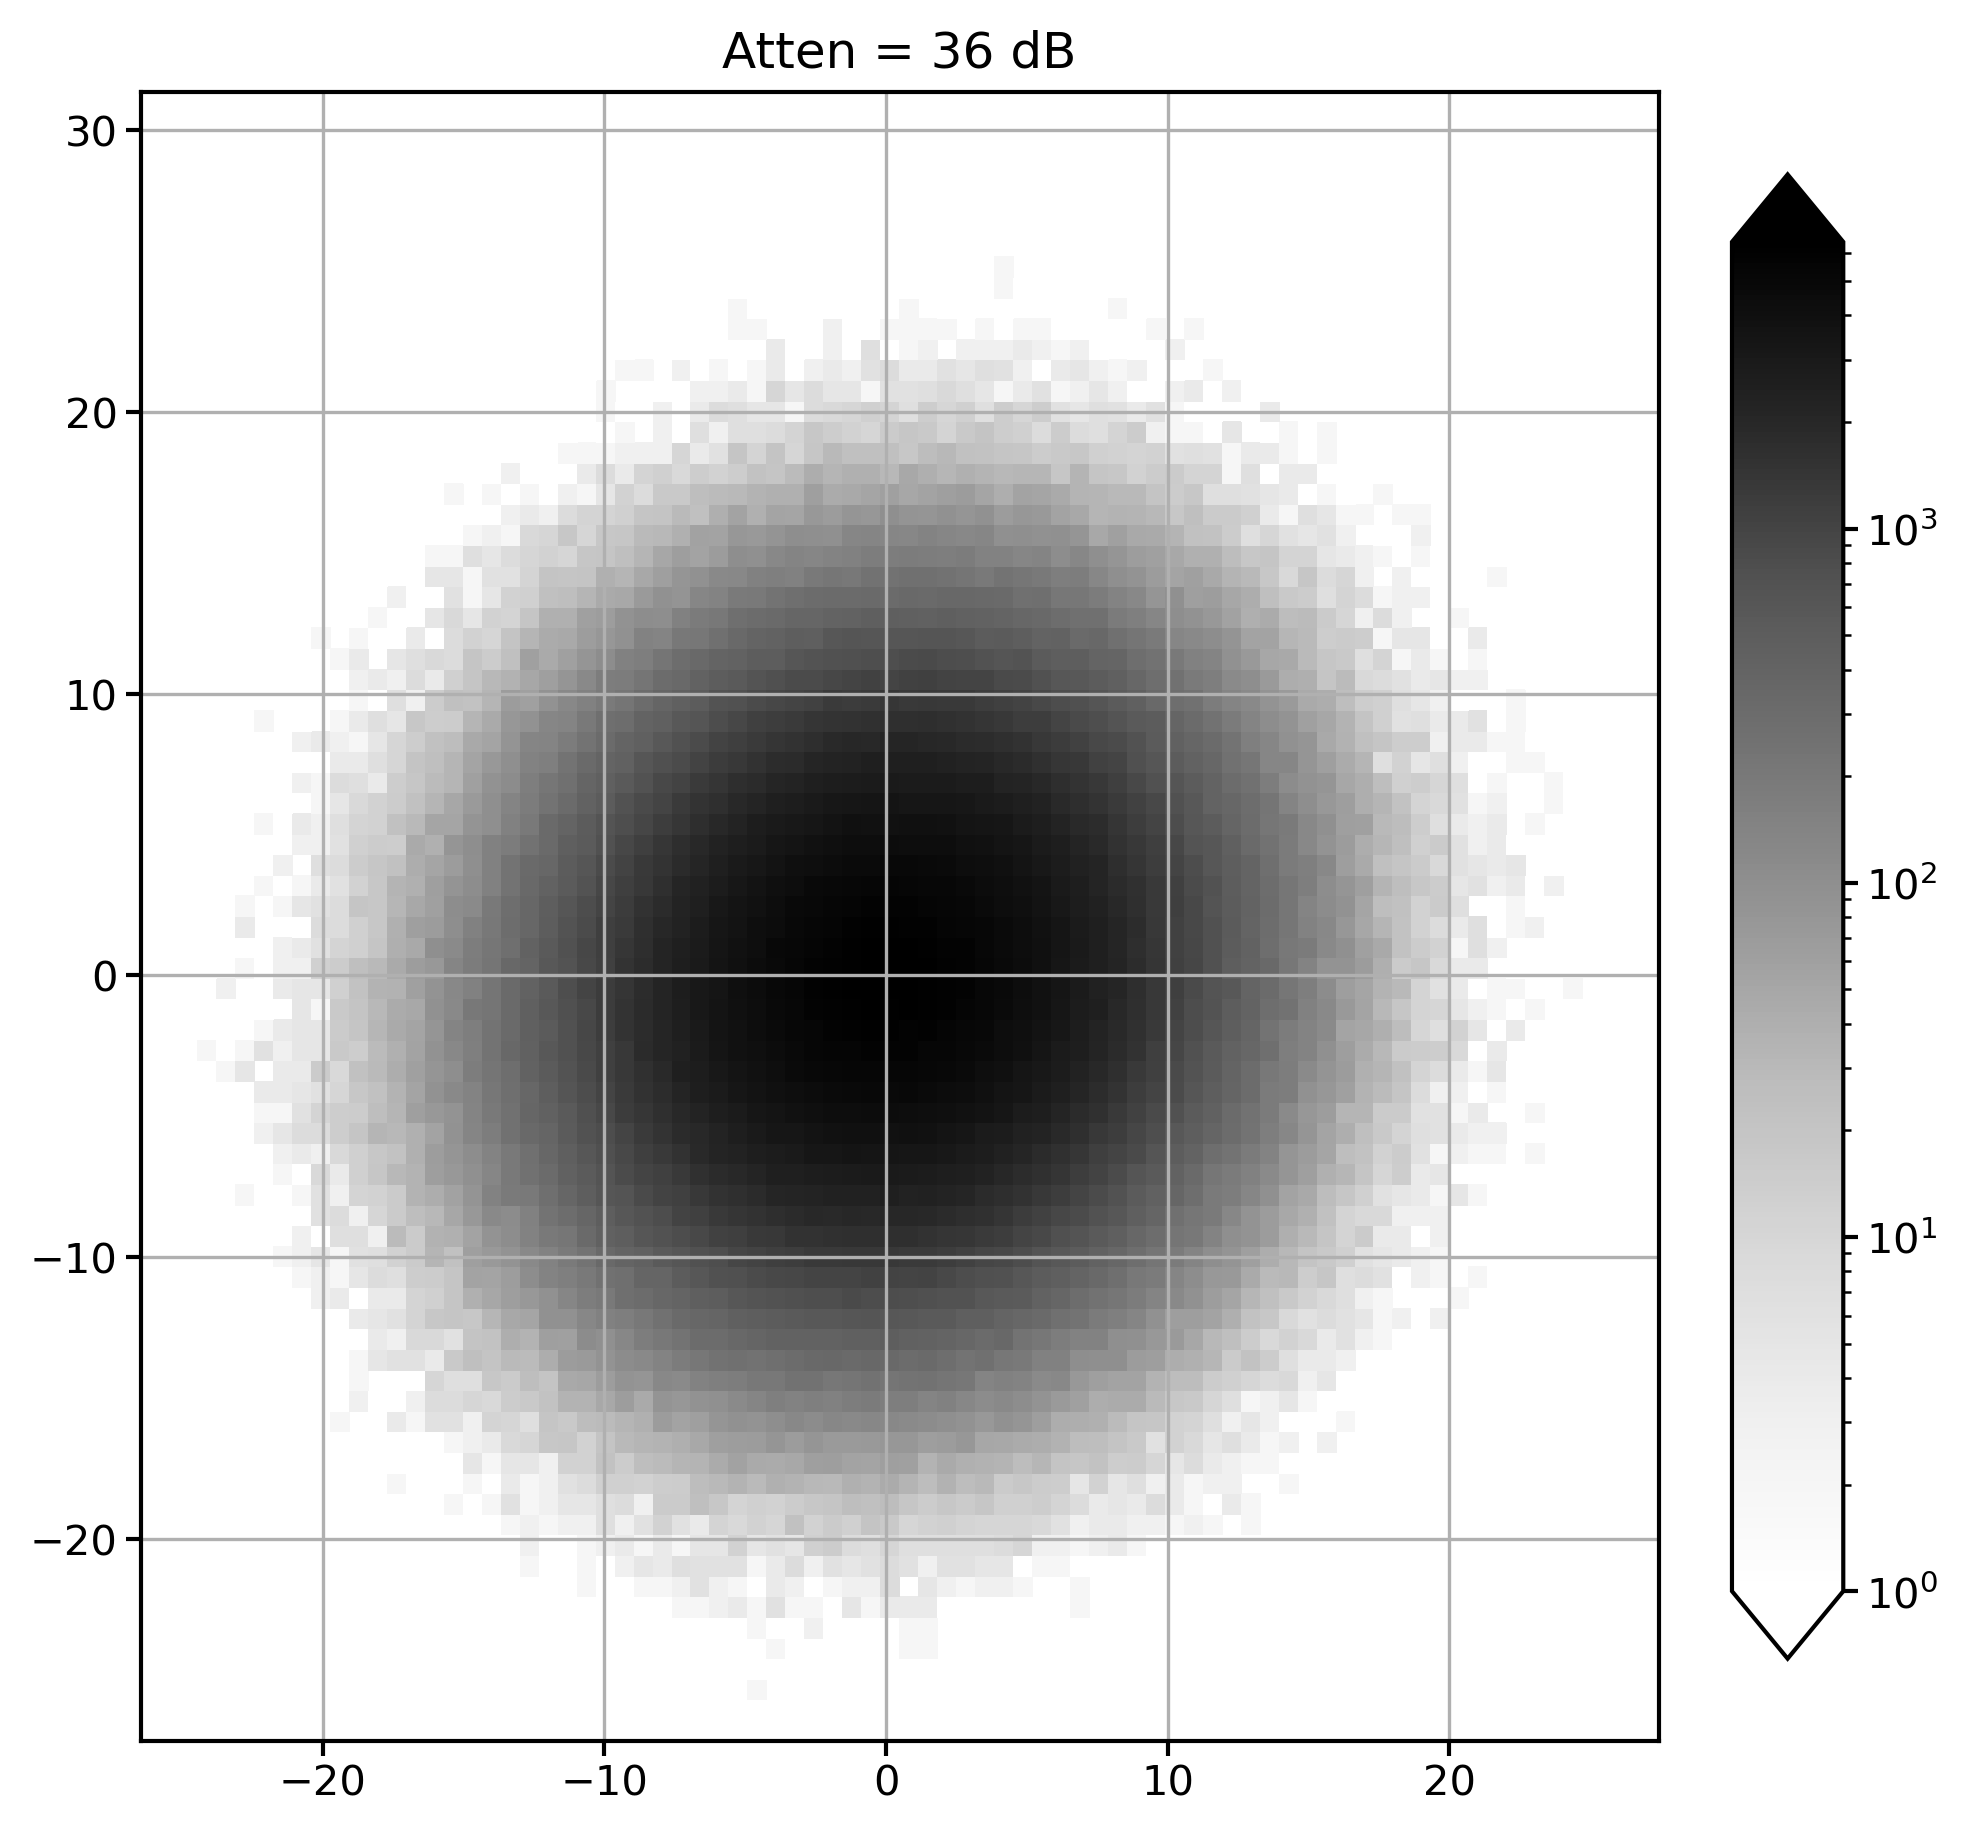

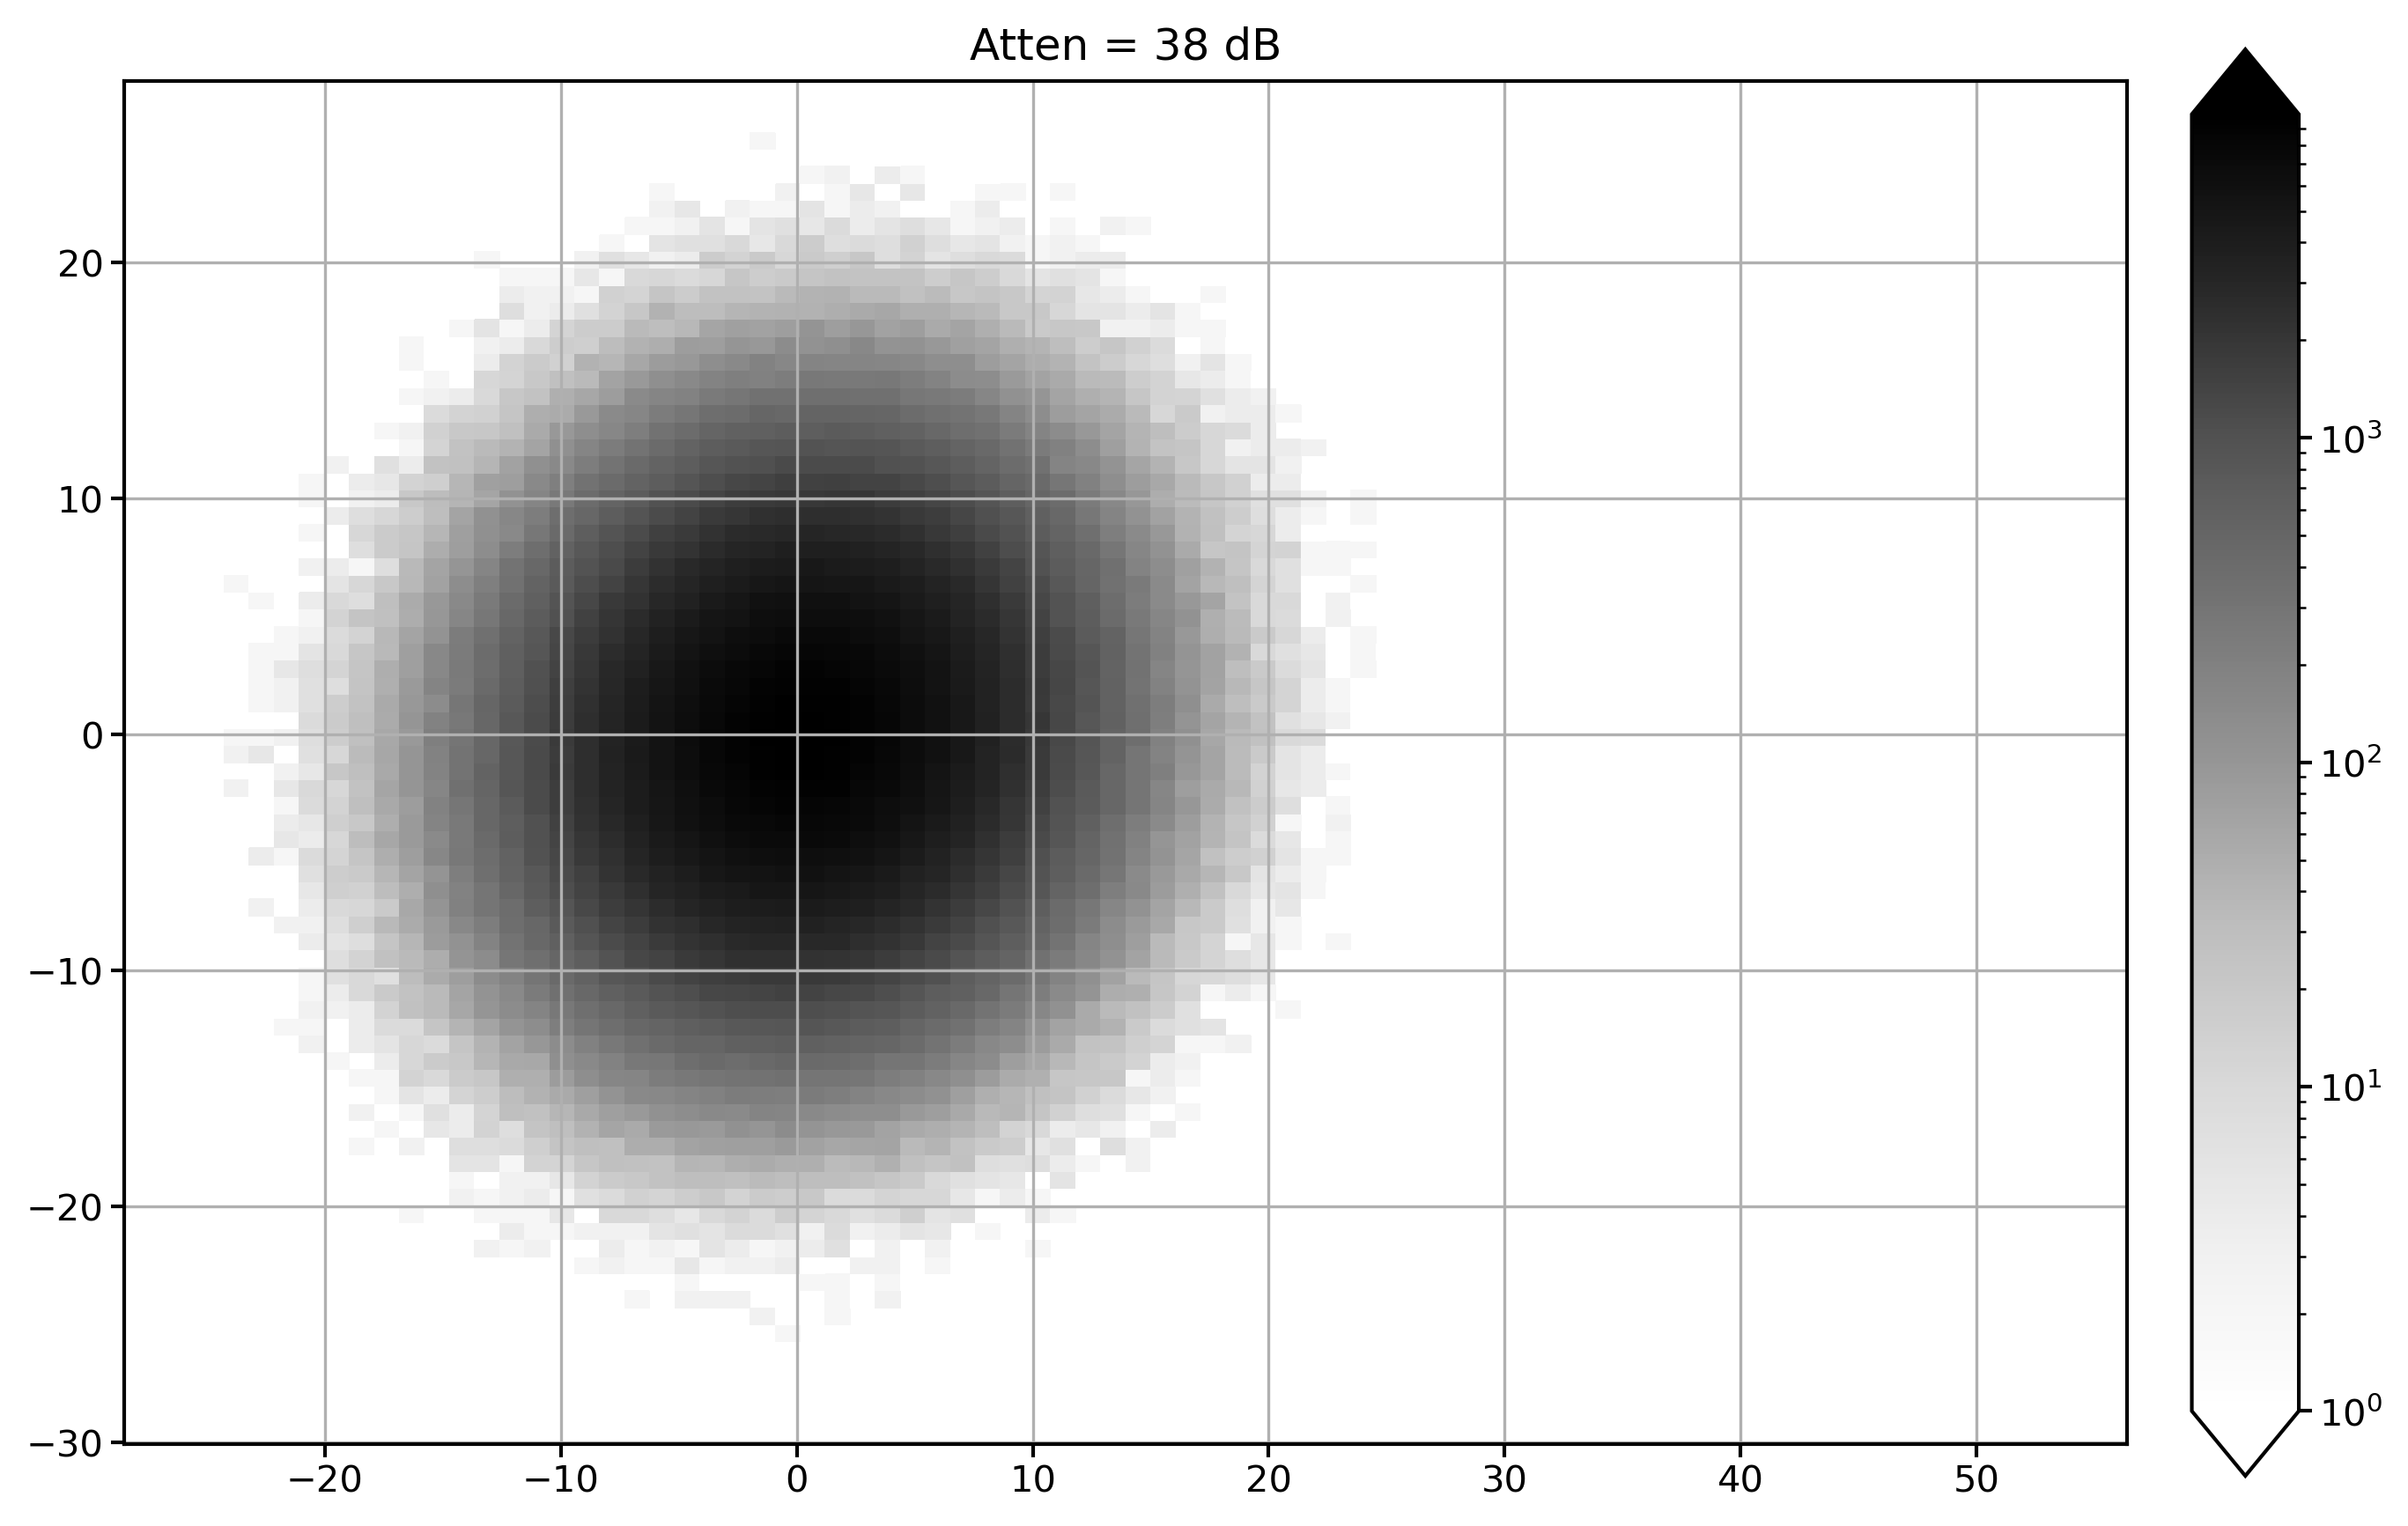

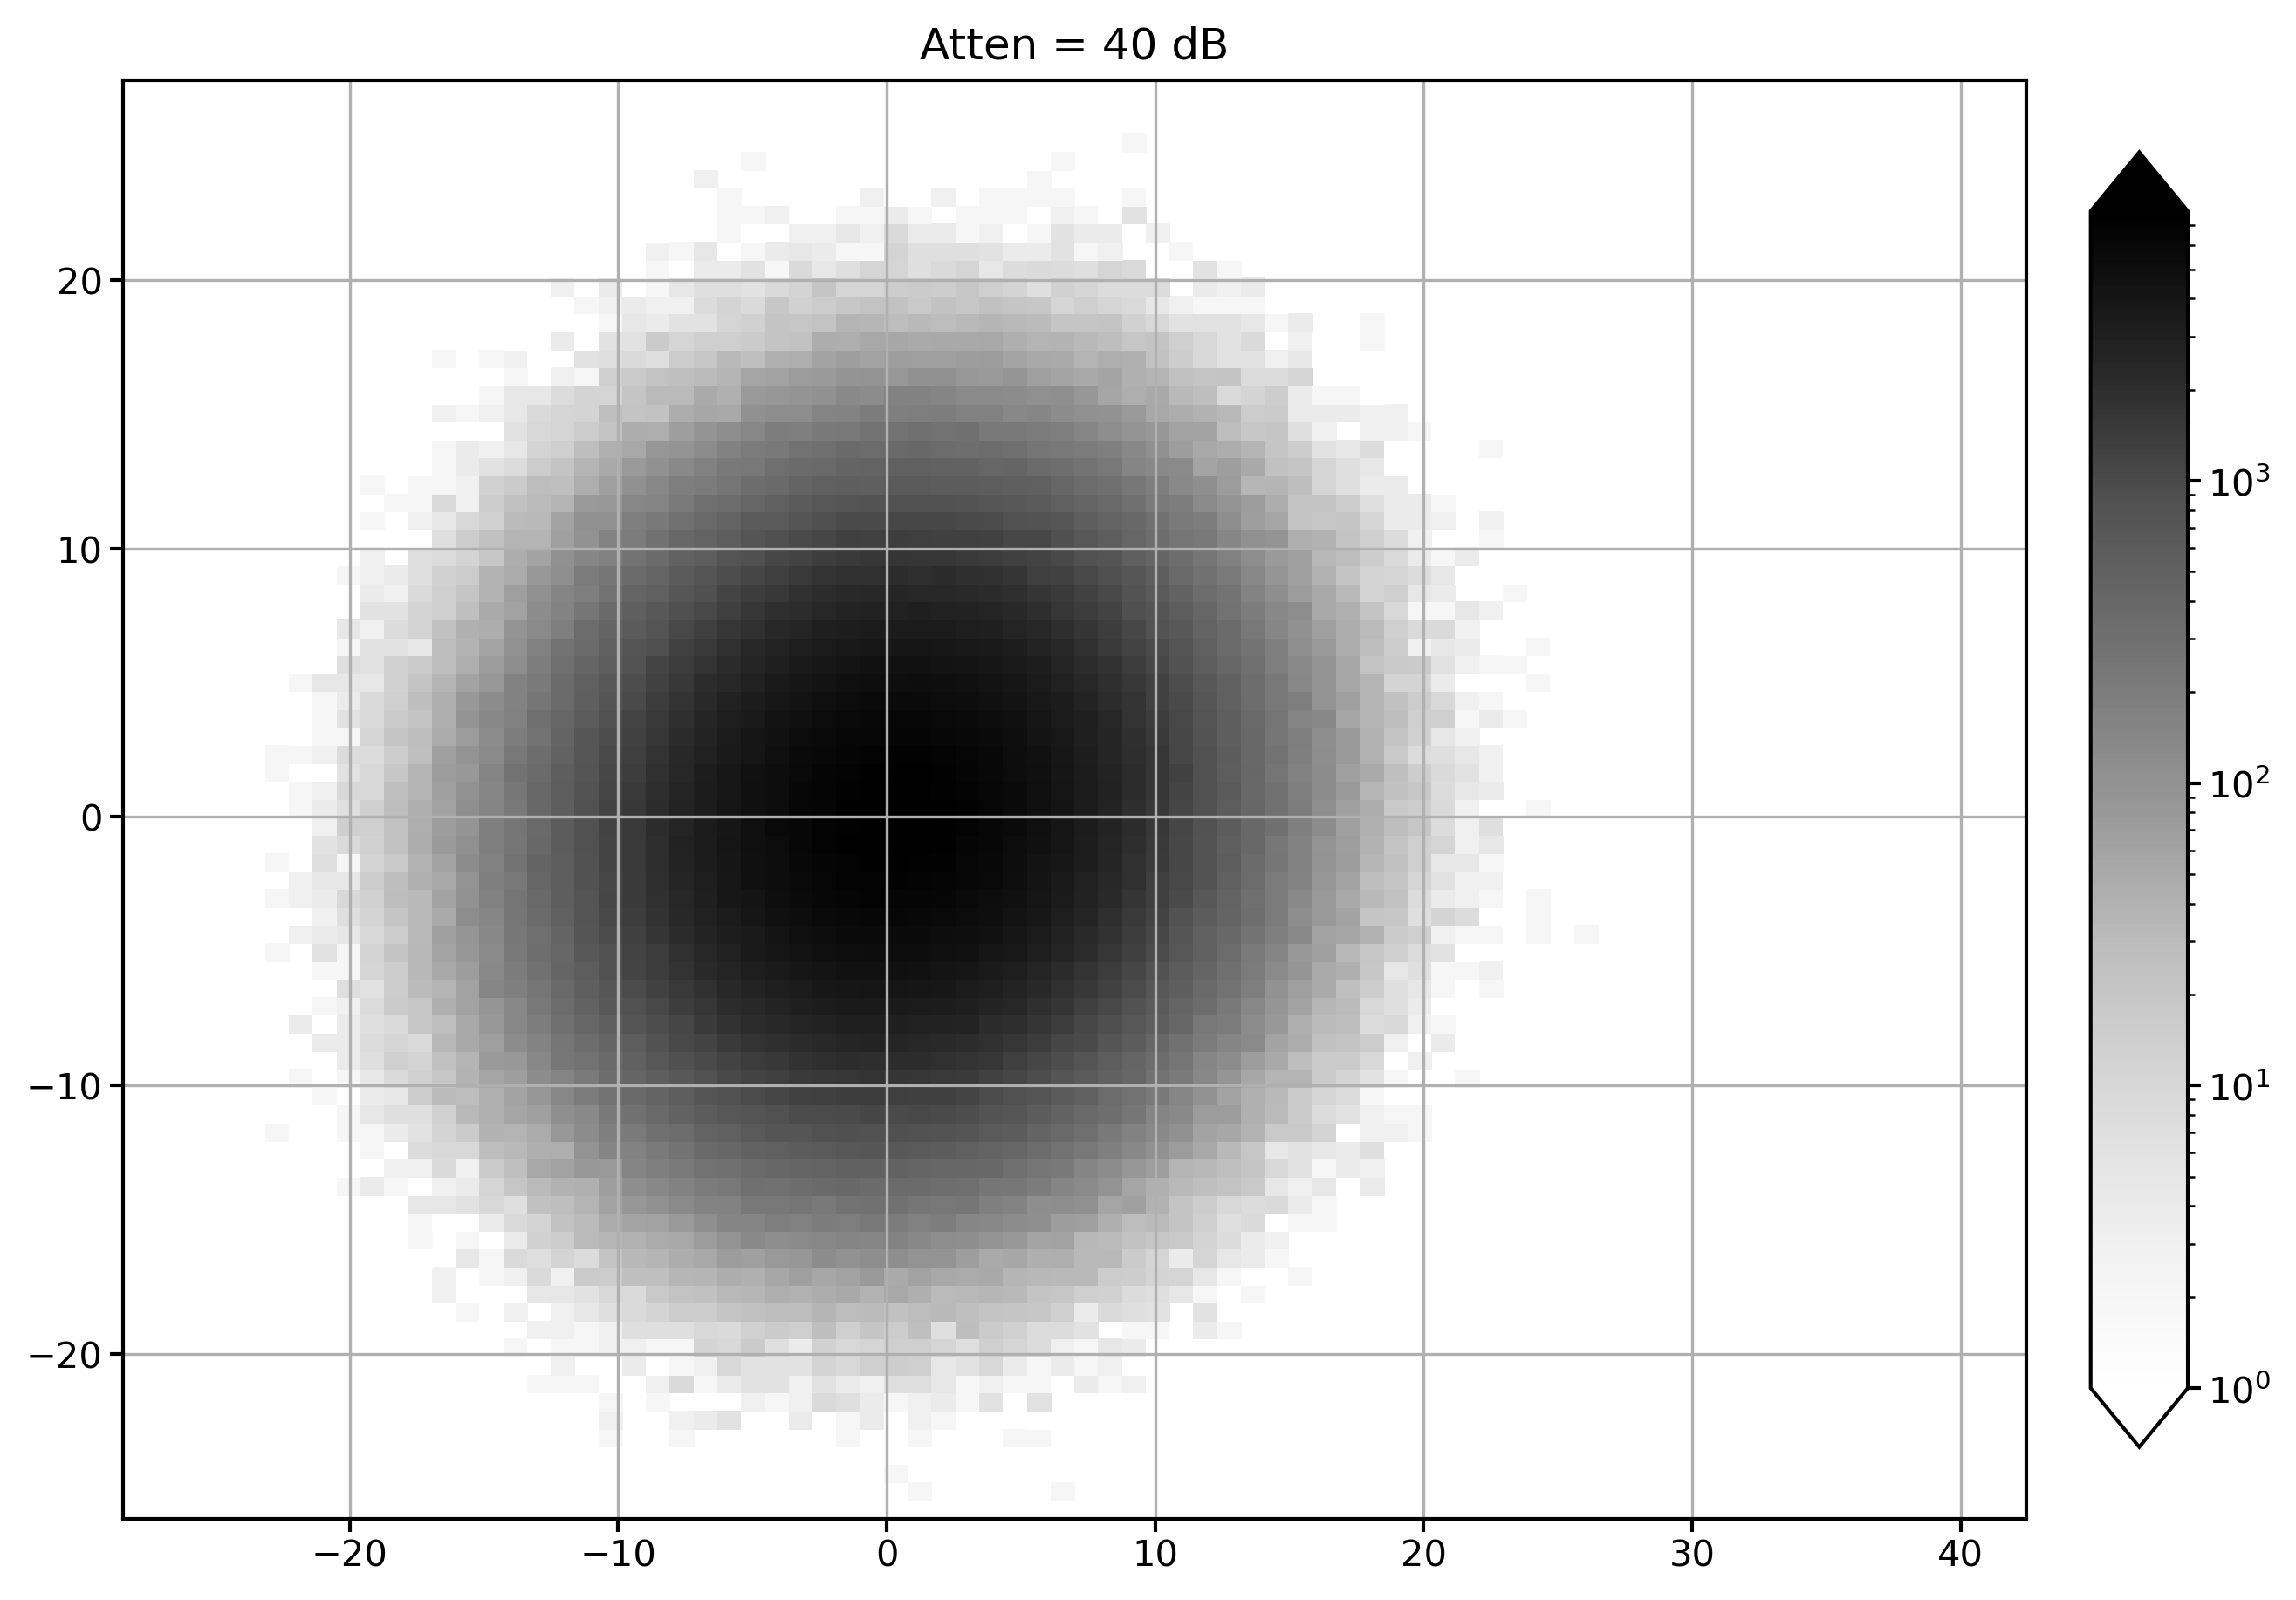

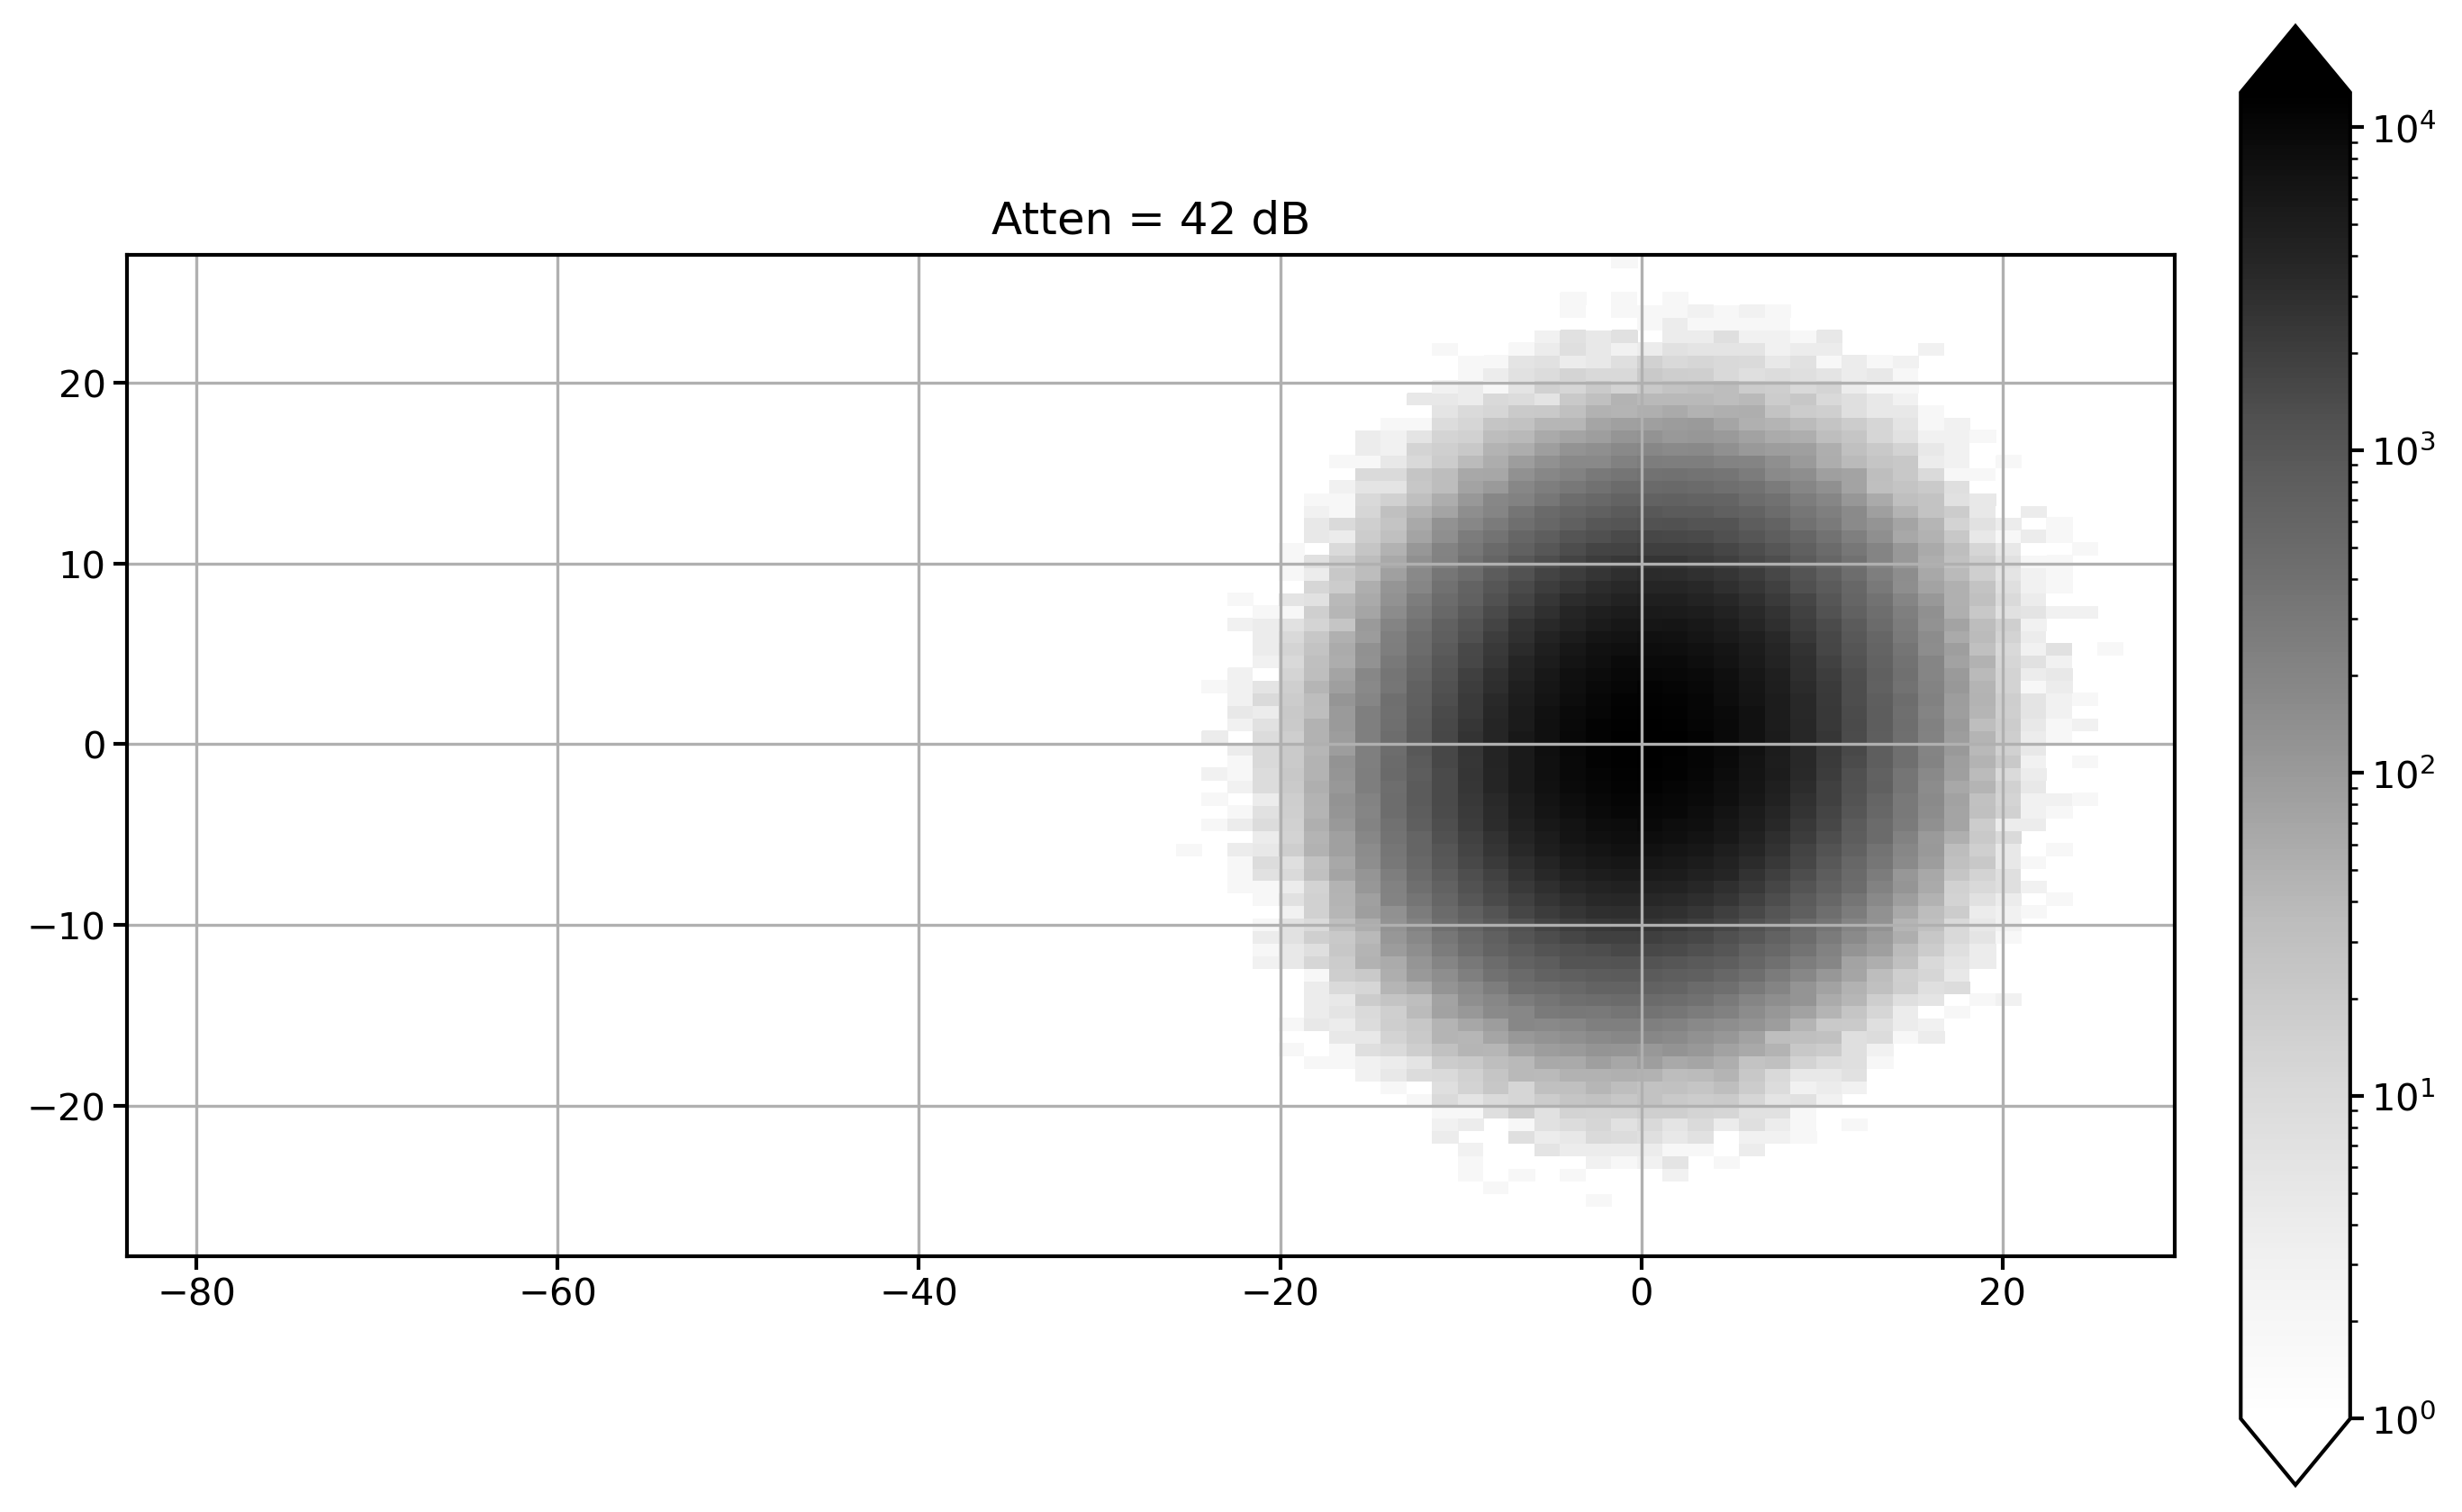

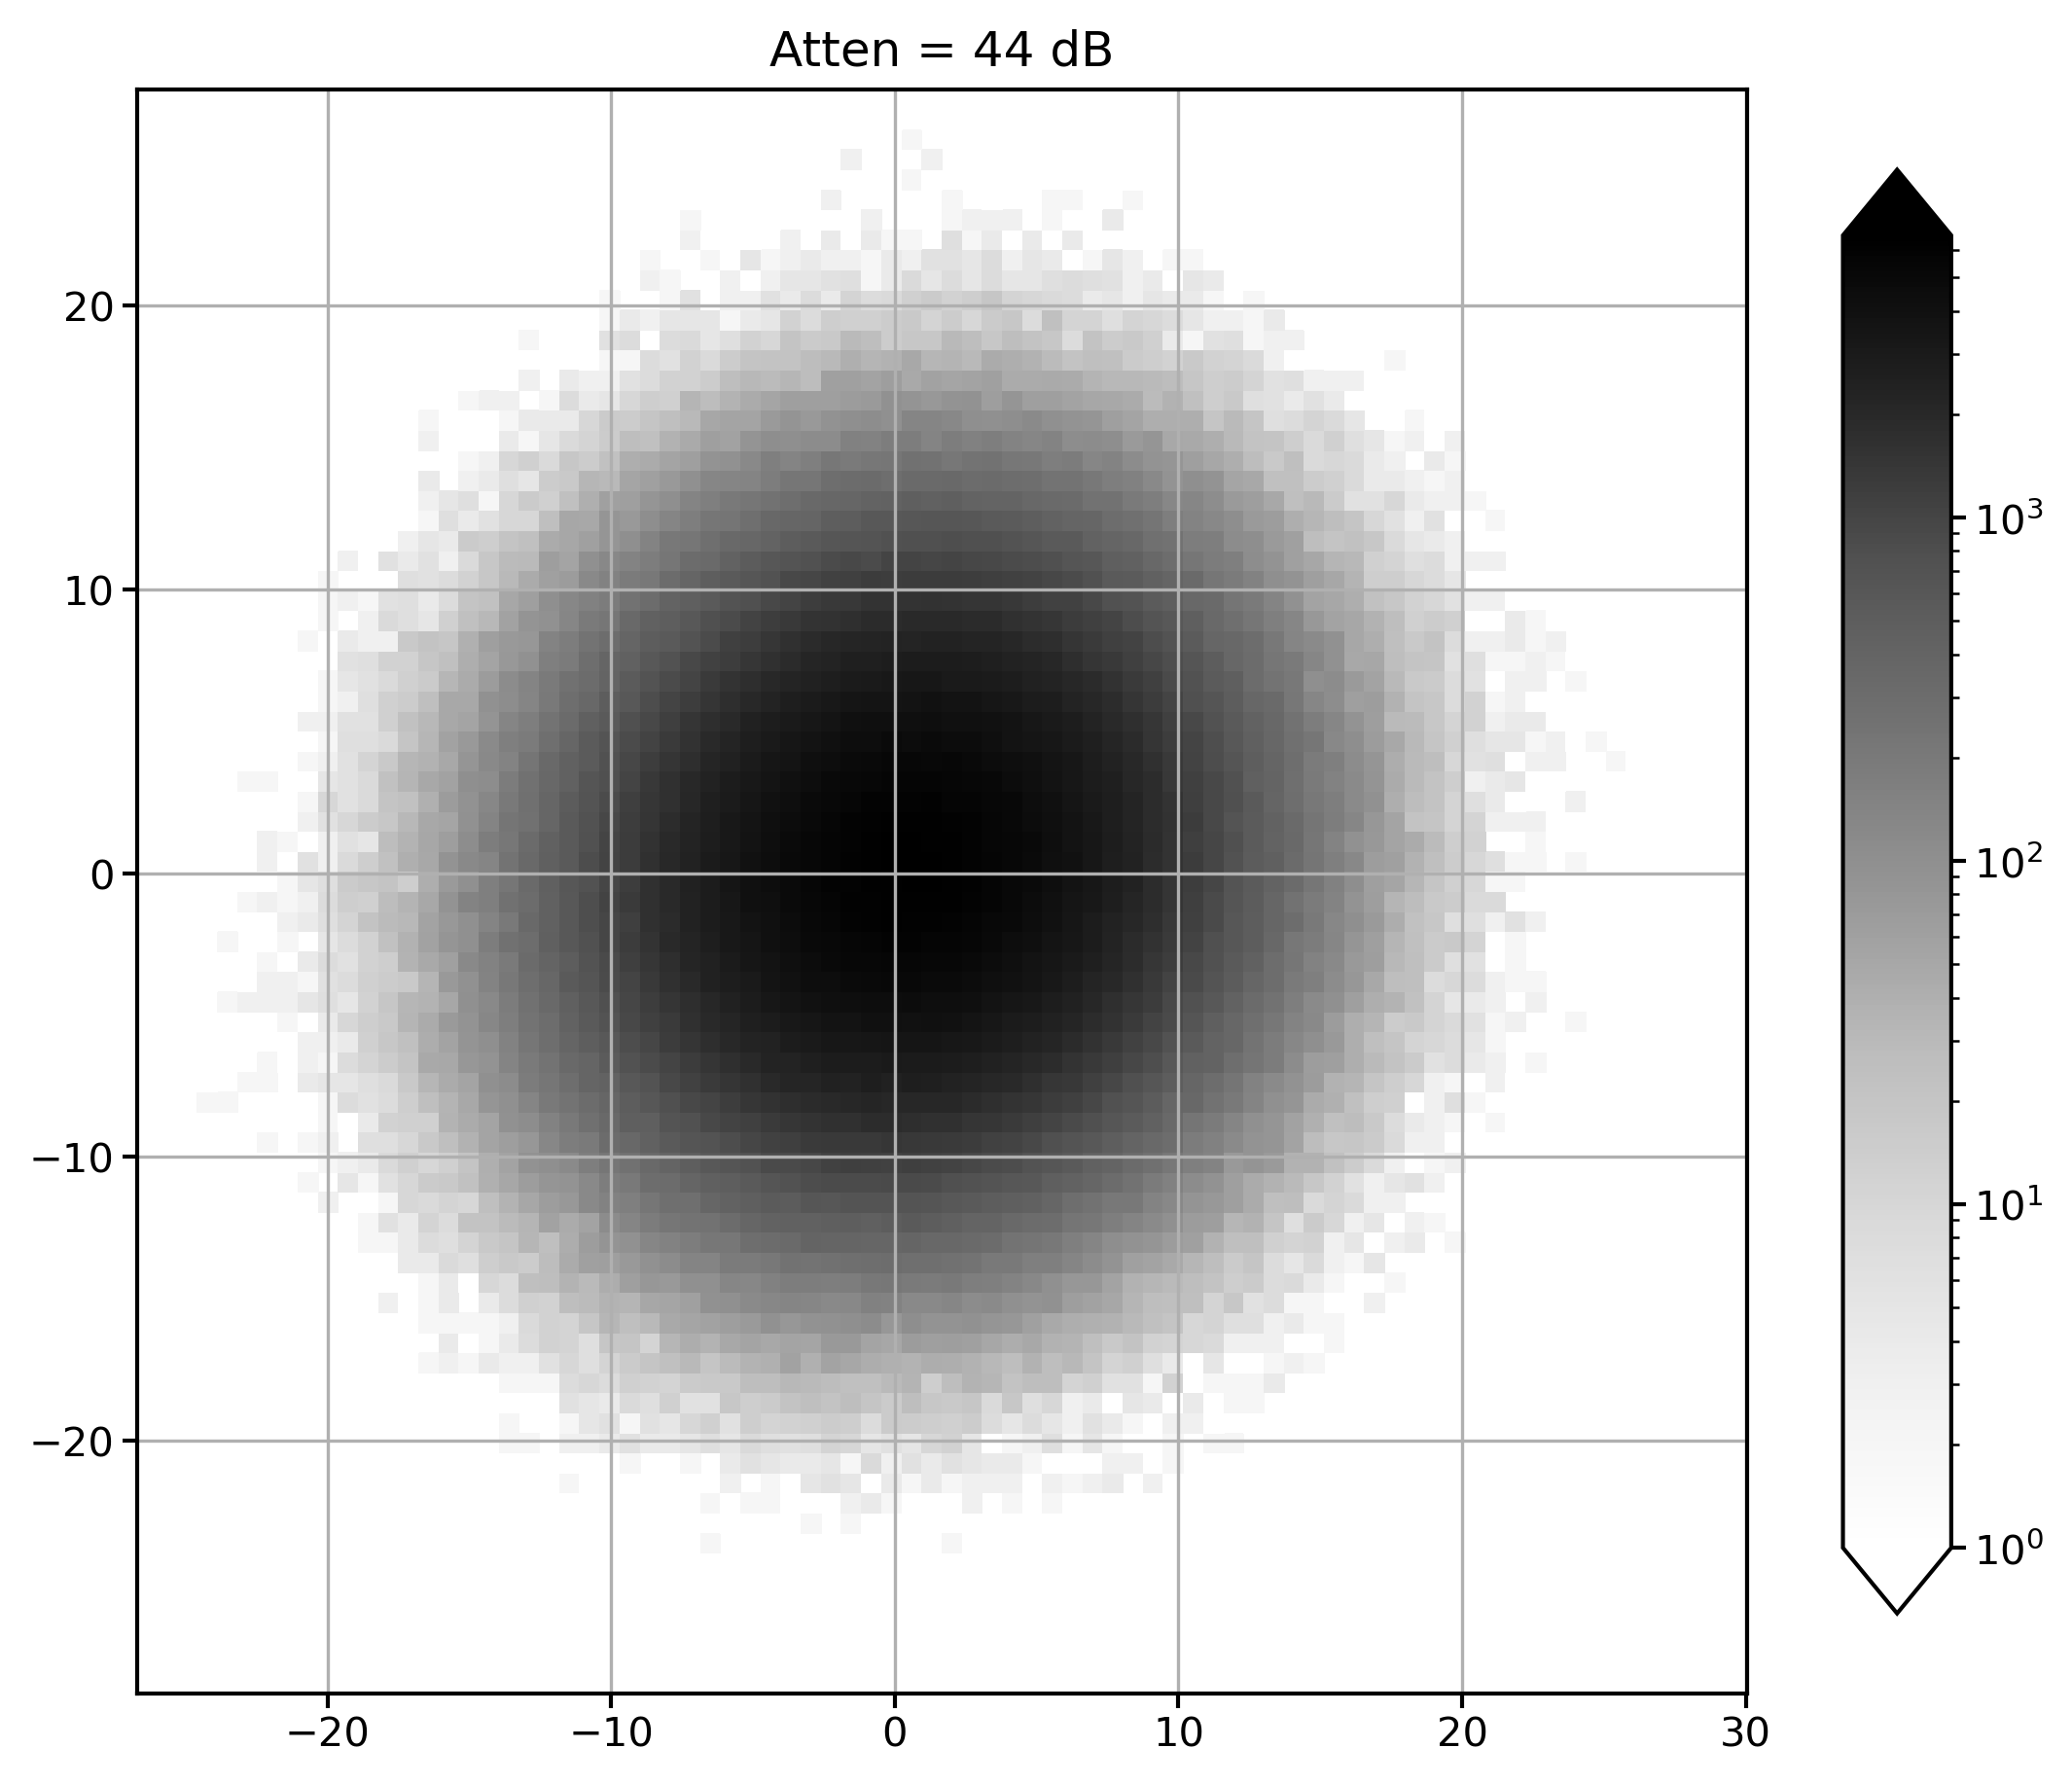

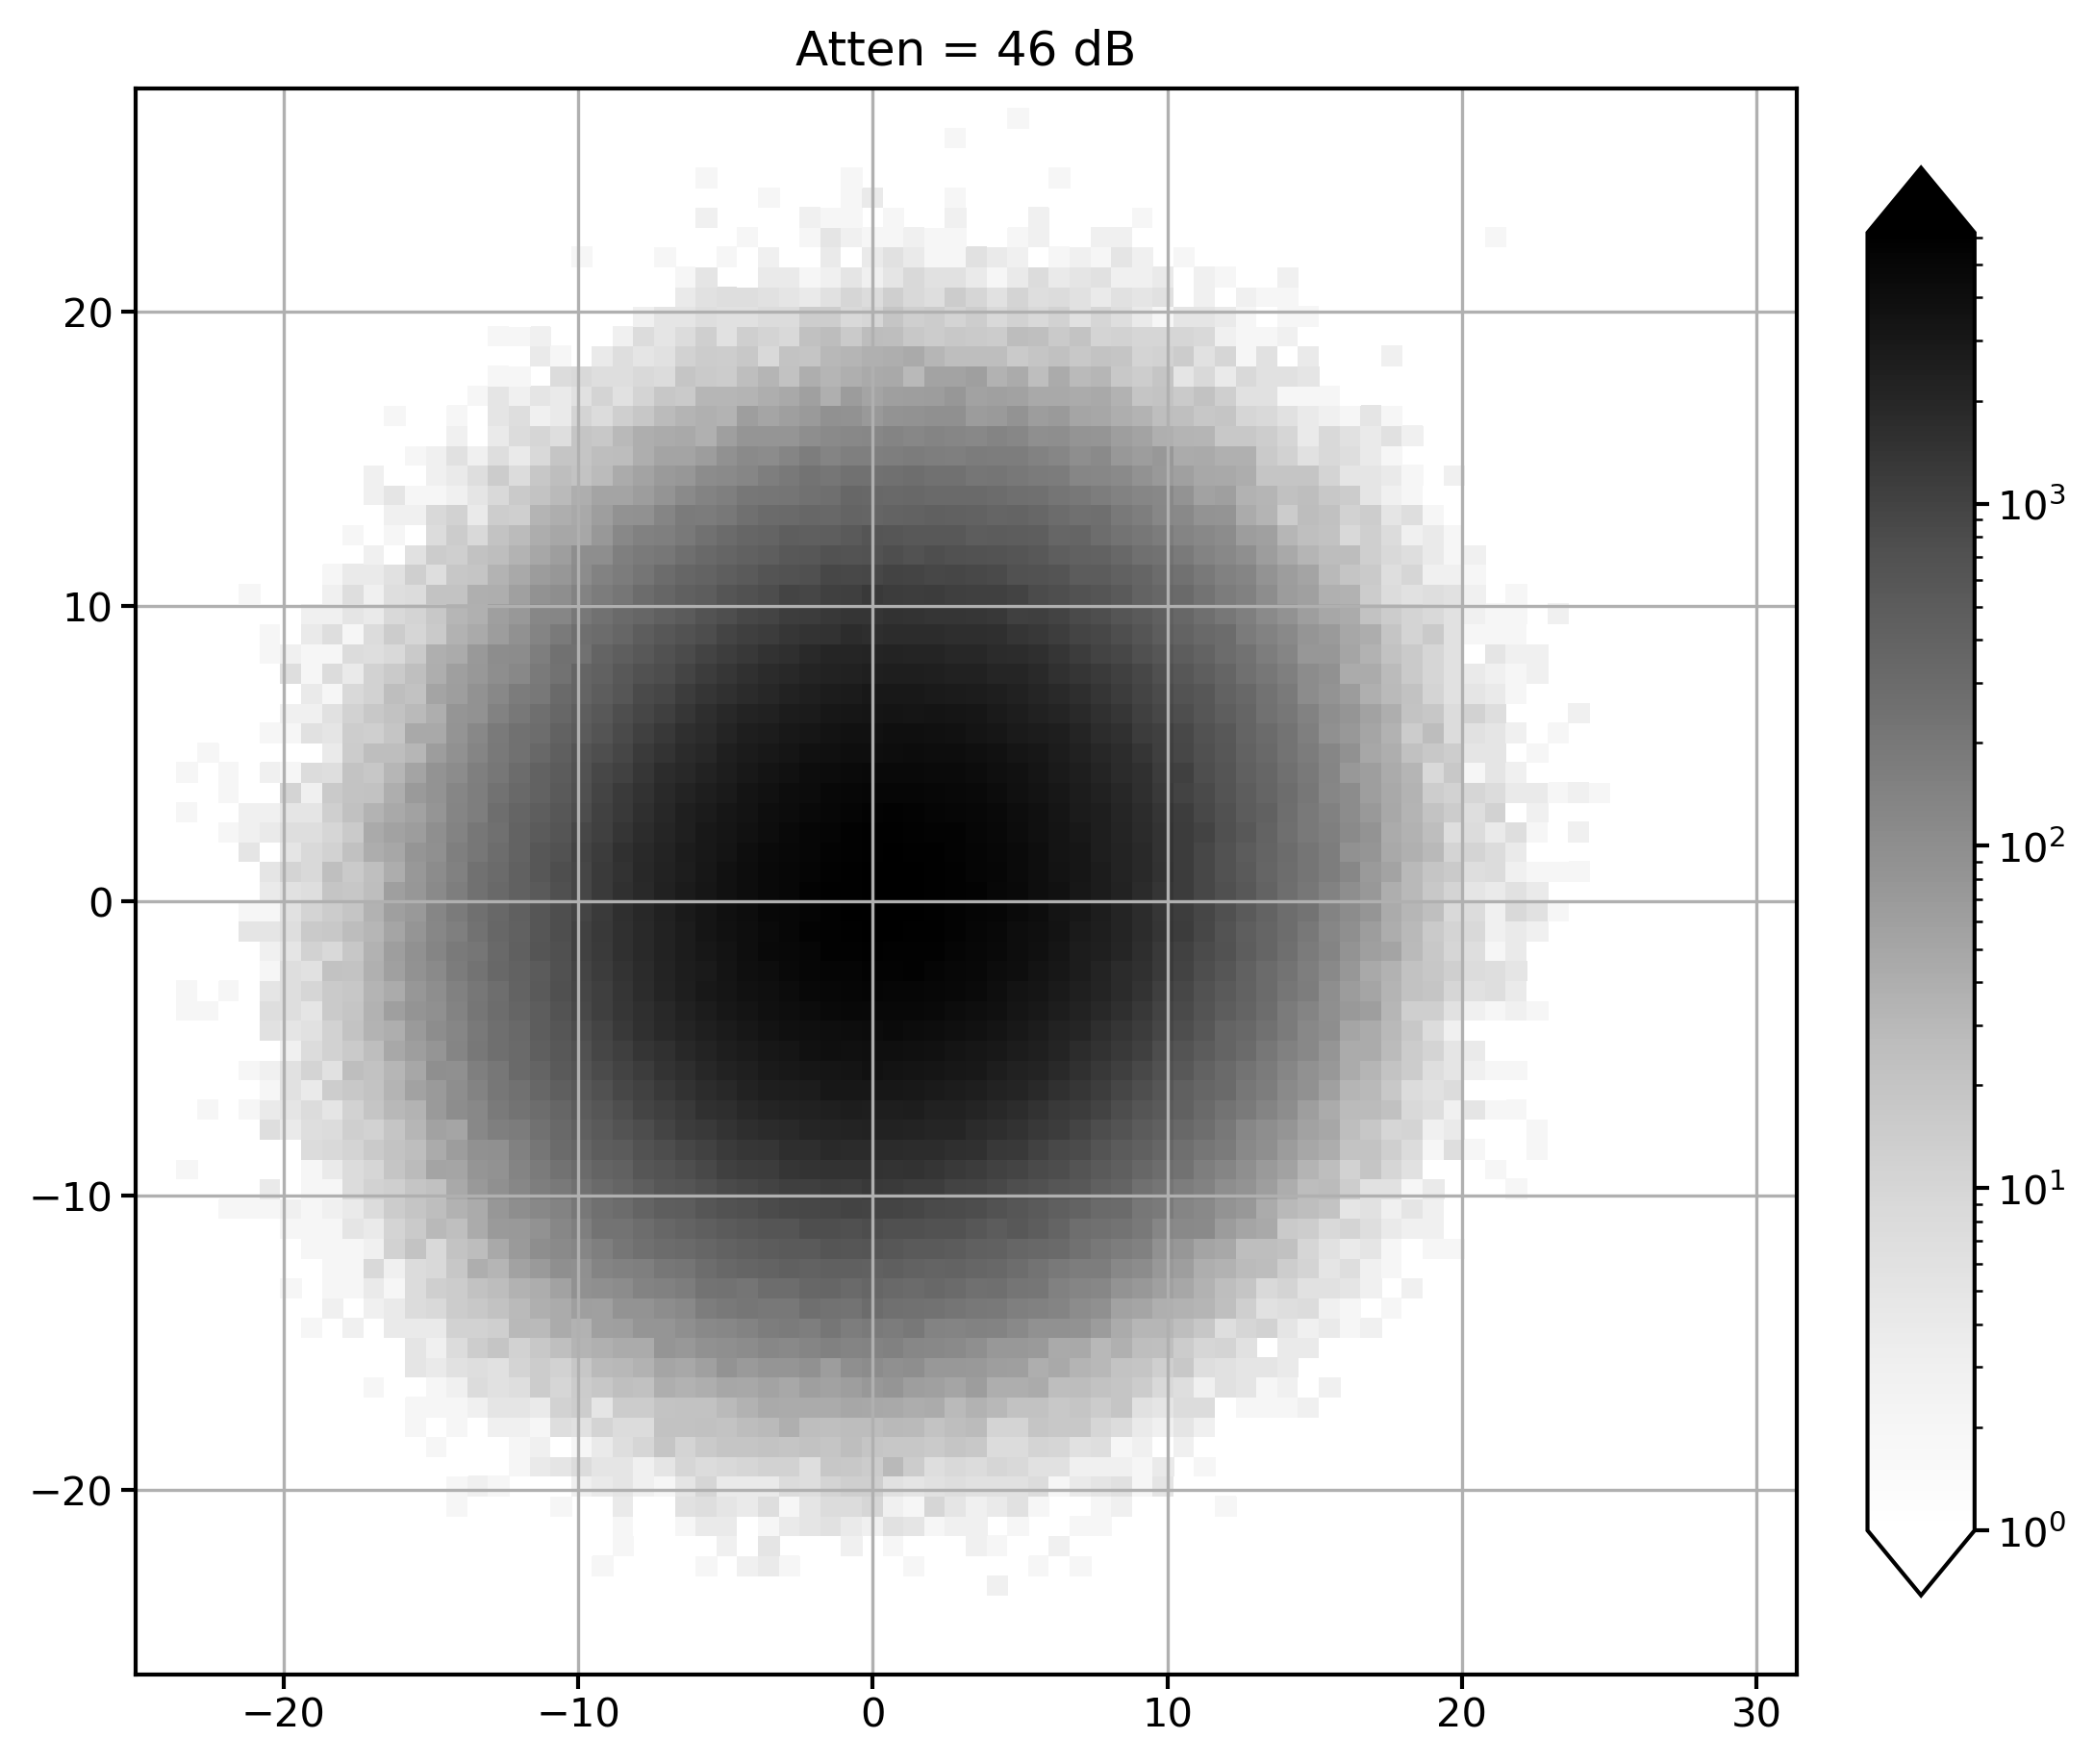

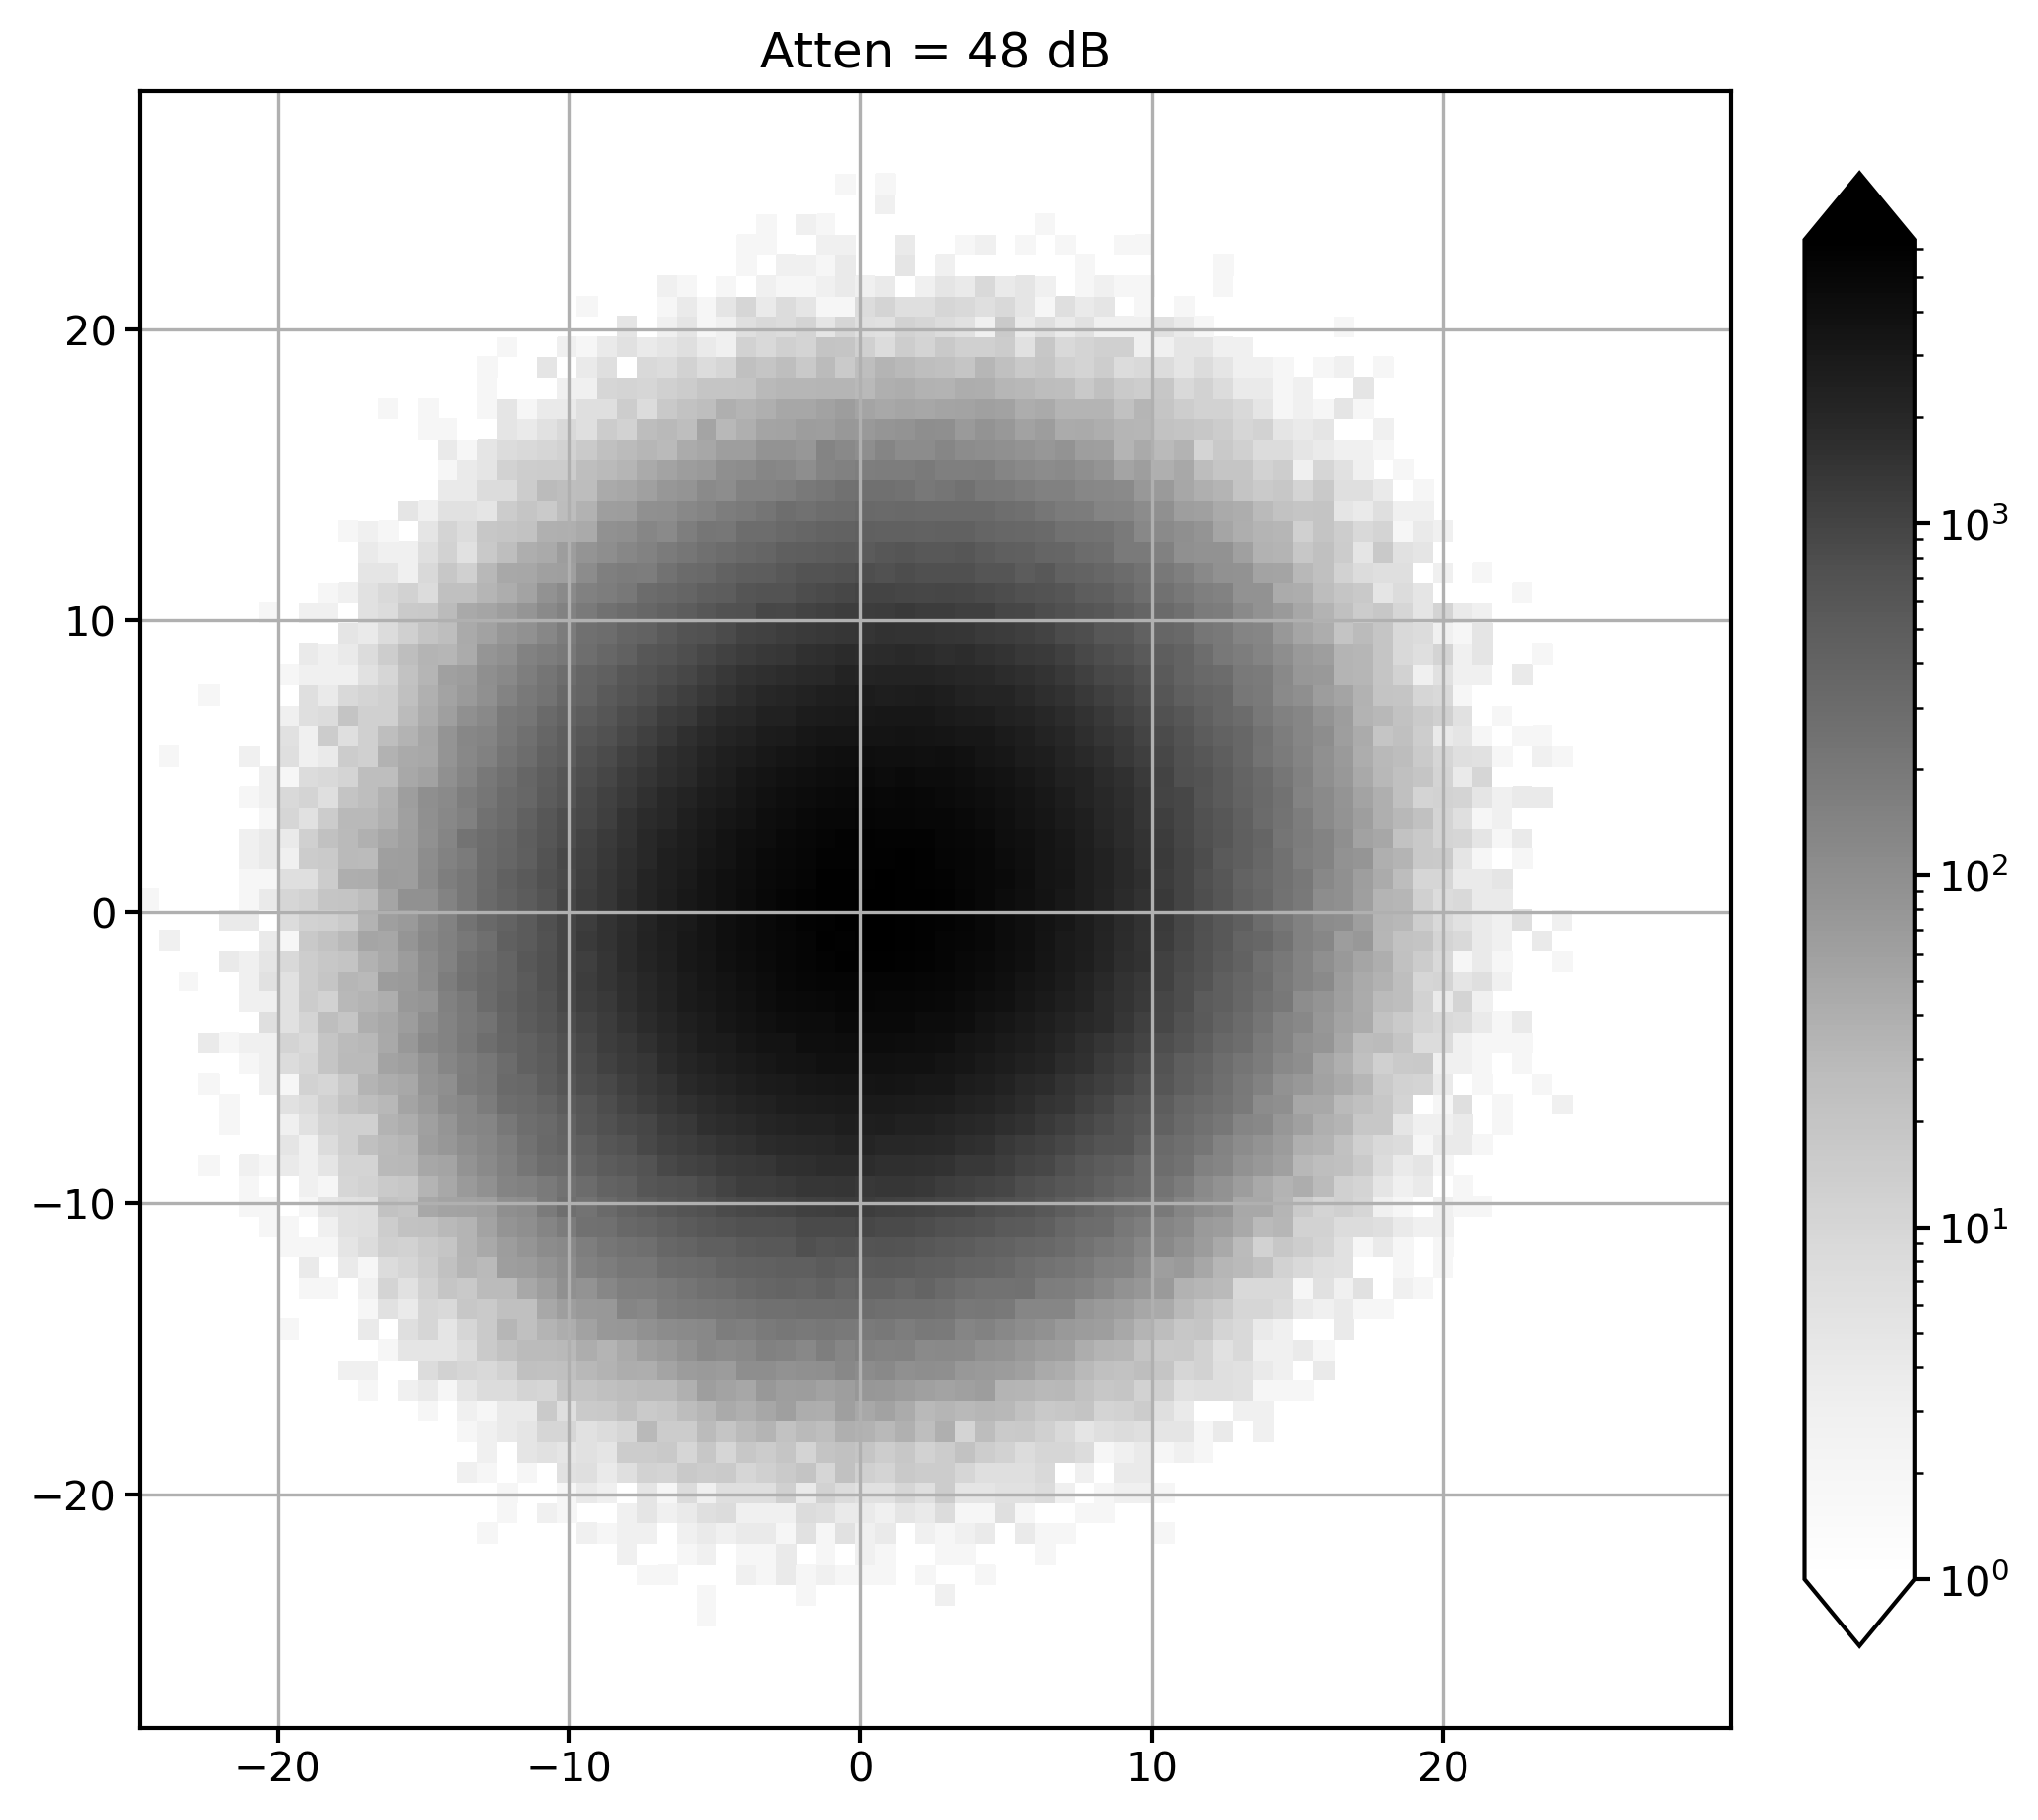

In [77]:
for i,file in enumerate(files):
    data = qp.loadAlazarData(file)
    data = qp.BoxcarDownsample(data,2,10)
    data = qp.uint16_to_mV(data)
    
    qp.plotComplexHist(data[0],data[1])
    plt.title(f'Atten = {attens[i]} dB')
    plt.show()
    plt.close()

## Power to Device

`LOpower` is the power to the device

`idealPower` is the power known above which the resonator goes non-linear

`chosenAtten` is the attenuation below which the resonator goes non-linear

In [78]:
fixedAttenuation = 20 + 10
LOpower = 20 - 3 - 20 - fixedAttenuation - 10 - 75 - 3 - np.array(attens)

In [79]:
idealPower = -127
chosenAtten = 2

In [80]:
index = int(np.where(attens == chosenAtten)[0])

LOpower[index], attens[index]

(-123, 2)

In [81]:
LOpower[int(np.where(attens==attens[index])[0])]

-123

In [83]:
numModes = 3

In [84]:
sampleRateFromData = 10

data = qp.loadAlazarData(files[index])
data, sr = qp.BoxcarDownsample(data, avgTime=3, sampleRate=sampleRateFromData, returnRate=True) 
data = qp.uint16_to_mV(data)

%matplotlib qt
create_IQ_plot(data)
means = plt.ginput(n=numModes)

## Extract the means from the plot

In [85]:
means

[(-40.137901791005646, -23.45531727629396),
 (33.07551489862212, -51.803946634230634),
 (-7.352095664000629, -54.022535018764806)]

In [86]:
%matplotlib inline


In [87]:
intTime = 1
skip = index
# breakTime = 50
SNRmin = 3
n_comp = 3

In [90]:
covars = np.array([[[5,1],[1,5]],
                   [[5,1],[1,5]],
                   [[5,1],[1,5]]
                   ])

In [91]:
attens[skip:]

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40, 42, 44, 46, 48])

# HMM Fitting

##  HMM with James Comments (NOT FUNCTIONAL)

In [ ]:
MEANS = []
HMM = []
TAUS = []
STARTS = [] # starting probailities
P0s = [] # prob of having 0 qp over each file
P1s = []
P2s = []
sampleRateFromData = 10 # MHz

#######################################3
# original code used i,file in enumerate(files). There are still some dependencies on i in the code below
#########################################
for atten,file in zip(attens[index:],files[index:]):
    
    metainfo = {
        'f0': f0,
        'LOf': LOf,
       #'Delta': Delta,
        'phi': phi,
        'eccosorb': eccosorb,
        'KandL': KandL,
        'rigidCables': rigidCables,
        'JPA': JPA,
        'TWPA': TWPA,
        'ClearingCoupler': ClearingCoupler,
        'dateOfMeasurement': dateOfMeasurement,
        'sampleRateMHz': sampleRateMHz,
        'durationSeconds': durationSeconds,
        'Temperature': Temp}
    
    LOpower = 20 - 3 - 20 - 20 - 10 - 75 - 3 - np.array(attens)
    print(f"attenuation: {atten}")
    savefile = os.path.join(project_path,'powerSweep','AnalyisResults',f'FullDataset_2_modes_JamesRerun.hdf5')
    
    if not os.path.exists(os.path.split(savefile)[0]):
        os.makedirs(os.path.split(savefile)[0])
    
    figpath = os.path.join(figurepath, f'ATTEN{atten}')
    if not os.path.exists(figpath):
        os.makedirs(figpath)
    
    with h5py.File(savefile,'a') as f:
        g = f.require_group(f'ATTEN{atten}')
        for key in metainfo:
            g.attrs.create(key,metainfo[key])
    
    ###########################################################
    # In boxcar downsampling below, avgTime is hard coded to always start at 1.
    # At each iteration of this loop, we expect the results to change only by a small amount;
    # this is why we use the previous values of means and covars as initial guesses.
    # Similarly, we should use the previous avgTime so as to avoid unecessary fits (we're decreasing
    # our readout power at each iteration. avgTime should only increase from one iteration to the next,
    # never get smaller, so if it's increased due to failing SNR check, there's no reason to return to 1)
    #############################################################
    # oops, accidentaly hit shift+enter. Hopefully stopped it before overwriting anything!
    data = qp.loadAlazarData(file)
#     data, sr = qp.BoxcarDownsample(data, avgTime=1,sampleRate=sampleRateFromData, returnRate=True)
    data, sr = qp.BoxcarDownsample(data, avgTime=intTime,sampleRate=sampleRateFromData, returnRate=True) 
    data = qp.uint16_to_mV(data)
    # fit the HMM
    
    M = hmm.GaussianHMM(n_components=n_comp,covariance_type='full',init_params='s',n_iter=500,tol=0.001)
    M.means_ = means
    M.covars_ = covars
    
    
    if n_comp == 3:
        M.transmat_ = np.array([[0.99, 0.009,0.001],[0.03, 0.95,0.02],[0.05,0.05,0.9]])
    else:
        M.transmat_ = np.array([[0.99, 0.01],[0.01, 0.99]])
        
    M.fit(data.T)
    
    HMM.append(M)
    
    #########################################
    # the block below uses loop index i to get the previous HMM results. i is now static, so 
    # our failure condition comparing intTime to lifetimes is broken
    #################3#######################3
    with h5py.File(savefile,'r') as ff:
        f = ff[f'ATTEN{atten}']
        oldrates = f[f'{i+skip-1}/transitionRatesMHz'][:] if i != 0 else 0.0001*np.ones((n_comp,n_comp))
        lifetimes = np.array([1/oldrates[j,j] for j in range(n_comp)])
        t01 = 1/oldrates[0,1]
        t10 = 1/oldrates[1,0]
        ttimes = np.array([t01,t10])
    

    # get SNR
    snr01 = qp.getSNRhmm(M,mode1=0,mode2=1)
    SNRs = np.array([snr01,])

    logprob,Q = M.decode(data.T)
    Qmean = np.mean(Q)
    P0 = np.sum(Q == 0)/Q.size
    P1 = np.sum(Q == 1)/Q.size
    P2 = np.sum(Q == 2)/Q.size

    if np.min(SNRs) < SNRmin and intTime <= np.min(lifetimes)/2 and intTime <= np.min(ttimes) and P1 < P0:
        success = False
        srold = np.copy(sr)
        while not success:
            intTime *= 1.15*SNRmin/np.min(SNRs)
            print(f'\n\n\nNew integration time = {intTime} because SNR was {np.min(SNRs):.6}\n\n\n')
            data = qp.loadAlazarData(file)
            srold = np.copy(sr)
            data, sr = qp.BoxcarDownsample(data,intTime,sampleRateMHz,returnRate = True)
            data = qp.uint16_to_mV(data)
            M = hmm.GaussianHMM(n_components=n_comp,covariance_type='full',init_params='s',n_iter=500,tol=0.001)
            
            ###################################################
            # The block below also has dependency on loop index i. 
            # Now when the SNR is small and we try fitting with increased intTime, it will pull
            # less than ideal initial values for means and covars.
            ###################################################
            with h5py.File(savefile,'r') as ff:
                f = ff[f'ATTEN{atten}']
                M.means_ = f[f'{i+skip-1}'].attrs.get('HMMmeans_') if i != 0 else means
                M.covars_ = f[f'{i+skip-1}'].attrs.get('HMMcovars_') if i != 0 else covars
            if n_comp == 3:
                M.transmat_ = np.array([[0.99, 0.009,0.001],[0.03, 0.95,0.02],[0.05,0.05,0.9]])
            else:
                M.transmat_ = np.array([[0.99, 0.01],[0.01, 0.99]])
            M.fit(data.T)
            # get SNR
            snr01 = qp.getSNRhmm(M,mode1=0,mode2=1)
            SNRs = np.array([snr01,])
            if np.min(SNRs) > SNRmin:
                success = True
            elif intTime > np.min(lifetimes)/2 or intTime > np.min(ttimes):
                print('Integration time has grown too large.')
                break
            if sr == srold:
                print('stuck in loop, exiting')
                break
            srold = np.copy(sr)
    
    ###################3
    # i > 3 condition can never be met with static i = 0
    #####################
    if intTime > np.min(lifetimes)/2 and i > 3:
        print('Integration time has grown too large.')
        break
    if P1 > P0:
        print('P1 became larger than P0!')
        break

    # plot the fit
    ##################
    # i is also used in several places for plotting here
    ####################
    h = qp.plotComplexHist(data[0],data[1],figsize=[4,4])
    if n_comp == 3:
        qp.make_ellipsesHMM(M,h,['purple','orange','green'])
    else:
        qp.make_ellipsesHMM(M,h,['purple','orange'])
    plt.xlabel('I [mV]')
    plt.ylabel('Q [mV]')
    plt.title('HMM fit | {:.2} MHz | {} dBm'.format(sr,LOpower[i+skip]))
    plt.savefig(os.path.join(figpath,'HMMfits_{}_{}dBm.png'.format(i+skip,LOpower[i+skip])))
    plt.close()

    # extract occupation
    logprob,Q = M.decode(data.T)
    Qmean = np.mean(Q)
    P0 = np.sum(Q == 0)/Q.size
    P1 = np.sum(Q == 1)/Q.size
    P2 = np.sum(Q == 2)/Q.size

    # plot a section of time series
    fig, ax = qp.plotTimeSeries(data,Q,np.arange(Q.size)/sr,1500,2000,zeroTime=True)
    plt.title('{:.2} MHz | {} dBm'.format(sr,LOpower[i+skip]))
    plt.savefig(os.path.join(figpath,'TimeSeries__{}_{}dBm.png'.format(i+skip,LOpower[i+skip])))
    plt.close()

    # get the transition rates
    rates = qp.getTransRatesFromProb(sr,M.transmat_)

    # save all the information to aggregate file
    ##################
    # i is used in a few places here, in particular the last attributes LOpower and attens are incorrect
    # also note that skip has no meaning anymore. the variable index found from power = -127 has taken on the same role
    ##################
    with h5py.File(savefile,'a') as ff:
        f = ff[f'ATTEN{atten}']
        fp = f.require_group('{}'.format(i+skip))
        fp.create_dataset('Q',data = Q)
        fp.create_dataset('data',data = data)
        fp.create_dataset('transitionRatesMHz',data = rates)
        fp.attrs.create('logprobQ',logprob)
        fp.attrs.create('mean',Qmean)
        fp.attrs.create('P0',P0)
        fp.attrs.create('P1',P1)
        fp.attrs.create('P2',P2)
        fp.attrs.create('SNRs',SNRs)
        fp.attrs.create('downsampleRateMHz',sr)
        fp.attrs.create('HMMmeans_',M.means_)
        fp.attrs.create('HMMstartprob_',M.startprob_)
        fp.attrs.create('HMMcovars_',M.covars_)
        fp.attrs.create('HMMtransmat_',M.transmat_)
        fp.attrs.create('LOpower',LOpower[i+skip])
        fp.attrs.create('DAsetting',attens[i+skip])
        for key in metainfo:
            fp.attrs.create(key,metainfo[key])

    # save a copy of current means to use as estimate for next power
    means2= np.copy(M.means_)
    covars2= np.copy(M.covars_)

## James' Code

### Reinserting i as a loop index and running again

In [94]:
intTime = 1
skip = index
# breakTime = 50
SNRmin = 3
n_comp = 3

dateOfMeasurement = 20221005
Temp = 30

eccosorb = True
KandL = True
rigidCables = True
JPA = True
TWPA = True
ClearingCoupler = False
sampleRateMHz = 10
durationSeconds = 5

f0 = 4.2727
LOf = 4.27238
phi = 0.47

covars = np.array([[[5,1],[1,5]],
                   [[5,1],[1,5]],
                   [[5,1],[1,5]]
                   ])

attens[index:]

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36, 38, 40, 42, 44, 46, 48])

In [95]:
means

[(-40.137901791005646, -23.45531727629396),
 (33.07551489862212, -51.803946634230634),
 (-7.352095664000629, -54.022535018764806)]

In [96]:
MEANS = []
HMM = []
TAUS = []
STARTS = [] # starting probailities
P0s = [] # prob of having 0 qp over each file
P1s = []
P2s = []
sampleRateFromData = 10 # MHz

skip = np.copy(index)
#######################################3
# original code used i,file in enumerate(files). There are still some dependencies on i in the code below
#########################################
for i,atten,file in zip(np.arange(len(attens[index:])),attens[index:],files[index:]):
    
    metainfo = {
        'f0': f0,
        'LOf': LOf,
       #'Delta': Delta,
        'phi': phi,
        'eccosorb': eccosorb,
        'KandL': KandL,
        'rigidCables': rigidCables,
        'JPA': JPA,
        'TWPA': TWPA,
        'ClearingCoupler': ClearingCoupler,
        'dateOfMeasurement': dateOfMeasurement,
        'sampleRateMHz': sampleRateMHz,
        'durationSeconds': durationSeconds,
        'Temperature': Temp}
    
    LOpower = 20 - 3 - 20 - 20 - 10 - 75 - 3 - np.array(attens)
    print(f"attenuation: {atten}")
    savefile = os.path.join(project_path,'powerSweep','AnalyisResults',f'FullDataset_2_modes.hdf5')
    
    if not os.path.exists(os.path.split(savefile)[0]):
        os.makedirs(os.path.split(savefile)[0])
    
    figpath = os.path.join(figurepath, f'ATTEN{atten}')
    if not os.path.exists(figpath):
        os.makedirs(figpath)
    
    with h5py.File(savefile,'a') as f:
        g = f.require_group(f'ATTEN{atten}')
        for key in metainfo:
            g.attrs.create(key,metainfo[key])
    
    ###########################################################
    # In boxcar downsampling below, avgTime is hard coded to always start at 1.
    # At each iteration of this loop, we expect the results to change only by a small amount;
    # this is why we use the previous values of means and covars as initial guesses.
    # Similarly, we should use the previous avgTime so as to avoid unecessary fits (we're decreasing
    # our readout power at each iteration. avgTime should only increase from one iteration to the next,
    # never get smaller, so if it's increased due to failing SNR check, there's no reason to return to 1)
    #############################################################
    # oops, accidentaly hit shift+enter. Hopefully stopped it before overwriting anything!
    data = qp.loadAlazarData(file)
#     data, sr = qp.BoxcarDownsample(data, avgTime=1,sampleRate=sampleRateFromData, returnRate=True)
    data, sr = qp.BoxcarDownsample(data, avgTime=intTime,sampleRate=sampleRateFromData, returnRate=True) 
    data = qp.uint16_to_mV(data)
    # fit the HMM
    
    M = hmm.GaussianHMM(n_components=n_comp,covariance_type='full',init_params='s',n_iter=500,tol=0.001)
    M.means_ = means
    M.covars_ = covars
    
    
    if n_comp == 3:
        M.transmat_ = np.array([[0.99, 0.009,0.001],[0.03, 0.95,0.02],[0.05,0.05,0.9]])
    else:
        M.transmat_ = np.array([[0.99, 0.01],[0.01, 0.99]])
        
    M.fit(data.T)
    
    HMM.append(M)
    
    #########################################
    # the block below uses loop index i to get the previous HMM results. i is now static, so 
    # our failure condition comparing intTime to lifetimes is broken
    #################3#######################3
    with h5py.File(savefile,'r') as ff:
#         f = ff[f'ATTEN{attens[i+skip-1]}'] 
        # altered here because we want the previous iteration
        oldrates = ff[f'ATTEN{attens[i+skip-1]}/transitionRatesMHz'][:] if i != 0 else 0.0001*np.ones((n_comp,n_comp))
        lifetimes = np.array([1/oldrates[j,j] for j in range(n_comp)])
        t01 = 1/oldrates[0,1]
        t10 = 1/oldrates[1,0]
        ttimes = np.array([t01,t10])
    

    # get SNR
    snr01 = qp.getSNRhmm(M,mode1=0,mode2=1)
    SNRs = np.array([snr01,])

    logprob,Q = M.decode(data.T)
    Qmean = np.mean(Q)
    P0 = np.sum(Q == 0)/Q.size
    P1 = np.sum(Q == 1)/Q.size
    P2 = np.sum(Q == 2)/Q.size

    if np.min(SNRs) < SNRmin and intTime <= np.min(lifetimes)/2 and intTime <= np.min(ttimes) and P1 < P0:
        success = False
        srold = np.copy(sr)
        while not success:
            intTime *= 1.15*SNRmin/np.min(SNRs)
            print(f'\n\n\nNew integration time = {intTime} because SNR was {np.min(SNRs):.6}\n\n\n')
            data = qp.loadAlazarData(file)
            srold = np.copy(sr)
            data, sr = qp.BoxcarDownsample(data,intTime,sampleRateMHz,returnRate = True)
            data = qp.uint16_to_mV(data)
            M = hmm.GaussianHMM(n_components=n_comp,covariance_type='full',init_params='s',n_iter=500,tol=0.001)
            
            ###################################################
            # The block below also has dependency on loop index i. 
            # Now when the SNR is small and we try fitting with increased intTime, it will pull
            # less than ideal initial values for means and covars.
            ###################################################
            with h5py.File(savefile,'r') as ff:
#                 f = ff[f'ATTEN{attens[i+skip-1]}'] 
                # altered here because we want the previous iteration
                M.means_ = ff[f'ATTEN{attens[i+skip-1]}'].attrs.get('HMMmeans_') if i != 0 else means
                M.covars_ = ff[f'ATTEN{attens[i+skip-1]}'].attrs.get('HMMcovars_') if i != 0 else covars
            if n_comp == 3:
                M.transmat_ = np.array([[0.99, 0.009,0.001],[0.03, 0.95,0.02],[0.05,0.05,0.9]])
            else:
                M.transmat_ = np.array([[0.99, 0.01],[0.01, 0.99]])
            M.fit(data.T)
            # get SNR
            snr01 = qp.getSNRhmm(M,mode1=0,mode2=1)
            SNRs = np.array([snr01,])
            if np.min(SNRs) > SNRmin:
                success = True
            elif intTime > np.min(lifetimes)/2 or intTime > np.min(ttimes):
                print('Integration time has grown too large.')
                break
            if sr == srold:
                print('stuck in loop, exiting')
                break
            srold = np.copy(sr)
    
    ###################3
    # i > 3 condition can never be met with static i = 0
    #####################
    if intTime > np.min(lifetimes)/2 and i > 3:
        print('Integration time has grown too large.')
        break
    if P1 > P0:
        print('P1 became larger than P0!')
        break

    # plot the fit
    ##################
    # i is also used in several places for plotting here
    ####################
    h = qp.plotComplexHist(data[0],data[1],figsize=[4,4])
    if n_comp == 3:
        qp.make_ellipsesHMM(M,h,['purple','orange','green'])
    else:
        qp.make_ellipsesHMM(M,h,['purple','orange'])
    plt.xlabel('I [mV]')
    plt.ylabel('Q [mV]')
    plt.title('HMM fit | {:.2} MHz | {} dBm'.format(sr,LOpower[i+skip]))
    plt.savefig(os.path.join(figpath,'HMMfits_{}_{}dBm.png'.format(i+skip,LOpower[i+skip])))
    plt.close()

    # extract occupation
    logprob,Q = M.decode(data.T)
    Qmean = np.mean(Q)
    P0 = np.sum(Q == 0)/Q.size
    P1 = np.sum(Q == 1)/Q.size
    P2 = np.sum(Q == 2)/Q.size

    # plot a section of time series
    fig, ax = qp.plotTimeSeries(data,Q,np.arange(Q.size)/sr,1500,2000,zeroTime=True)
    plt.title('{:.2} MHz | {} dBm'.format(sr,LOpower[i+skip]))
    plt.savefig(os.path.join(figpath,'TimeSeries__{}_{}dBm.png'.format(i+skip,LOpower[i+skip])))
    plt.close()

    # get the transition rates
    rates = qp.getTransRatesFromProb(sr,M.transmat_)

    # save all the information to aggregate file
    ##################
    # i is used in a few places here, in particular the last attributes LOpower and attens are incorrect
    # also note that skip has no meaning anymore. the variable index found from power = -127 has taken on the same role
    ##################
    with h5py.File(savefile,'a') as ff:
#         f = ff[f'ATTEN{atten}']
        fp = ff.require_group(f'ATTEN{atten}')
        fp.create_dataset('Q',data = Q)
        fp.create_dataset('data',data = data)
        fp.create_dataset('transitionRatesMHz',data = rates)
        fp.attrs.create('logprobQ',logprob)
        fp.attrs.create('mean',Qmean)
        fp.attrs.create('P0',P0)
        fp.attrs.create('P1',P1)
        fp.attrs.create('P2',P2)
        fp.attrs.create('SNRs',SNRs)
        fp.attrs.create('downsampleRateMHz',sr)
        fp.attrs.create('HMMmeans_',M.means_)
        fp.attrs.create('HMMstartprob_',M.startprob_)
        fp.attrs.create('HMMcovars_',M.covars_)
        fp.attrs.create('HMMtransmat_',M.transmat_)
        fp.attrs.create('LOpower',LOpower[i+skip])
        fp.attrs.create('DAsetting',attens[i+skip])
        for key in metainfo:
            fp.attrs.create(key,metainfo[key])

    # save a copy of current means to use as estimate for next power
    means= np.copy(M.means_)
    covars= np.copy(M.covars_)

attenuation: 2
attenuation: 4
attenuation: 6
attenuation: 8
attenuation: 10
attenuation: 12
attenuation: 14
attenuation: 16
attenuation: 18



New integration time = 1.2108895922735599 because SNR was 2.84914



attenuation: 20



New integration time = 1.912710290171728 because SNR was 2.18411



attenuation: 22



New integration time = 3.3645605820773405 because SNR was 1.96128



attenuation: 24



New integration time = 5.992241659087433 because SNR was 1.93713



attenuation: 26



New integration time = 10.849046137614847 because SNR was 1.90553



attenuation: 28



New integration time = 17.098985555144885 because SNR was 2.18897



attenuation: 30



New integration time = 28.349728285276765 because SNR was 2.08085



attenuation: 32



New integration time = 42.2874176225772 because SNR was 2.3129



attenuation: 34



New integration time = 66.27632698621805 because SNR was 2.20126



Integration time has grown too large.


# HMM Derived Plots

## Mean Occupation wrt DA Power

In [104]:
project_path = r"G:\Shared drives\Quasiparticles_2\NBR07_Oct2022\Power_Sweep_Alazar_Card_TWPA_JPA_ON_No_Final_Amplifier"


In [110]:
savefile = os.path.join(project_path,'powerSweep','AnalyisResults',f'FullDataset_2_modes.hdf5')

In [111]:
savefile = r"G:\Shared drives\Quasiparticles_2\NBR07_Oct2022\Power_Sweep_Alazar_Card_TWPA_JPA_On_No_Final_Amplifier\powerSweep\AnalyisResults\F"

'G:\\Shared drives\\Quasiparticles_2\\NBR07_Oct2022\\Power_Sweep_Alazar_Card_TWPA_JPA_ON_No_Final_Amplifier\\powerSweep\\AnalyisResults\\FullDataset_2_modes.hdf5'

In [118]:
MEANS = []
P0 = []
P1 = []
P2 = []
TAUS = []
TRANS_RATE = []
attens_analyzed = []

with h5py.File(savefile,'r') as f:
    try:
        for i in attens[index:]:
            #hdf5_index = list(f[f"ATTEN{i}"].keys())[0]
           # means_qp = f[f'ATTEN{i}/{hdf5_index}'].attrs.get('mean')
            means_qp = f[f'ATTEN{i}'].attrs.get('mean')
            P0.append(f[f'ATTEN{i}'].attrs.get('P0'))
            P1.append(f[f'ATTEN{i}'].attrs.get('P1'))
            P2.append(f[f'ATTEN{i}'].attrs.get('P2'))

            TRANS_RATE.append(f[f'ATTEN{i}/transitionRatesMHz'][:])
            MEANS.append(means_qp)
            attens_analyzed.append(i)
    except Exception as e:
        print(e)

"Unable to open object (object 'ATTEN2' doesn't exist)"


In [117]:
attens_analyzed

[]

Text(0.5, 0, 'DA Attenuation [dBm]')

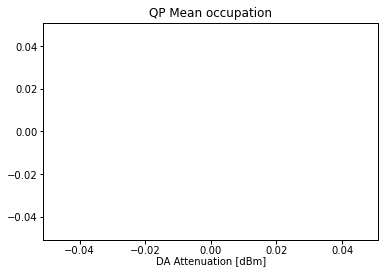

In [115]:
plt.plot(attens_analyzed,MEANS,'--x')
plt.title('QP Mean occupation')
plt.xlabel('DA Attenuation [dBm]')

## $P_O, P_1, P_2$  wrt DA Power

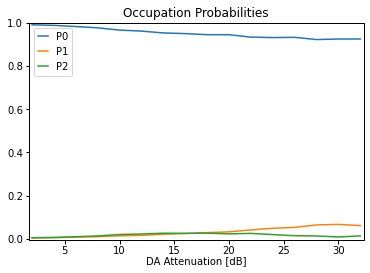

In [103]:
plt.plot(attens_analyzed,P0[:-1],label='P0')
plt.plot(attens_analyzed,P1[:-1],label='P1')
plt.plot(attens_analyzed,P2[:-1],label='P2')

plt.title('Occupation Probabilities')
plt.xlabel('DA Attenuation [dB]')
plt.legend()

##  $\tau_{1,2,3}$  wrt DA Power

In [ ]:
TAUS = np.array(TAUS)

In [ ]:
plt.plot(attens,TAUS[:,0],label='$\\tau_0$')
plt.plot(attens,TAUS[:,1],label='$\\tau_1$')
plt.plot(attens,TAUS[:,2],label='$\\tau_2$')
plt.title('Mode Lifetimes')
plt.xlabel('DA Attenuation [dBm]')
plt.legend()

In [ ]:
plt.semilogy(attens,TAUS[:,0],label='$\\tau_0$')
plt.semilogy(attens,TAUS[:,1],label='$\\tau_1$')
plt.semilogy(attens,TAUS[:,2],label='$\\tau_2$')
plt.title('Mode Lifetimes')
plt.xlabel('DA Attenuation [dBm]')
plt.legend()

# How does HMM read the SNR vs power?

In [ ]:
import importlib
importlib.reload(qp)

In [ ]:
SNR = []
for M in HMM:
    snr01 = qp.getSNRhmm(M,0,1)
    snr12 = qp.getSNRhmm(M,1,2)
    snr20 = qp.getSNRhmm(M,2,0)
    SNR.append([snr01,snr12,snr20])

In [ ]:
SNR = np.array(SNR)

In [ ]:
plt.plot(attens,SNR[:,0],label='$SNR_{01}$')
plt.plot(attens,SNR[:,1],label='$SNR_{12}$')
plt.plot(attens,SNR[:,2],label='$SNR_{20}$')
plt.title('mode snr')
plt.xlabel('attenuation [dB]')
plt.legend()

# OK let's save these HMMs using pickle so we can easily inspect them again

In [ ]:
import pickle

In [ ]:
attens

In [ ]:
project_path

In [ ]:
HMM

In [ ]:
for i,M in enumerate(HMM):
    fp = r"{}\\HMM_DA_{}dB.pkl".format(project_path, attens[i])
    path,fname = os.path.split(fp)
    if not os.path.exists(path):
        os.makedirs(path)
    with open(fp,'wb') as f:
        pickle.dump(M,f)

# Should have saved the extracted occupation, let's rerun the sweep using the saved HMMs rather than refiting:

In [ ]:
importlib.reload(qp)

In [ ]:
Qs = []
lts = []
alts = []
for i,M in enumerate(HMM):
    data = qp.loadAlazarData(files[i])
    data,rate = qp.BoxcarDownsample(data, 1, 10, returnRate=True)
    data = qp.uint16_to_mV(data)
    logprob, Q = M.decode(data.T,algorithm='viterbi')
    Qs.append(Q)
    
    time = np.arange(len(Q))/rate
        
    fig,ax = plt.subplots(2,1,figsize=[9,6])
    sind = 1000
    eind = 3000
    # ax[0].plot(time[sind:eind],obs1[sind:eind],label='true',alpha=1,lw=8)
    ax[0].plot(time[sind:eind],Q[sind:eind],label='HMM')
    ax[0].legend()
    ax[0].set_ylabel('Occupation')
    ax[1].set_ylabel('mV')
    ax[1].set_xlabel('Time [$\mu$s]')
    ax[1].plot(time[sind:eind],data[0,sind:eind],label='real')
    ax[1].plot(time[sind:eind],data[1,sind:eind],label='imag')
    # plt.plot(nEst[5000:5200],label='subtractMethod',alpha=0.6,ls='dashed',lw=6)
    # plt.plot(nEstQM[5000:5200],label='QuietMethod',alpha = 0.6,ls='dotted',lw=5)
    ax[1].legend()
    # ax[0].set_title(f'{r.photonRO} RO | {r.pSNR:2.3f} raw pSNR | {snr01:2.3f} IQ pSNR')
    plt.savefig(figurepath+'exampleTimeSeries_DA_{}dB.png'.format(attens[i]))
    plt.show()
    plt.close()
    
    
    lt = qp.extractLifetimes(Q,time)
    lts.append(lt)
    for key in lt:
        if len(lt[key]):
            h = qp.fitAndPlotExpDecay(lt[key],cut=np.mean(lt[key]),bins=200)
            plt.title(f'LT mode {key} | DA {attens[i]} dB')
            plt.show()
            plt.close()
    alt = qp.extractAntiLifetimes(Q,time)
    alts.append(alt)
    for key in alt:
        if len(alt[key]):
            h = qp.fitAndPlotExpDecay(alt[key],cut=np.mean(alt[key]),bins=200)
            plt.title(f'antiLT mode {key} | DA {attens[i]} dB')
            plt.show()
            plt.close()
    print('HMM w {} dB finds {} 0 QP events'.format(attens[i],len(lt['0'])))
    print('HMM w {} dB finds {} 1 QP events'.format(attens[i],len(lt['1'])))
    print('HMM w {} dB finds {} 2 QP events'.format(attens[i],len(lt['2'])))